# Capstone project with Spinnaker

### Purpose
> The objective of the project is to find tradable signals across sectors for helping investor to identify ‘sector-rotation patterns’ in financial markets and develop tradable predictions.

### Dataset
> The dataset contains sectoral data for 3 separate types of investments made in the US.
> *   Institutional Mutual Fund 
*   ETF
*   Retail Mutual Fund
>
> The weekly data spans 10 years from 2006 through end-Jan 2017. Not all sectors have data available for all the dates since new investment vehicles are introduced at various points in time.
<br><br>
Data fields:<br>
**ReportDate**: Weekly data aggregated and released every Wednesday	
**AssetClass**: Industry/Sector/Asset Class	
**Flow**: Amount of positive (inflow) or negative (outflow) in Millions of USD 	
**FlowPct**: Flows as percent of assets at beginning of the week 	
**AssetsEnd**: Assets at end of the week in Millions of USD	
**PortfolioChangePct**: Percent change in overall portfolio during the week



# Outline
* Notebook 1 - Data Cleaning + EDA + VAR Model 1
 1. Data cleaning
 2. Explanatory data analysis
 3. VAR Model 1-1: Within one market - ETF
 4. VAR Model 1-2: Within one market - Institutional MF

* Notebook 2 - VAR Model 2
 6. VAR Model 2-1: Cross-market
 7. VAR Model 2-2: Cross-market, smooth method applied

* Notebook 3 - VAR Model 3
 8. VAR Model 3: Cross-market, smooth method applied and market indices added


In [ ]:
! pip install -U statsmodels

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [ ]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics 

# color maps
from matplotlib import cm

# time series
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from scipy.stats import chi2_contingency
from scipy.spatial import distance

# chi-square test
import scipy
from scipy.stats import pearsonr

# VAR model 3: Cross-market, market indice added
%Portfolio_etf(t) = a + b1* %Portfolio_etf(t-1) + b2* %Flow_etf(t-1) + b3* %Portfolio_inst(t-1) + b4* %Flow_inst(t-1) + v

[ v = related market index (SP 500, Dow Jones, Nasdaq, Russell 2000): ClosePCT ]

## Import dataset

We add market indice as new variables into `combine_class` dataset and name it `combine_new`.

In [ ]:
url_combine_new = 'https://raw.githubusercontent.com/huahuang95/Capstone-Project/main/Datasets/new%20combine.csv?token=ARFHYYD44LLCMBFXVBCT4JLAU7DOQ'
combine_new = pd.read_csv(url_combine_new)
combine_new.head()

Unnamed: 0  ...    CpiPct
0           0  ...  0.314612
1           1  ...  0.314612
2           2  ...  0.314612
3           3  ...  0.314612
4           4  ...  0.314612

[5 rows x 25 columns]

## Preprocessing and handling outliers

In [ ]:
def preprocessing_new(df):
  # extract columns
  df = df[["AssetClass","ReportDate", "FlowPCT_i","PortfolioChangePct_i", "FlowPCT_e","PortfolioChangePct_e",'ClosePct_Nasdaq',	'VolumePct_Nasdaq',	'ClosePct_Dow',	'VolumePct_Dow',	'ClosePct_Russell',	'VolumePct_Russell',	'ClosePct_SP500',	'VolumePct_SP500', 'CpiPct']]
  df.rename(columns={"FlowPCT_i": "FlowPct_i", "FlowPCT_e": "FlowPct_e"}, inplace=True)
  
  # convert ReportDate to datetime 
  df['ReportDate'] = pd.to_datetime(df["ReportDate"])
  
  # extract year
  df['year'] = df['ReportDate'].dt.year

  # set ReportDate as index
  df.sort_values("ReportDate", inplace=True)
  df.set_index('ReportDate', inplace=True)
  return df


In [ ]:
# trim AssetClass names
combine_new['AssetClass'] = combine_new['AssetClass'].str.replace('-North America-USA-North America-Equity', '')
combine_new = preprocessing_new(combine_new)

grouped = combine_new.groupby(combine_new['AssetClass'])
com = grouped.get_group('Commodities/Materials')
con = grouped.get_group('Consumer Goods')
ene = grouped.get_group('Energy')
fin = grouped.get_group('Financials')
hea = grouped.get_group('Health Care/Biotech')
ind = grouped.get_group('Industrials')
lcb = grouped.get_group('Large Cap Blend')
lcg = grouped.get_group('Large Cap Growth')
lcv = grouped.get_group('Large Cap Value')
mcb = grouped.get_group('Mid Cap Blend')
mcg = grouped.get_group('Mid Cap Growth')
mcv = grouped.get_group('Mid Cap Value')
rea = grouped.get_group('Real Estate')
scb = grouped.get_group('Small Cap Blend')
scg = grouped.get_group('Small Cap Growth')
scv = grouped.get_group('Small Cap Value')
tec = grouped.get_group('Technology')
tel = grouped.get_group('Telecom')
uti = grouped.get_group('Utilities')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

Similarly, we use winsorizing method to handle outliers in new variables, market indice, by replacing them with the 1st and 99th percentile.

In [ ]:
# winsorizing: replace outliers with the 1st and 99th percentile by year
def clipped_new(df):
  # FlowPct_i
  # loop over 2006 to 2017
  for i in range(2006, 2018):
    temp = df[df['year']==i]['FlowPct_i']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='FlowPct_i') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp]) 
  df1 = pd.DataFrame(append)
  
  # replace the original column with the winsorized one
  df.drop(columns='FlowPct_i', inplace=True)
  df = pd.concat([df, df1], axis=1)


  # repeat above steps
  # PortfolioChangePct_i
  for i in range(2006, 2018):
    temp = df[df['year']==i]['PortfolioChangePct_i']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='PortfolioChangePct_i') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='PortfolioChangePct_i', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # FlowPct_e
  for i in range(2006, 2018):
    temp = df[df['year']==i]['FlowPct_e']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='FlowPct_e') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='FlowPct_e', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # PortfolioChangePct_e
  for i in range(2006, 2018):
    temp = df[df['year']==i]['PortfolioChangePct_e']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='PortfolioChangePct_e') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='PortfolioChangePct_e', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # ClosePct_Nasdaq
  for i in range(2006, 2018):
    temp = df[df['year']==i]['ClosePct_Nasdaq']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='ClosePct_Nasdaq') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='ClosePct_Nasdaq', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # VolumePct_Nasdaq
  for i in range(2006, 2018):
    temp = df[df['year']==i]['VolumePct_Nasdaq']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='VolumePct_Nasdaq') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='VolumePct_Nasdaq', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # ClosePct_Dow
  for i in range(2006, 2018):
    temp = df[df['year']==i]['ClosePct_Dow']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='ClosePct_Dow') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='ClosePct_Dow', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # VolumePct_Dow
  for i in range(2006, 2018):
    temp = df[df['year']==i]['VolumePct_Dow']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='VolumePct_Dow') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='VolumePct_Dow', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # ClosePct_Russell
  for i in range(2006, 2018):
    temp = df[df['year']==i]['ClosePct_Russell']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='ClosePct_Russell') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='ClosePct_Russell', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # VolumePct_Russell
  for i in range(2006, 2018):
    temp = df[df['year']==i]['VolumePct_Russell']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='VolumePct_Russell') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='VolumePct_Russell', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # ClosePct_SP500
  for i in range(2006, 2018):
    temp = df[df['year']==i]['ClosePct_SP500']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='ClosePct_SP500') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='ClosePct_SP500', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # VolumePct_SP500
  for i in range(2006, 2018):
    temp = df[df['year']==i]['VolumePct_SP500']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='VolumePct_SP500') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='VolumePct_SP500', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # CpiPct
  for i in range(2006, 2018):
    temp = df[df['year']==i]['CpiPct']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='CpiPct') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='CpiPct', inplace=True)
  df = pd.concat([df, df1], axis=1)

  return df

In [ ]:
# save as dataframe with original names
com = clipped_new(com)
con = clipped_new(con)
ene = clipped_new(ene)
fin = clipped_new(fin)
hea = clipped_new(hea)
ind = clipped_new(ind)
lcb = clipped_new(lcb)
lcg = clipped_new(lcg)
lcv = clipped_new(lcv)
mcb = clipped_new(mcb)
mcg = clipped_new(mcg)
mcv = clipped_new(mcv)
rea = clipped_new(rea)
scb = clipped_new(scb)
scg = clipped_new(scg)
scv = clipped_new(scv)
tec = clipped_new(tec)
tel = clipped_new(tel)
uti = clipped_new(uti)

流式输出内容被截断，只能显示最后 5000 行内容。

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._clip_with_scalar(lower, upper, inplace=inplace)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:7358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._clip_with_scalar(lower, upper, inplace=inplace)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:7358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._clip_with_scalar(lower, upper, inplace=inplace)
/usr/local/lib/python3.7/dist-packages/pandas/

In [ ]:
com.drop(['AssetClass','year'],axis=1,inplace=True)
con.drop(['AssetClass','year'],axis=1,inplace=True)
ene.drop(['AssetClass','year'],axis=1,inplace=True)
fin.drop(['AssetClass','year'],axis=1,inplace=True)
hea.drop(['AssetClass','year'],axis=1,inplace=True)
ind.drop(['AssetClass','year'],axis=1,inplace=True)
lcb.drop(['AssetClass','year'],axis=1,inplace=True)
lcg.drop(['AssetClass','year'],axis=1,inplace=True)
lcv.drop(['AssetClass','year'],axis=1,inplace=True)
mcb.drop(['AssetClass','year'],axis=1,inplace=True)
mcg.drop(['AssetClass','year'],axis=1,inplace=True)
mcv.drop(['AssetClass','year'],axis=1,inplace=True)
rea.drop(['AssetClass','year'],axis=1,inplace=True)
scb.drop(['AssetClass','year'],axis=1,inplace=True)
scg.drop(['AssetClass','year'],axis=1,inplace=True)
scv.drop(['AssetClass','year'],axis=1,inplace=True)
tec.drop(['AssetClass','year'],axis=1,inplace=True)
tel.drop(['AssetClass','year'],axis=1,inplace=True)
uti.drop(['AssetClass','year'],axis=1,inplace=True)

## Moving average (windows=4)

* After choosing the windows=4 (one week) as the parameter, the moving average model could return us new datasets which are smoother and more useful in the prediction process.

In [ ]:
# smooth time series(set windows=4 (a month))
def rolling_avg(df):
  df = df.rolling(window=4).mean().iloc[3:,:]
  return df

In [ ]:
com = rolling_avg(com)
con = rolling_avg(con)
ene = rolling_avg(ene)
fin = rolling_avg(fin)
hea = rolling_avg(hea)
ind = rolling_avg(ind)
lcb = rolling_avg(lcb)
lcg = rolling_avg(lcg)
lcv = rolling_avg(lcv)
mcb = rolling_avg(mcb)
mcg = rolling_avg(mcg)
mcv = rolling_avg(mcv)
rea = rolling_avg(rea)
scb = rolling_avg(scb)
scg = rolling_avg(scg)
scv = rolling_avg(scv)
tec = rolling_avg(tec)
tel = rolling_avg(tel)
uti = rolling_avg(uti)

## Functions for VAR model

Update functions for new VAR models.

#### grangercausalitytests()

In [ ]:
# Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
      for r in df.index:
        test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
        min_p_value = np.min(p_values)
        df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


#### adf_test()

In [ ]:
# test stationary
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
def adf_test_0(df):
  adf1 = adfuller(df['FlowPct_i'], 12) # maxlag=12: maximum lag which is included in test
  print("Statistics analysis of Inst MF FlowPct\n")
  print("Statistic Test:", adf1[0])
  print("p-value:", adf1[1])

  # if p_value <= 0.05, we can reject null hypothesis and indicate that time series is stationary
  p_value = adf1[1]
  if p_value <= 0.05:
    print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
    print(f" => Series is Stationary.\n")
  else:
    print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
    print(f" => Series is Non-Stationary.\n")

  # repeat above steps
  adf2 = adfuller(df['PortfolioChangePct_i'], 12)
  print('----------------------------------------')
  print("Statistics analysis of Inst MF PortfolioChangePct\n")
  print("Statistic Test:", adf2[0])
  print("p-value:", adf2[1])
  p_value = adf2[1]
  if p_value <= 0.05:
    print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
    print(f" => Series is Stationary.\n")
  else:
    print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
    print(f" => Series is Non-Stationary.\n")

  adf3 = adfuller(df['FlowPct_e'], 12)
  print('========================================')
  print("Statistics analysis of ETF FlowPct\n")
  print("Statistic Test:", adf3[0])
  print("p-value:", adf3[1])
  p_value = adf3[1]
  if p_value <= 0.05:
    print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
    print(f" => Series is Stationary.\n")
  else:
    print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
    print(f" => Series is Non-Stationary.\n")

  adf4 = adfuller(df['PortfolioChangePct_e'], 12)
  print('----------------------------------------')
  print("Statistics analysis of ETF PortfolioChangePct\n")
  print("Statistic Test:", adf4[0])
  print("p-value:", adf4[1])
  p_value = adf4[1]
  if p_value <= 0.05:
    print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
    print(f" => Series is Stationary.")
  else:
    print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
    print(f" => Series is Non-Stationary.")


def adf_test(df):
  adf_test_0(df)
  print('')
  if len(df.columns) <= 5:
    adf5 = adfuller(df.loc[:, df.columns.str.contains("ClosePct")].squeeze(), 12)
    print('========================================')
    print("Statistics analysis of Index ClosePct\n")
    print("Statistic Test:", adf5[0])
    print("p-value:", adf5[1])
    p_value = adf5[1]
    if p_value <= 0.05:
      print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
      print(f" => Series is Stationary.")
    else:
      print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
      print(f" => Series is Non-Stationary.")

  elif len(df.columns) > 5:
    adf5 = adfuller(df.loc[:, df.columns.str.contains("ClosePct")].iloc[:, 0], 12)
    print('========================================')
    print("Statistics analysis of Index ClosePct1\n")
    print("Statistic Test:", adf5[0])
    print("p-value:", adf5[1])
    p_value = adf5[1]
    if p_value <= 0.05:
      print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
      print(f" => Series is Stationary.\n")
    else:
      print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
      print(f" => Series is Non-Stationary.\n")

    adf6 = adfuller(df.loc[:, df.columns.str.contains("ClosePct")].iloc[:, 1], 12)
    print('----------------------------------------')
    print("Statistics analysis of Index ClosePct2\n")
    print("Statistic Test:", adf6[0])
    print("p-value:", adf6[1])
    p_value = adf6[1]
    if p_value <= 0.05:
      print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
      print(f" => Series is Stationary.")
    else:
      print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
      print(f" => Series is Non-Stationary.")

#### add_index()

add index variable to dataset

In [ ]:
# add index to data
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def add_index(df):
  df_name = get_df_name(df)
  sp500 = ['hea', 'lcb', 'lcg',       'com',    'ind']
  dow = [ 'ene',        'lcv', 'tec',   'scb','scg' ]
  nasdaq = ['tel',   'mcb', 'mcg', 'uti']
  russell = [ 'mcv',  'scv']

  if df_name in sp500:
    df = df[['FlowPct_i', 'PortfolioChangePct_i', 'FlowPct_e', 'PortfolioChangePct_e', 'ClosePct_SP500']]
  elif df_name in dow:
    df = df[['FlowPct_i', 'PortfolioChangePct_i', 'FlowPct_e', 'PortfolioChangePct_e', 'ClosePct_Dow']]
  elif df_name in nasdaq:
    df = df[['FlowPct_i', 'PortfolioChangePct_i', 'FlowPct_e', 'PortfolioChangePct_e', 'ClosePct_Nasdaq']]
  elif df_name in russell:
    df = df[['FlowPct_i', 'PortfolioChangePct_i', 'FlowPct_e', 'PortfolioChangePct_e', 'ClosePct_Russell']]
  # con, fin, rea add both S&P500 & Dow Jones
  else:
    df = df[['FlowPct_i', 'PortfolioChangePct_i', 'FlowPct_e', 'PortfolioChangePct_e', 'ClosePct_SP500', 'ClosePct_Dow']]
  return df

#### split()

In [ ]:
# carry-out the train-test split of the data and keep the last 10-weeks as test data.
def split(df, observations):
  global train
  global test
  train = df.iloc[:-observations,:]
  test = df.iloc[-observations:,:]
  # return train, test

#### forecasting()

In [ ]:
def forecasting(df):
  laged_values = train.values[-10:]
  df_name = get_df_name(df)
  sp500 = ['hea', 'lcb', 'lcg',       'com',    'ind']
  dow = [ 'ene',        'lcv', 'tec',   'scb','scg' ]
  nasdaq = ['tel',   'mcb', 'mcg', 'uti']
  russell = [ 'mcv',  'scv']

  global forecast
  if df_name in sp500:
    forecast = pd.DataFrame(results.forecast(y= laged_values, steps=10),
                            index = test.index, 
                            columns= ['FlowPct_e_forecast', 'FlowPct_i_forecast',
                                      'PortfolioChangePct_i_forecast','PortfolioChangePct_e_forecast', 
                                      'ClosePct_SP500'])
  elif df_name in dow:
    forecast = pd.DataFrame(results.forecast(y= laged_values, steps=10),
                            index = test.index, 
                            columns= ['FlowPct_e_forecast', 'FlowPct_i_forecast',
                                      'PortfolioChangePct_i_forecast','PortfolioChangePct_e_forecast', 
                                      'ClosePct_DOW'])
  elif df_name in nasdaq:
    forecast = pd.DataFrame(results.forecast(y= laged_values, steps=10),
                            index = test.index, 
                            columns= ['FlowPct_e_forecast', 'FlowPct_i_forecast',
                                      'PortfolioChangePct_i_forecast','PortfolioChangePct_e_forecast', 
                                      'ClosePct_Nasdaq'])
  elif df_name in russell:
    forecast = pd.DataFrame(results.forecast(y= laged_values, steps=10),
                            index = test.index, 
                            columns= ['FlowPct_e_forecast', 'FlowPct_i_forecast',
                                      'PortfolioChangePct_i_forecast','PortfolioChangePct_e_forecast', 
                                      'ClosePct_Russell'])
  # con, fin, rea add both S&P500 & Dow Jones
  else:
    forecast = pd.DataFrame(results.forecast(y= laged_values, steps=10), 
                            index = test.index, 
                            columns= ['FlowPct_e_forecast', 'FlowPct_i_forecast',
                                      'PortfolioChangePct_i_forecast','PortfolioChangePct_e_forecast', 
                                      'ClosePct_SP500', 'ClosePct_Dow'])

#### accuracy()

In [ ]:
# evaluate the forecasts
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([forecast[:,None], 
                            actual[:,None]]), axis=1)
  maxs = np.amax(np.hstack([forecast[:,None], 
                            actual[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  return({'rmse':rmse, 'corr':corr})

def print_forecast_accuracy(test):
  print('Forecast Accuracy of: FlowPct_i:')
  accuracy_prod = forecast_accuracy(test['FlowPct_i_forecast'], test['FlowPct_i'])
  for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

  print('\nForecast Accuracy of: PortfolioPct_i')
  accuracy_prod = forecast_accuracy(test['PortfolioChangePct_i_forecast'], test['PortfolioChangePct_i'])
  for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

  print('\nForecast Accuracy of: FlowPct_e:')
  accuracy_prod = forecast_accuracy(test['FlowPct_e_forecast'], test['FlowPct_e'])
  for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

  print('\nForecast Accuracy of: PortfolioPct_e')
  accuracy_prod = forecast_accuracy(test['PortfolioChangePct_e_forecast'], test['PortfolioChangePct_e'])
  for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))


In [ ]:
# evaluate the direction of forecasts
from sklearn.metrics import accuracy_score
def direc_accuracy(direc):
  print(f"The accuracy score for FlowPct_i is", accuracy_score(direc["F_i"], direc["F_i_forecast"]))
  print(f"The accuracy score for PortfolioChangePct_i is", accuracy_score(direc["P_i"], direc["P_i_forecast"]))
  print(f"The accuracy score for FlowPct_e is", accuracy_score(direc["F_e"], direc["F_e_forecast"]))
  print(f"The accuracy score for PortfolioChangePct_e is", accuracy_score(direc["P_e"], direc["P_e_forecast"]))

#### change_binary()

In [ ]:
# if FlowPct_i(t) is 0.1 lower than FlowPct_i(t-1): convert value to -1
# elif FlowPct_i(t) is 0.1 higher than FlowPct_i(t-1): convert value to 1
# else: 0

def change_binary(direc):
  for i in range(9):
    if direc["FlowPct_i"][i+1] < (direc["FlowPct_i"][i]-0.1):
      direc["F_i"][i+1] = -1
    elif direc["FlowPct_i"][i+1] > (direc["FlowPct_i"][i]+0.1):
      direc["F_i"][i+1] = 1
    else:
      direc["F_i"][i+1] = 0

  for i in range(9):
    if direc["PortfolioChangePct_i"][i+1] < (direc["PortfolioChangePct_i"][i]-0.1):
      direc["P_i"][i+1] = -1
    elif direc["PortfolioChangePct_i"][i+1] > (direc["PortfolioChangePct_i"][i]+0.1):
      direc["P_i"][i+1] = 1
    else:
      direc["P_i"][i+1] = 0

  for i in range(9):
    if direc["FlowPct_e"][i+1] < (direc["FlowPct_e"][i]-0.1):
      direc["F_e"][i+1] = -1
    elif direc["FlowPct_e"][i+1] > (direc["FlowPct_e"][i]+0.1):
      direc["F_e"][i+1] = 1
    else:
      direc["F_e"][i+1] = 0

  for i in range(9):
    if direc["PortfolioChangePct_e"][i+1] < (direc["PortfolioChangePct_e"][i]-0.1):
      direc["P_e"][i+1] = -1
    elif direc["PortfolioChangePct_e"][i+1] > (direc["PortfolioChangePct_e"][i]+0.1):
      direc["P_e"][i+1] = 1
    else:
      direc["P_e"][i+1] = 0 

  for i in range(9):
    if direc["FlowPct_i_forecast"][i+1] < (direc["FlowPct_i_forecast"][i]-0.1):
      direc["F_i_forecast"][i+1] = -1
    elif direc["FlowPct_i_forecast"][i+1] > (direc["FlowPct_i_forecast"][i]+0.1):
      direc["F_i_forecast"][i+1] = 1
    else:
      direc["F_i_forecast"][i+1] = 0

  for i in range(9):
    if direc["PortfolioChangePct_i_forecast"][i+1] < (direc["PortfolioChangePct_i_forecast"][i]-0.1):
      direc["P_i_forecast"][i+1] = -1
    elif direc["PortfolioChangePct_i_forecast"][i+1] > (direc["PortfolioChangePct_i_forecast"][i]+0.1):
      direc["P_i_forecast"][i+1] = 1
    else:
      direc["P_i_forecast"][i+1] = 0

  for i in range(9):
    if direc["FlowPct_e_forecast"][i+1] < (direc["FlowPct_e_forecast"][i]-0.1):
      direc["F_e_forecast"][i+1] = -1
    elif direc["FlowPct_e_forecast"][i+1] > (direc["FlowPct_e_forecast"][i]+0.1):
      direc["F_e_forecast"][i+1] = 1
    else:
      direc["F_e_forecast"][i+1] = 0

  for i in range(9):
    if direc["PortfolioChangePct_e_forecast"][i+1] < (direc["PortfolioChangePct_e_forecast"][i]-0.1):
      direc["P_e_forecast"][i+1] = -1
    elif direc["PortfolioChangePct_e_forecast"][i+1] > (direc["PortfolioChangePct_e_forecast"][i]+0.1):
      direc["P_e_forecast"][i+1] = 1
    else:
      direc["P_e_forecast"][i+1] = 0

#### chi_sq_test()

In [ ]:
def crosstab(df):
  table1 = pd.crosstab(df['F_i'], df['F_i_forecast'])
  table2 = pd.crosstab(df['P_i'], df['P_i_forecast'])
  table3 = pd.crosstab(df['F_e'], df['F_e_forecast'])
  table4 = pd.crosstab(df['P_e'], df['P_e_forecast'])
  
  return [table1,table2,table3,table4]


def chi_sq_test(table):

    print("Contingency table:")
    print(str(table))
    
    # for i in range(4):
    #   chi_square = scipy.stats.chi2_contingency(table[i])
    #   print("Chi-square value, p-value, expected_counts")
    #   print(chi_square)

    for i in range(4):
      pair = ['FlowPct_i v.s. FlowPct_i_forecast:', 'PortfolioPct_i v.s. PortfolioPct_i_forecast:',
              'FlowPct_e v.s. FlowPct_e_forecast:', 'PortfolioPct_e v.s. PortfolioPct_e_forecast:']
      p_value = scipy.stats.chi2_contingency(table[i])[1]
      print(pair[i])
      print('p-value:', p_value, '\n')

#### hamming_distance()

In [ ]:
# calculte Hamming distance between actuals and forecasts
def hamming_distance(direc):
  print('Hamming distance between actuals and forecasts:\n')
  
  dist_F_i = distance.hamming(direc['F_i'].to_numpy(), direc['F_i_forecast'].to_numpy())
  print('FlowPct_i v.s. FlowPct_i_forecast:', dist_F_i)

  dist_P_i = distance.hamming(direc['P_i'].to_numpy(), direc['P_i_forecast'].to_numpy())
  print('PortfolioPct_i v.s. PortfolioPct_i_forecast:', dist_P_i)
  
  dist_F_e = distance.hamming(direc['F_e'].to_numpy(), direc['F_e_forecast'].to_numpy())
  print('FlowPct_e v.s. FlowPct_e_forecast:', dist_F_e)
  
  dist_P_e = distance.hamming(direc['P_e'].to_numpy(), direc['P_e_forecast'].to_numpy())
  print('PortfolioPct_e v.s. PortfolioPct_e_forecast:', dist_P_e)

## Models for each sector

Run VAR model for 19 sectors.

### com, Commodites

Use sector 'Commodities' as pilot dataset. Model for the pilot dataset:

In [ ]:
# add index variable(s)
com = add_index(com)
com.head()

FlowPct_i  ...  ClosePct_SP500
2006-01-25  -0.014125  ...       -0.004127
2006-02-01  -1.736050  ...        0.185125
2006-02-08   0.263175  ...       -0.549332
2006-02-15   0.413725  ...        0.048025
2006-02-22   2.789450  ...        0.554694

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(com, variables = com.columns)

FlowPct_i_x  ...  ClosePct_SP500_x
FlowPct_i_y                  1.0000  ...            0.0017
PortfolioChangePct_i_y       0.0597  ...            0.0373
FlowPct_e_y                  0.3938  ...            0.0019
PortfolioChangePct_e_y       0.0616  ...            0.0373
ClosePct_SP500_y             0.2135  ...            1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(com)

Statistics analysis of Inst MF FlowPct

Statistic Test: -4.811017260432476
p-value: 5.180723107699427e-05
 => P-Value = 5.180723107699427e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.357207106352
p-value: 0.0003531006833094423
 => P-Value = 0.0003531006833094423. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -4.809167843623137
p-value: 5.223175075610221e-05
 => P-Value = 5.223175075610221e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.360419019717598
p-value: 0.0003485493617151264
 => P-Value = 0.0003485493617151264. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.525945134833848
p-value: 0.0001764687949003256
 => P-Value = 

In [ ]:
# split data
split(com, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 16, May, 2021
Time:                     17:41:28
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -13.8741
Nobs:                     556.000    HQIC:                  -15.0817
Log likelihood:           718.246    FPE:                1.30336e-07
AIC:                     -15.8557    Det(Omega_mle):     8.40416e-08
--------------------------------------------------------------------
Results for equation FlowPct_i
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.185989         0.067399            2.760           0.006
L1.FlowPct_i                     0.751307         0.885030            0.849           0.396
L1.Portfolio

In [ ]:
## Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
##
## If there is any correlation left in the residuals, then, 
## there is some pattern in the time series that is still left to be explained by the model. 
## In that case, the typical course of action is to either increase the order of the model 
## or induce more predictors into the system or look for a different algorithm to model the time series.
##
## The value of this statistic can vary between 0 and 4. The closer it is to the value 2, 
## then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, 
## and the closer it is to 4 implies negative serial correlation.

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(com.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 1.98
PortfolioChangePct_i : 2.0
FlowPct_e : 1.98
PortfolioChangePct_e : 2.0
ClosePct_SP500 : 2.0


In [ ]:
forecasting(com)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

FlowPct_i  ...  PortfolioChangePct_e_forecast
2016-11-30   3.047259  ...                       1.695780
2016-12-07   3.225734  ...                      -0.011589
2016-12-14   2.085250  ...                       0.487027
2016-12-21   2.087725  ...                      -0.186632
2016-12-28   1.321300  ...                      -0.045743
2017-01-04  -0.251834  ...                       0.573749
2017-01-11  -0.438259  ...                       0.224483
2017-01-18  -0.831834  ...                       0.529540
2017-01-25   0.254241  ...                       0.550527
2017-02-01   2.139870  ...                       0.456551

[10 rows x 9 columns]

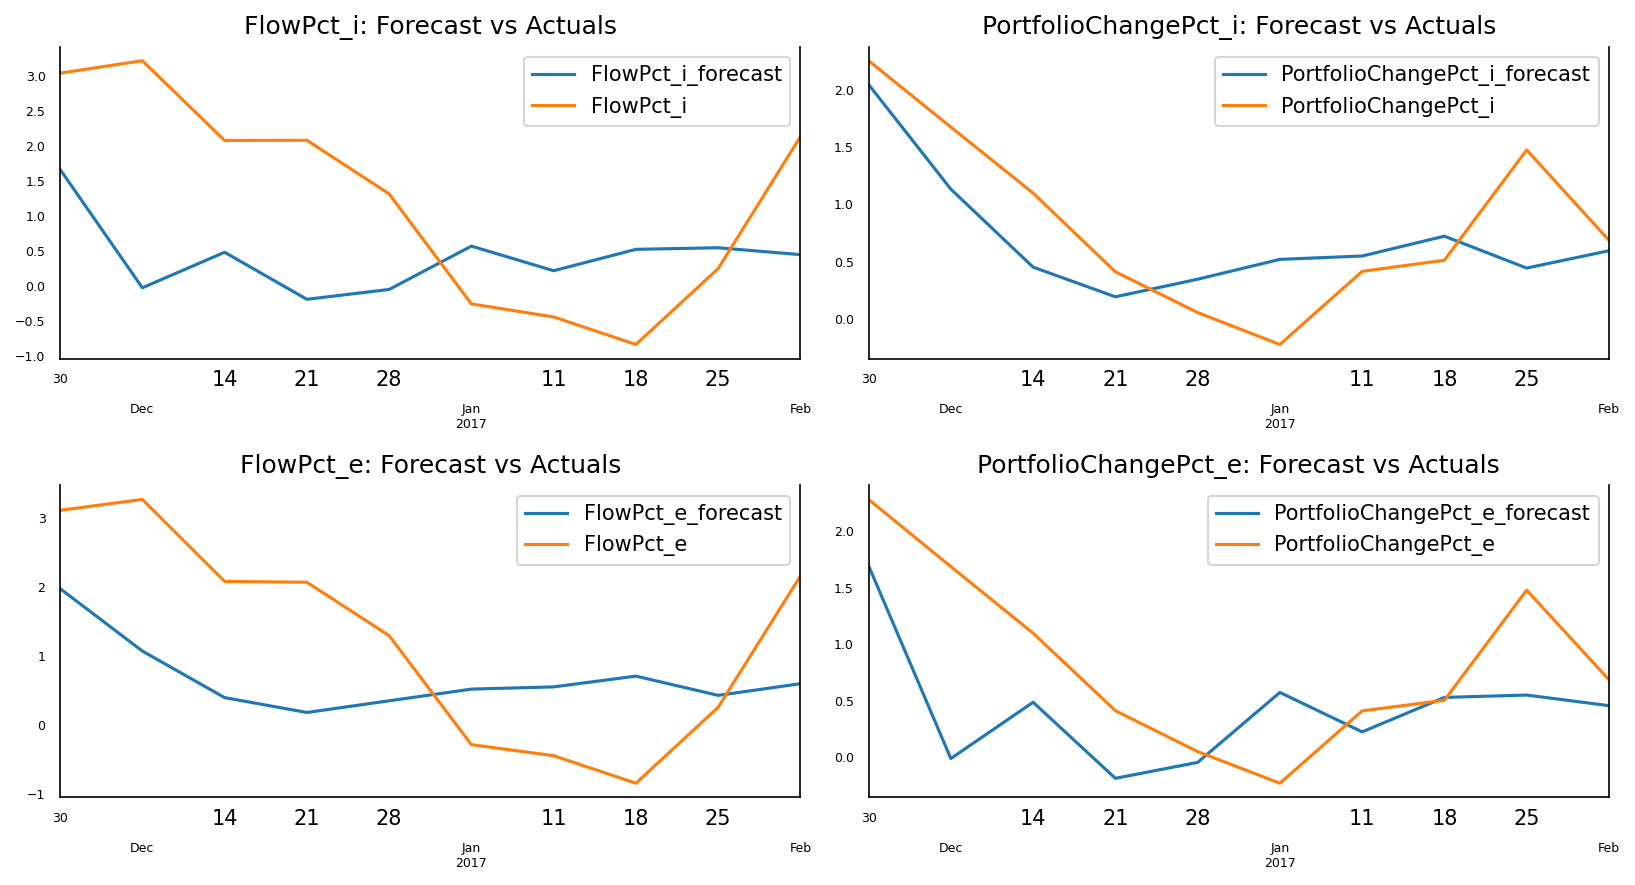

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    com[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  1.6712
corr :  0.096

Forecast Accuracy of: PortfolioPct_i
rmse :  0.508
corr :  0.7497

Forecast Accuracy of: FlowPct_e:
rmse :  1.4121
corr :  0.4487

Forecast Accuracy of: PortfolioPct_e
rmse :  0.7463
corr :  0.559


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    1   -1    1  ...            -1            -1            -1
2016-12-14   -1   -1   -1  ...            -1            -1             1
2016-12-21    0   -1    0  ...            -1            -1            -1
2016-12-28   -1   -1   -1  ...             1             1             1
2017-01-04   -1   -1   -1  ...             1             1             1
2017-01-11   -1    1   -1  ...             0             0            -1
2017-01-18   -1    0   -1  ...             1             1             1
2017-01-25    1    1    1  ...            -1            -1             0
2017-02-01    1   -1    1  ...             1             1             0

[10 rows x 8 columns]

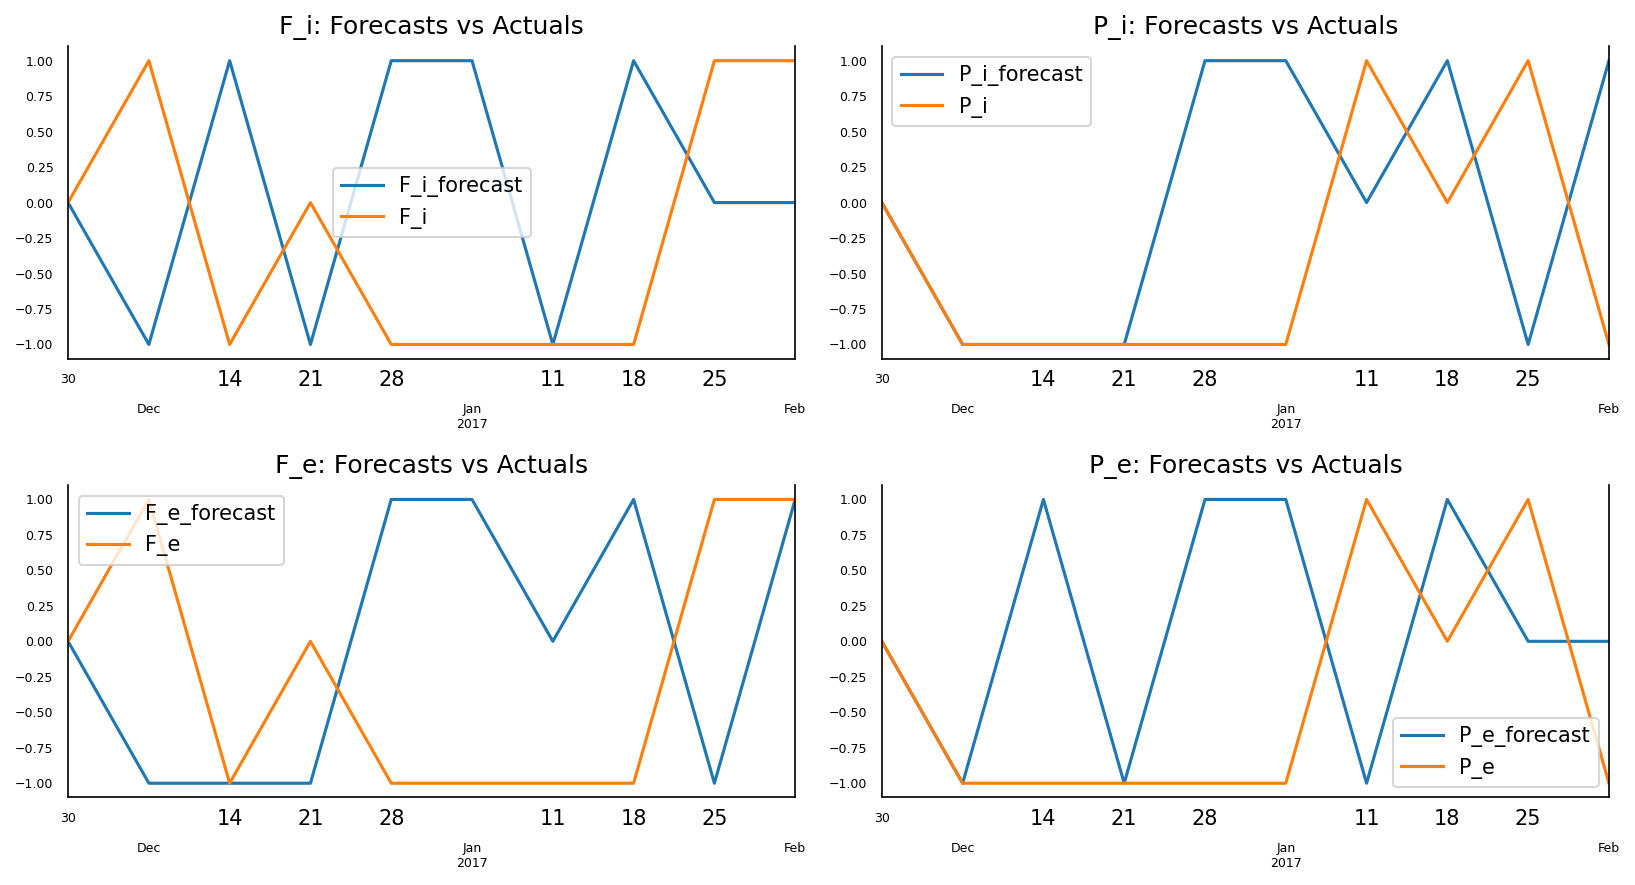

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.2
The accuracy score for PortfolioChangePct_i is 0.4
The accuracy score for FlowPct_e is 0.3
The accuracy score for PortfolioChangePct_e is 0.3


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             1   0   4
 0             1   1   0
 1             1   2   0, P_i_forecast  -1   0   1
P_i                     
-1             3   0   3
 0             0   1   1
 1             1   1   0, F_e_forecast  -1   0   1
F_e                     
-1             1   1   3
 0             1   1   0
 1             2   0   1, P_e_forecast  -1   0   1
P_e                     
-1             2   1   3
 0             0   1   1
 1             1   1   0]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.10928433235369697 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.2872974951836458 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.41740125124146876 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.5956747209679855 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.8
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.6
FlowPct_e v.s. FlowPct_e_forecast: 0.7
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.7


### con , Consumer

In [ ]:
con = add_index(con)
con.head()

FlowPct_i  PortfolioChangePct_i  ...  ClosePct_SP500  ClosePct_Dow
2006-01-25  -3.624925             -0.017550  ...       -0.004127     -0.148452
2006-02-01  -4.567325              0.077275  ...        0.185125      0.184134
2006-02-08  -3.964775             -0.589450  ...       -0.549332     -0.408638
2006-02-15  -3.248225              0.116950  ...        0.048025      0.479537
2006-02-22  -0.488650              0.450725  ...        0.554694      0.990544

[5 rows x 6 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(con, variables = con.columns)

FlowPct_i_x  ...  ClosePct_Dow_x
FlowPct_i_y                  1.0000  ...          0.0008
PortfolioChangePct_i_y       0.0021  ...          0.0777
FlowPct_e_y                  1.0000  ...          0.0008
PortfolioChangePct_e_y       0.0021  ...          0.0777
ClosePct_SP500_y             0.0020  ...          0.0763
ClosePct_Dow_y               0.0080  ...          1.0000

[6 rows x 6 columns]

In [ ]:
# adf
adf_test(con)

Statistics analysis of Inst MF FlowPct

Statistic Test: -5.768674266213458
p-value: 5.456629627423986e-07
 => P-Value = 5.456629627423986e-07. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.938529513150435
p-value: 2.9326775925693086e-05
 => P-Value = 2.9326775925693086e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -5.768674266213458
p-value: 5.456629627423986e-07
 => P-Value = 5.456629627423986e-07. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.938529513150435
p-value: 2.9326775925693086e-05
 => P-Value = 2.9326775925693086e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct1

Statistic Test: -4.525945134833848
p-value: 0.0001764687949003256
 => P-

In [ ]:
# split data
split(con, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
## Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
##
## If there is any correlation left in the residuals, then, 
## there is some pattern in the time series that is still left to be explained by the model. 
## In that case, the typical course of action is to either increase the order of the model 
## or induce more predictors into the system or look for a different algorithm to model the time series.
##
## The value of this statistic can vary between 0 and 4. The closer it is to the value 2, 
## then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, 
## and the closer it is to 4 implies negative serial correlation.

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(con.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.01
PortfolioChangePct_i : 2.02
FlowPct_e : 2.01
PortfolioChangePct_e : 2.02
ClosePct_SP500 : 2.02
ClosePct_Dow : 2.03


In [ ]:
forecasting(con)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

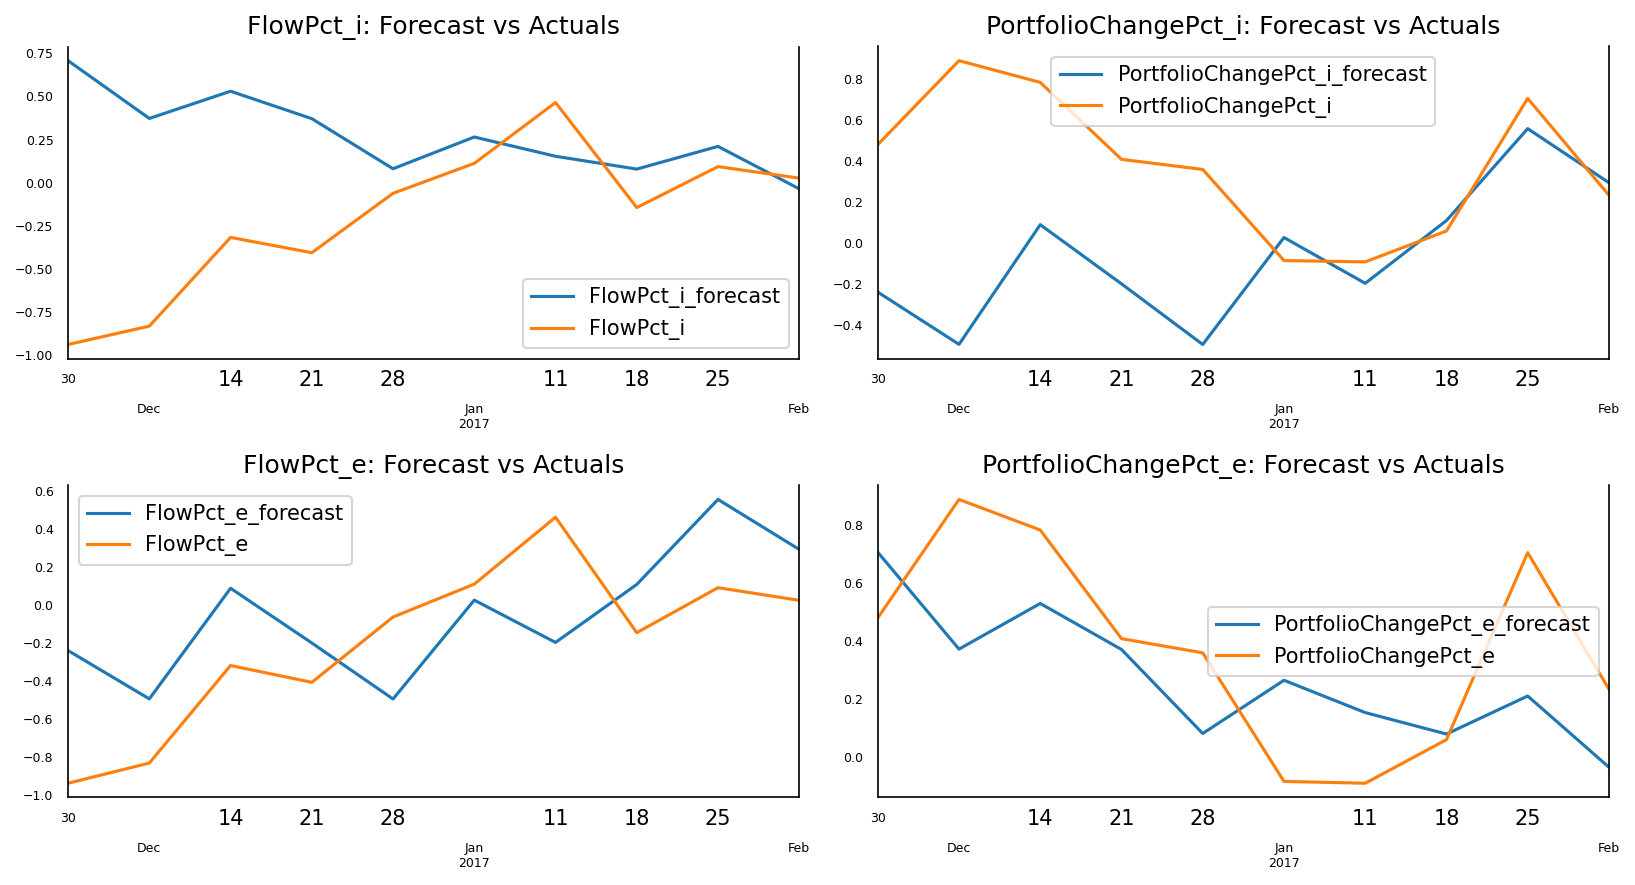

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    con[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.7531
corr :  -0.7239

Forecast Accuracy of: PortfolioPct_i
rmse :  0.6363
corr :  -0.0517

Forecast Accuracy of: FlowPct_e:
rmse :  0.4233
corr :  0.4305

Forecast Accuracy of: PortfolioPct_e
rmse :  0.3099
corr :  0.4933


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 10:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    1    1    1  ...            -1            -1            -1
2016-12-14    1   -1    1  ...             1             1             1
2016-12-21    0   -1    0  ...            -1            -1            -1
2016-12-28    1    0    1  ...            -1            -1            -1
2017-01-04    1   -1    1  ...             1             1             1
2017-01-11    1    0    1  ...            -1            -1            -1
2017-01-18   -1    1   -1  ...             1             1             0
2017-01-25    1    1    1  ...             1             1             1
2017-02-01    0   -1    0  ...            -1            -1            -1

[10 rows x 8 columns]

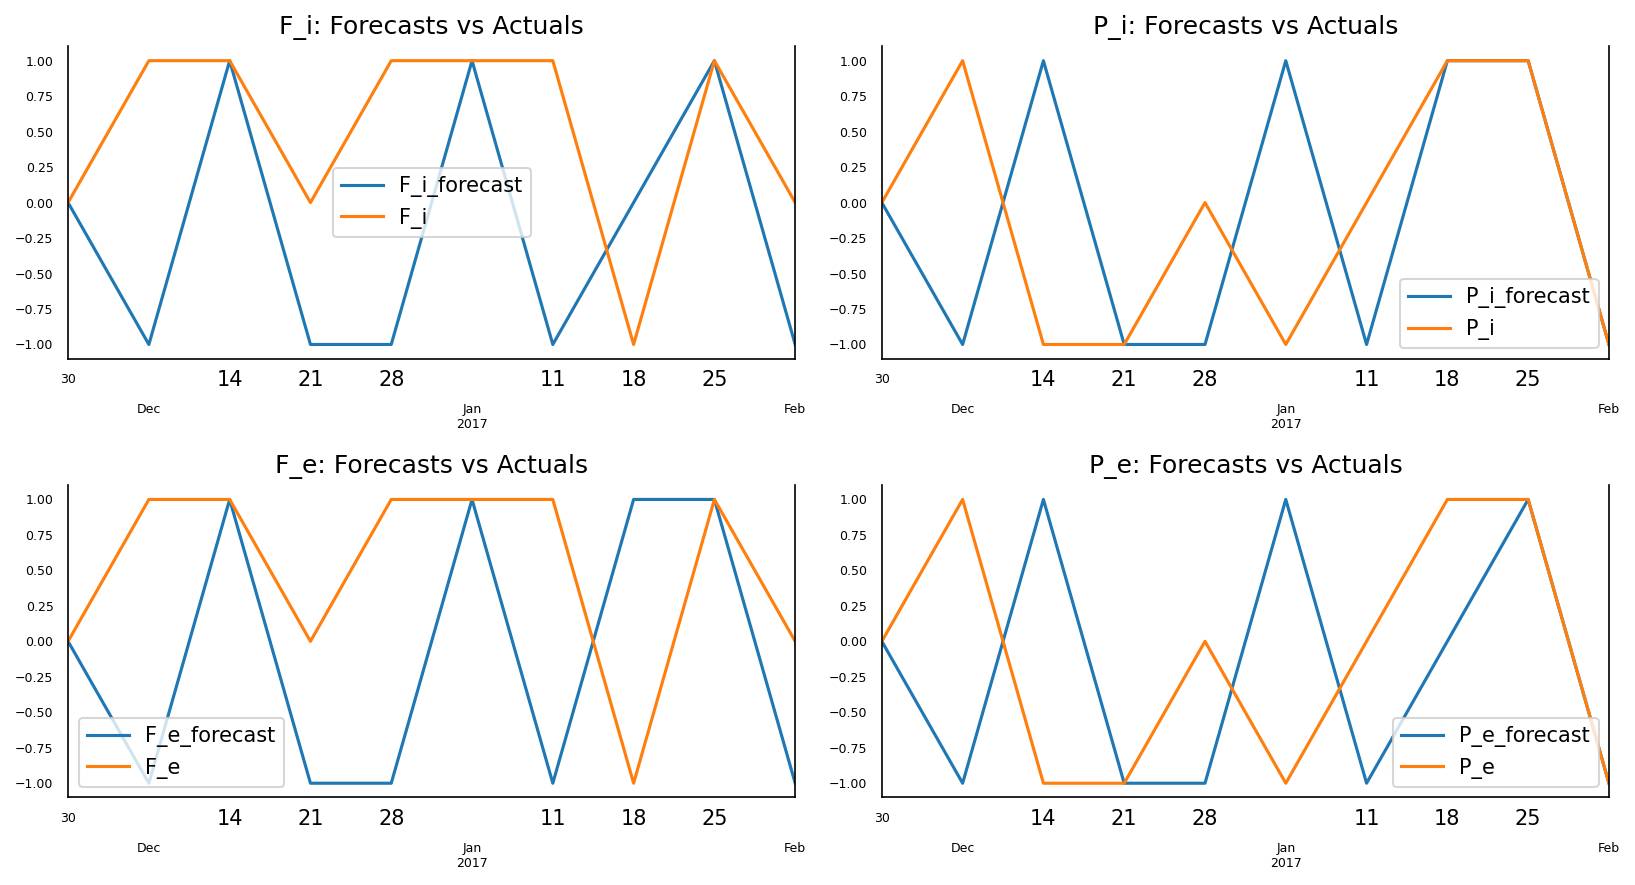

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.4
The accuracy score for PortfolioChangePct_i is 0.5
The accuracy score for FlowPct_e is 0.4
The accuracy score for PortfolioChangePct_e is 0.4


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             0   1   0
 0             2   1   0
 1             3   0   3, P_i_forecast  -1   0   1
P_i                     
-1             2   0   2
 0             2   1   0
 1             1   0   2, F_e_forecast  -1   0   1
F_e                     
-1             0   0   1
 0             2   1   0
 1             3   0   3, P_e_forecast  -1   0   1
P_e                     
-1             2   0   2
 0             2   1   0
 1             1   1   1]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.11928715496370125 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.34254747982605904 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.2625941192491615 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.5394064465772305 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.6
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.5
FlowPct_e v.s. FlowPct_e_forecast: 0.6
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.6


### ene, Energy

In [ ]:
# add index variable(s)
ene = add_index(ene)
ene.head()

FlowPct_i  PortfolioChangePct_i  ...  PortfolioChangePct_e  ClosePct_Dow
2006-01-25   2.147875              2.277500  ...              2.277375     -0.148452
2006-02-01   1.284375              1.603925  ...              1.603825      0.184134
2006-02-08   1.895750              0.036275  ...              0.036250     -0.408638
2006-02-15   1.808650             -1.322125  ...             -1.322025      0.479537
2006-02-22   5.597316             -0.928450  ...             -0.928300      0.990544

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(ene, variables = ene.columns)

FlowPct_i_x  ...  ClosePct_Dow_x
FlowPct_i_y                  1.0000  ...          0.1543
PortfolioChangePct_i_y       0.0003  ...          0.1237
FlowPct_e_y                  0.3085  ...          0.1189
PortfolioChangePct_e_y       0.0003  ...          0.1230
ClosePct_Dow_y               0.0044  ...          1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(ene)

Statistics analysis of Inst MF FlowPct

Statistic Test: -6.722933528919825
p-value: 3.4463989416239295e-09
 => P-Value = 3.4463989416239295e-09. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.855859776443213
p-value: 4.2471863930032684e-05
 => P-Value = 4.2471863930032684e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -6.753624593903027
p-value: 2.9087807828069974e-09
 => P-Value = 2.9087807828069974e-09. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.8845460371380405
p-value: 3.73721167422272e-05
 => P-Value = 3.73721167422272e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.94146678779208
p-value: 2.894065178440262e-05
 => P-V

In [ ]:
# split data
split(ene, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
## Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
##
## If there is any correlation left in the residuals, then, 
## there is some pattern in the time series that is still left to be explained by the model. 
## In that case, the typical course of action is to either increase the order of the model 
## or induce more predictors into the system or look for a different algorithm to model the time series.
##
## The value of this statistic can vary between 0 and 4. The closer it is to the value 2, 
## then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, 
## and the closer it is to 4 implies negative serial correlation.

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(ene.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.0
PortfolioChangePct_i : 2.01
FlowPct_e : 2.0
PortfolioChangePct_e : 2.01
ClosePct_Dow : 1.99


In [ ]:
forecasting(ene)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

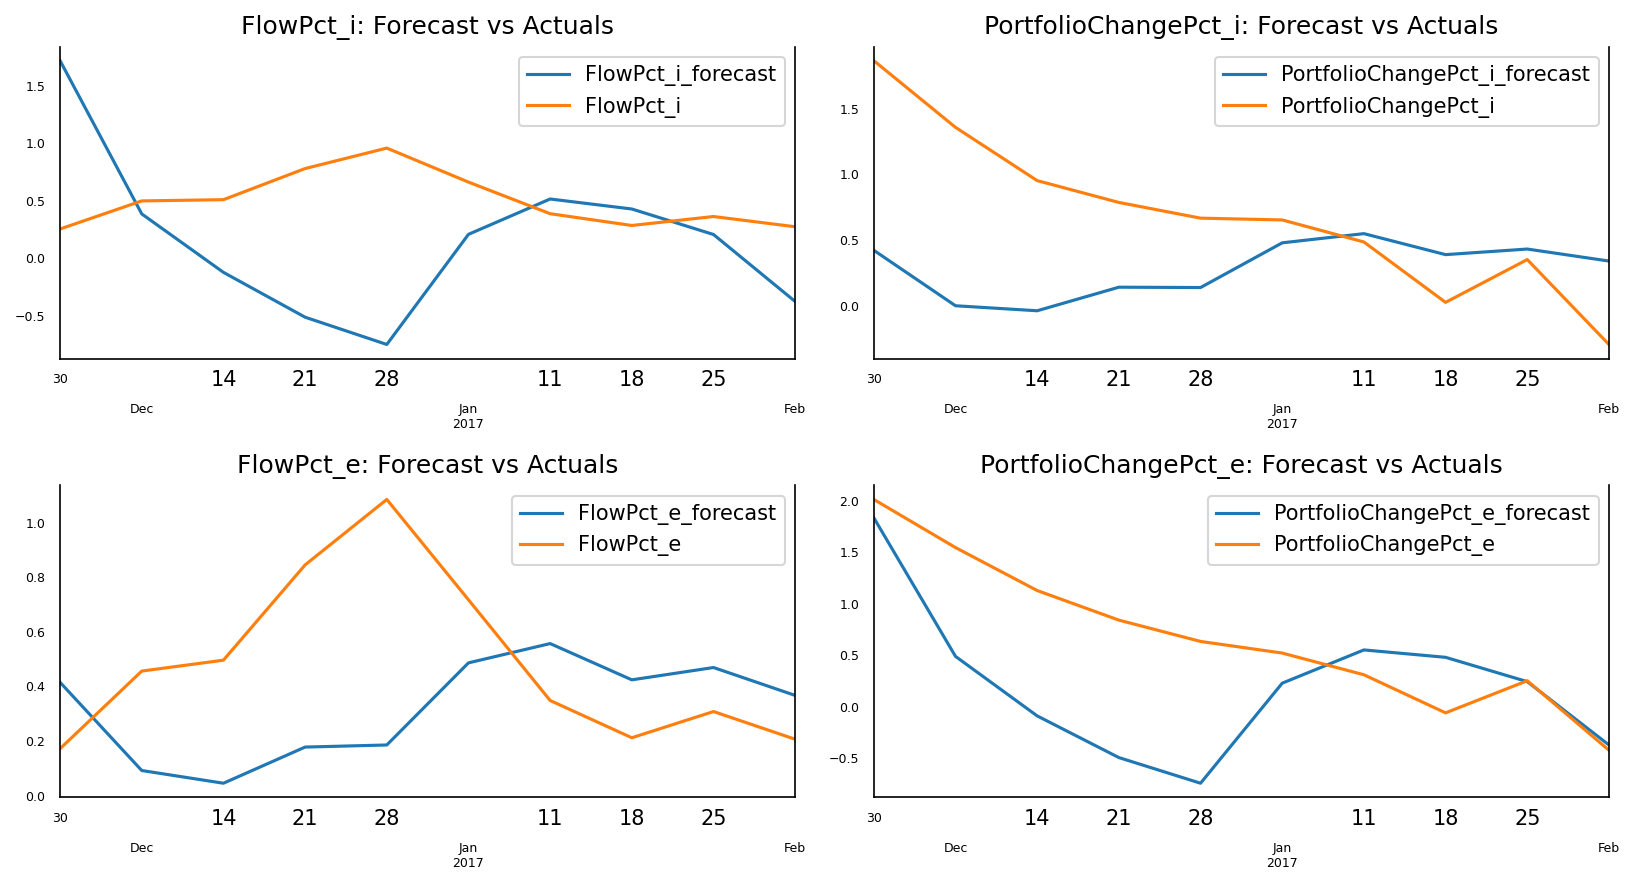

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    ene[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.8836
corr :  -0.6537

Forecast Accuracy of: PortfolioPct_i
rmse :  0.786
corr :  -0.3087

Forecast Accuracy of: FlowPct_e:
rmse :  0.4291
corr :  -0.4412

Forecast Accuracy of: PortfolioPct_e
rmse :  0.82
corr :  0.521


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    1   -1    1  ...            -1            -1            -1
2016-12-14    0   -1    0  ...             0             0            -1
2016-12-21    1   -1    1  ...             1             1            -1
2016-12-28    1   -1    1  ...             0             0            -1
2017-01-04   -1    0   -1  ...             1             1             1
2017-01-11   -1   -1   -1  ...             0             0             1
2017-01-18   -1   -1   -1  ...            -1            -1             0
2017-01-25    0    1    0  ...             0             0            -1
2017-02-01    0   -1   -1  ...             0            -1            -1

[10 rows x 8 columns]

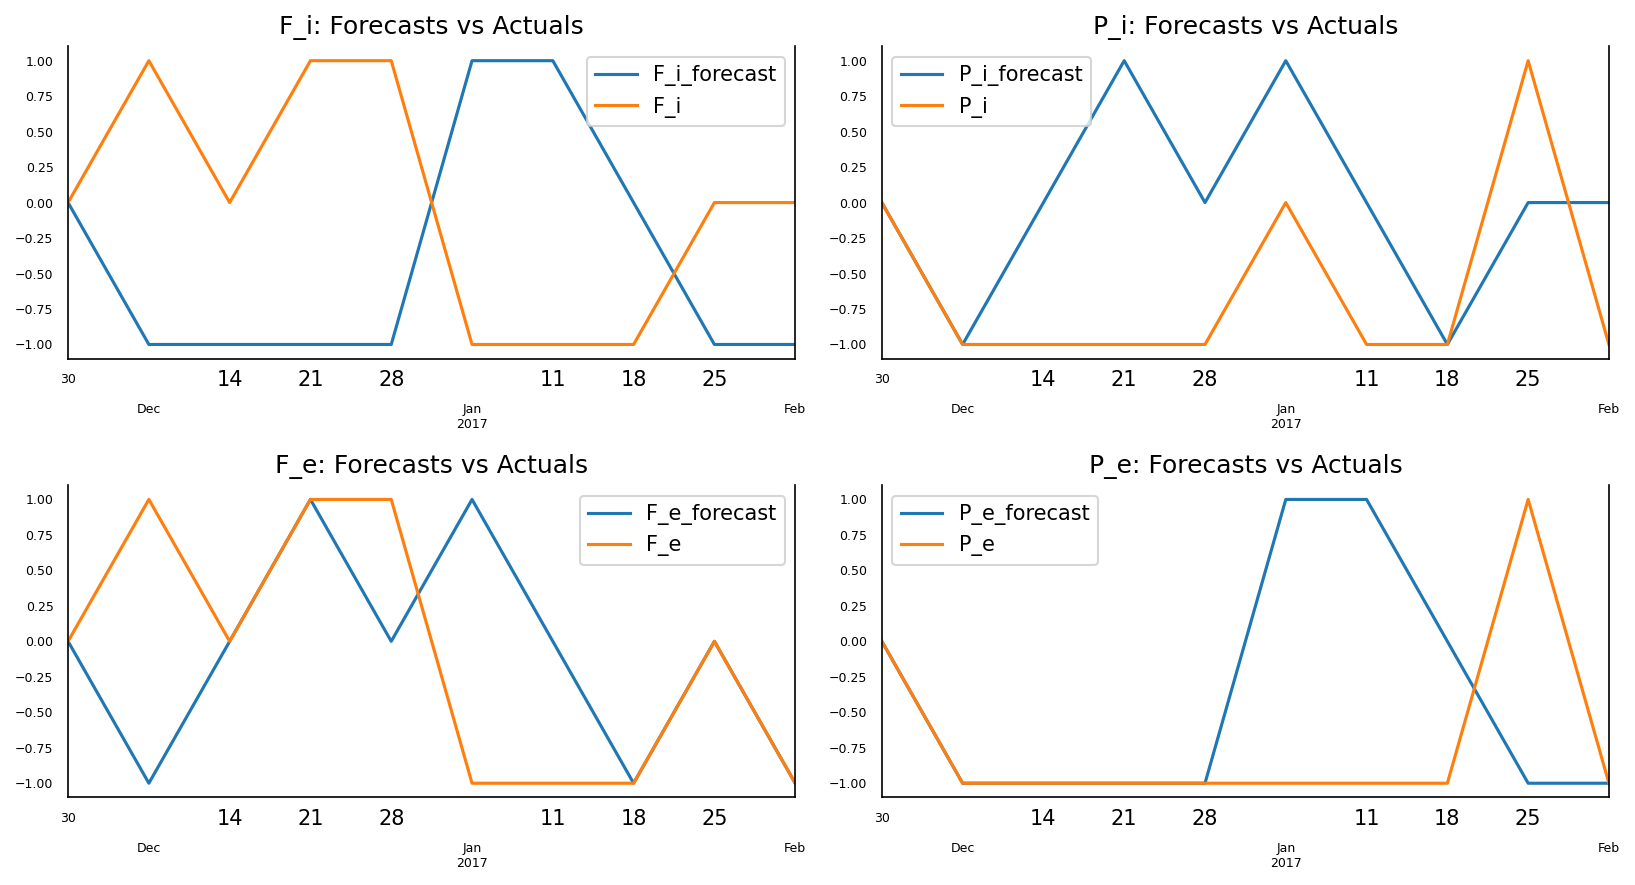

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.1
The accuracy score for PortfolioChangePct_i is 0.3
The accuracy score for FlowPct_e is 0.6
The accuracy score for PortfolioChangePct_e is 0.6


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             0   1   2
 0             3   1   0
 1             3   0   0, P_i_forecast  -1   0   1
P_i                     
-1             2   4   1
 0             0   1   1
 1             0   1   0, F_e_forecast  -1   0   1
F_e                     
-1             2   1   1
 0             0   3   0
 1             1   1   1, P_e_forecast  -1   0   1
P_e                     
-1             5   1   2
 0             0   1   0
 1             1   0   0]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.08010324359488151 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.6660721828143968 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.3392664494460721 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.2872974951836456 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.9
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.7
FlowPct_e v.s. FlowPct_e_forecast: 0.4
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.4


### fin, Financials 

In [ ]:
# add index variable(s)
fin = add_index(fin)
fin.head()

FlowPct_i  PortfolioChangePct_i  ...  ClosePct_SP500  ClosePct_Dow
2006-01-25   0.021075             -0.074800  ...       -0.004127     -0.148452
2006-02-01   0.021075              0.034075  ...        0.185125      0.184134
2006-02-08  -0.170525             -0.700425  ...       -0.549332     -0.408638
2006-02-15  -0.683550              0.270175  ...        0.048025      0.479537
2006-02-22   4.848537              1.020875  ...        0.554694      0.990544

[5 rows x 6 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(fin, variables = fin.columns)

FlowPct_i_x  ...  ClosePct_Dow_x
FlowPct_i_y                  1.0000  ...          0.0000
PortfolioChangePct_i_y       0.1145  ...          0.0549
FlowPct_e_y                  0.2862  ...          0.0000
PortfolioChangePct_e_y       0.1141  ...          0.0551
ClosePct_SP500_y             0.0134  ...          0.0763
ClosePct_Dow_y               0.0156  ...          1.0000

[6 rows x 6 columns]

In [ ]:
# adf
adf_test(fin)

Statistics analysis of Inst MF FlowPct

Statistic Test: -5.325026388801271
p-value: 4.858523710130592e-06
 => P-Value = 4.858523710130592e-06. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.561913062415729
p-value: 0.00015174014135516285
 => P-Value = 0.00015174014135516285. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -5.323538624988819
p-value: 4.893241667385995e-06
 => P-Value = 4.893241667385995e-06. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.564829697686128
p-value: 0.0001498866905002826
 => P-Value = 0.0001498866905002826. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct1

Statistic Test: -4.525945134833848
p-value: 0.0001764687949003256
 => P-Va

In [ ]:
# split data
split(fin, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
## Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
##
## If there is any correlation left in the residuals, then, 
## there is some pattern in the time series that is still left to be explained by the model. 
## In that case, the typical course of action is to either increase the order of the model 
## or induce more predictors into the system or look for a different algorithm to model the time series.
##
## The value of this statistic can vary between 0 and 4. The closer it is to the value 2, 
## then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, 
## and the closer it is to 4 implies negative serial correlation.

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(fin.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.0
PortfolioChangePct_i : 2.02
FlowPct_e : 2.0
PortfolioChangePct_e : 2.02
ClosePct_SP500 : 2.01
ClosePct_Dow : 2.02


In [ ]:
forecasting(fin)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

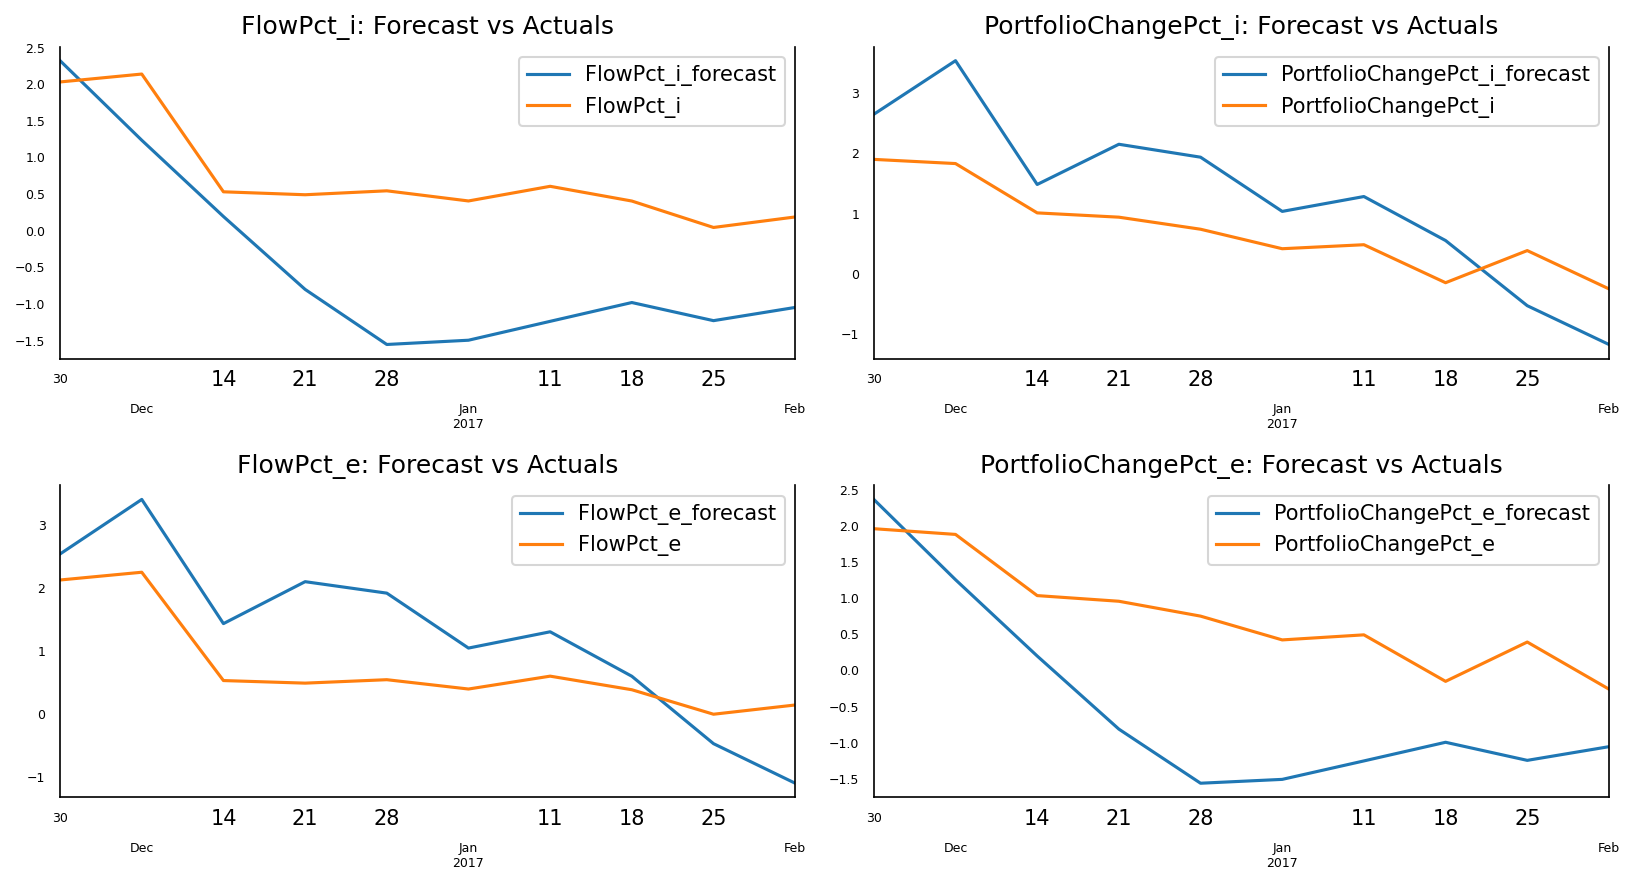

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    fin[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  1.384
corr :  0.8898

Forecast Accuracy of: PortfolioPct_i
rmse :  0.9871
corr :  0.8748

Forecast Accuracy of: FlowPct_e:
rmse :  0.9745
corr :  0.8012

Forecast Accuracy of: PortfolioPct_e
rmse :  1.4355
corr :  0.834


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 10:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    1    0    1  ...             1             1            -1
2016-12-14   -1   -1   -1  ...            -1            -1            -1
2016-12-21    0    0    0  ...             1             1            -1
2016-12-28    0   -1    0  ...            -1            -1            -1
2017-01-04   -1   -1   -1  ...            -1            -1             0
2017-01-11    1    0    1  ...             1             1             1
2017-01-18   -1   -1   -1  ...            -1            -1             1
2017-01-25   -1    1   -1  ...            -1            -1            -1
2017-02-01    1   -1    1  ...            -1            -1             1

[10 rows x 8 columns]

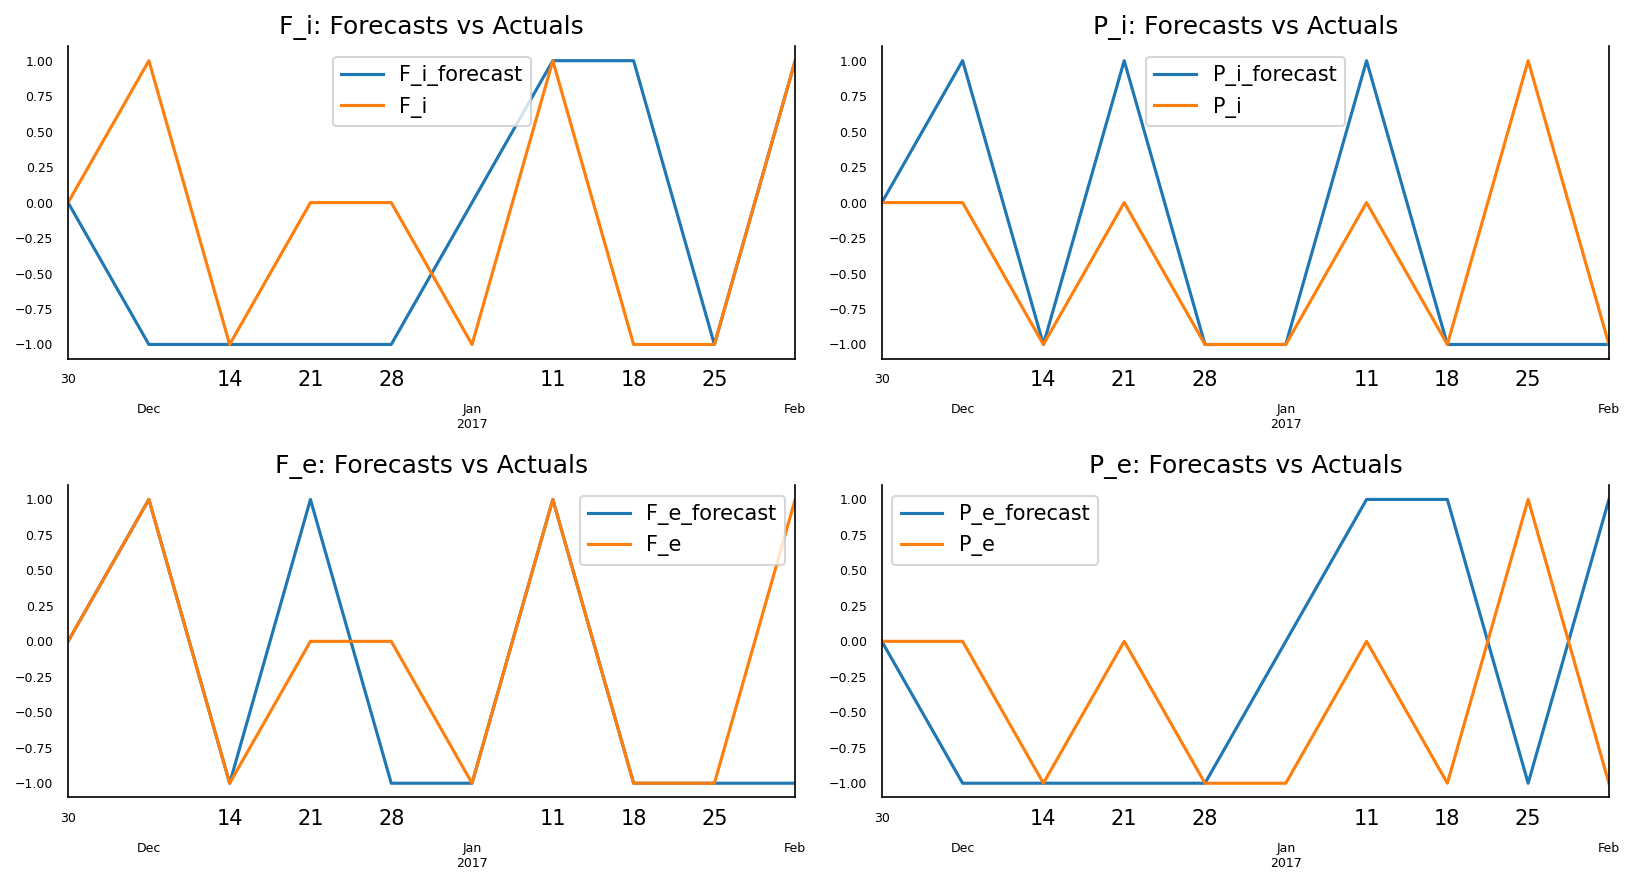

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.5
The accuracy score for PortfolioChangePct_i is 0.6
The accuracy score for FlowPct_e is 0.7
The accuracy score for PortfolioChangePct_e is 0.3


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             2   1   1
 0             2   1   0
 1             1   0   2, P_i_forecast  -1   0   1
P_i                     
-1             5   0   0
 0             0   1   3
 1             1   0   0, F_e_forecast  -1   0   1
F_e                     
-1             4   0   0
 0             1   1   1
 1             1   0   2, P_e_forecast  -1   0   1
P_e                     
-1             2   1   2
 0             2   1   1
 1             1   0   0]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.47366726176890683 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.04042768199451279 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.15458730450476033 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.8528370045176448 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.5
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.4
FlowPct_e v.s. FlowPct_e_forecast: 0.3
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.7


### hea, Health

In [ ]:
# add index variable(s)
hea = add_index(hea)
hea.head()

FlowPct_i  ...  ClosePct_SP500
2006-01-25   1.539600  ...       -0.004127
2006-02-01   1.562225  ...        0.185125
2006-02-08  -0.120743  ...       -0.549332
2006-02-15  -1.257318  ...        0.048025
2006-02-22  -0.988043  ...        0.554694

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(hea, variables = hea.columns)

FlowPct_i_x  ...  ClosePct_SP500_x
FlowPct_i_y                  1.0000  ...            0.0000
PortfolioChangePct_i_y       0.0001  ...            0.1070
FlowPct_e_y                  0.0052  ...            0.0000
PortfolioChangePct_e_y       0.0001  ...            0.1042
ClosePct_SP500_y             0.0075  ...            1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(hea)

Statistics analysis of Inst MF FlowPct

Statistic Test: -5.668266345168308
p-value: 9.04576948598749e-07
 => P-Value = 9.04576948598749e-07. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -5.58384761589116
p-value: 1.377160923505237e-06
 => P-Value = 1.377160923505237e-06. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -5.737100043841647
p-value: 6.40076544347246e-07
 => P-Value = 6.40076544347246e-07. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -5.574809524033905
p-value: 1.4401764389539423e-06
 => P-Value = 1.4401764389539423e-06. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.525945134833848
p-value: 0.0001764687949003256
 => P-Value = 

In [ ]:
# split data
split(hea, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
## Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
##
## If there is any correlation left in the residuals, then, 
## there is some pattern in the time series that is still left to be explained by the model. 
## In that case, the typical course of action is to either increase the order of the model 
## or induce more predictors into the system or look for a different algorithm to model the time series.
##
## The value of this statistic can vary between 0 and 4. The closer it is to the value 2, 
## then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, 
## and the closer it is to 4 implies negative serial correlation.

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(hea.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.0
PortfolioChangePct_i : 2.01
FlowPct_e : 2.0
PortfolioChangePct_e : 2.01
ClosePct_SP500 : 2.0


In [ ]:
forecasting(hea)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

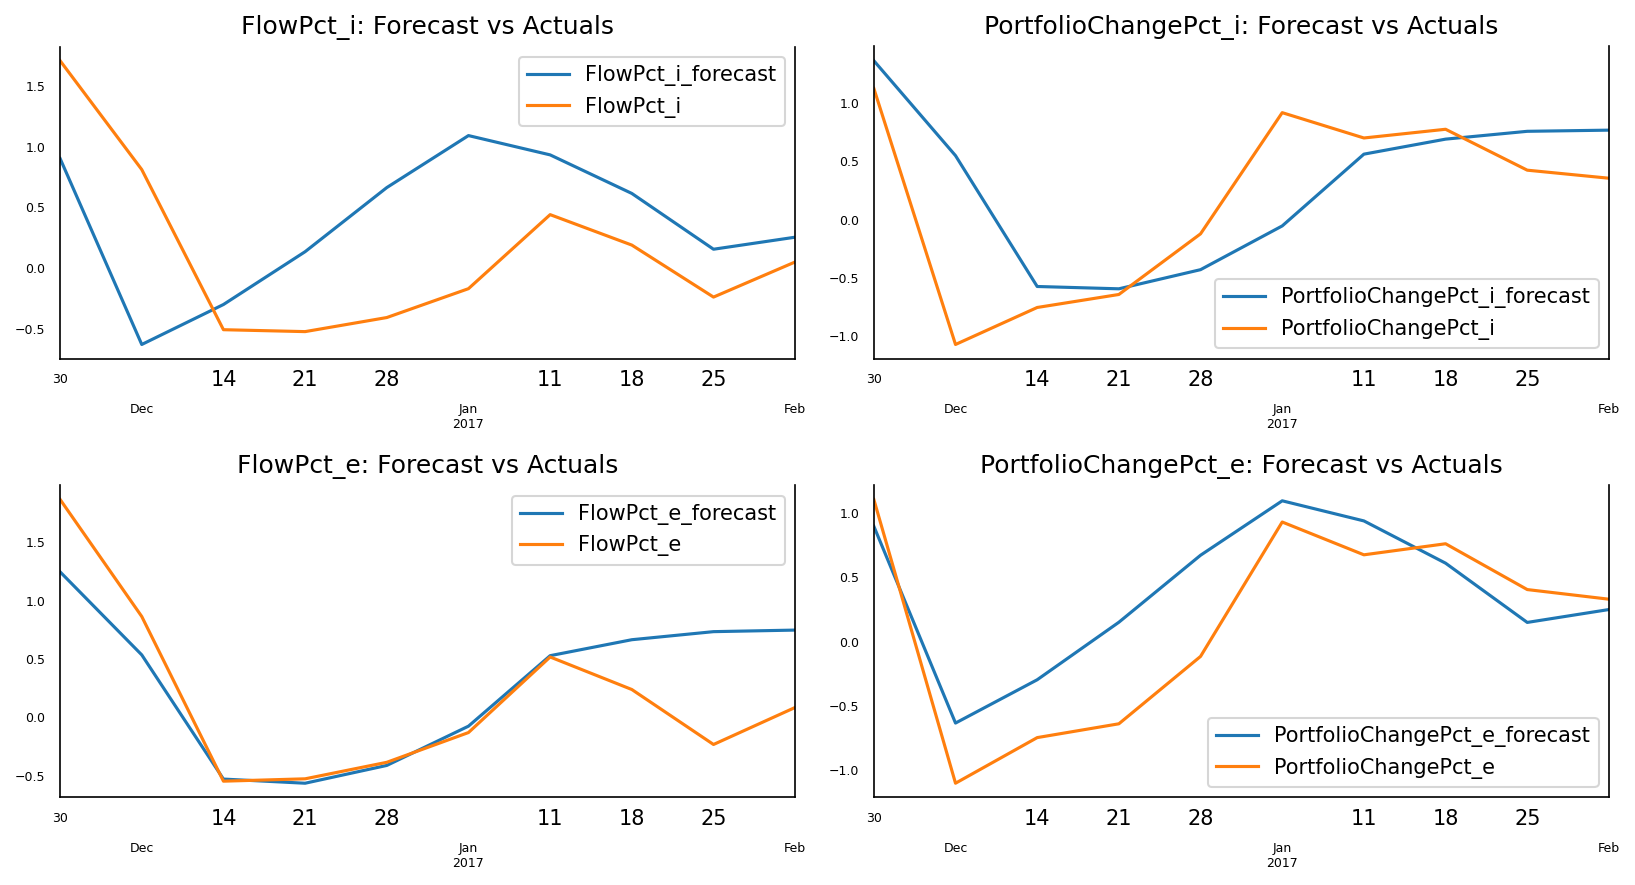

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    hea[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.8075
corr :  0.1824

Forecast Accuracy of: PortfolioPct_i
rmse :  0.6382
corr :  0.5931

Forecast Accuracy of: FlowPct_e:
rmse :  0.4528
corr :  0.7885

Forecast Accuracy of: PortfolioPct_e
rmse :  0.435
corr :  0.8698


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07   -1   -1   -1  ...            -1            -1            -1
2016-12-14   -1    1   -1  ...            -1            -1             1
2016-12-21    0    1    0  ...             0             0             1
2016-12-28    1    1    1  ...             1             1             1
2017-01-04    1    1    1  ...             1             1             1
2017-01-11    1   -1    1  ...             1             1            -1
2017-01-18   -1    0   -1  ...             1             1            -1
2017-01-25   -1   -1   -1  ...             0             0            -1
2017-02-01    1    0    1  ...             0             0             1

[10 rows x 8 columns]

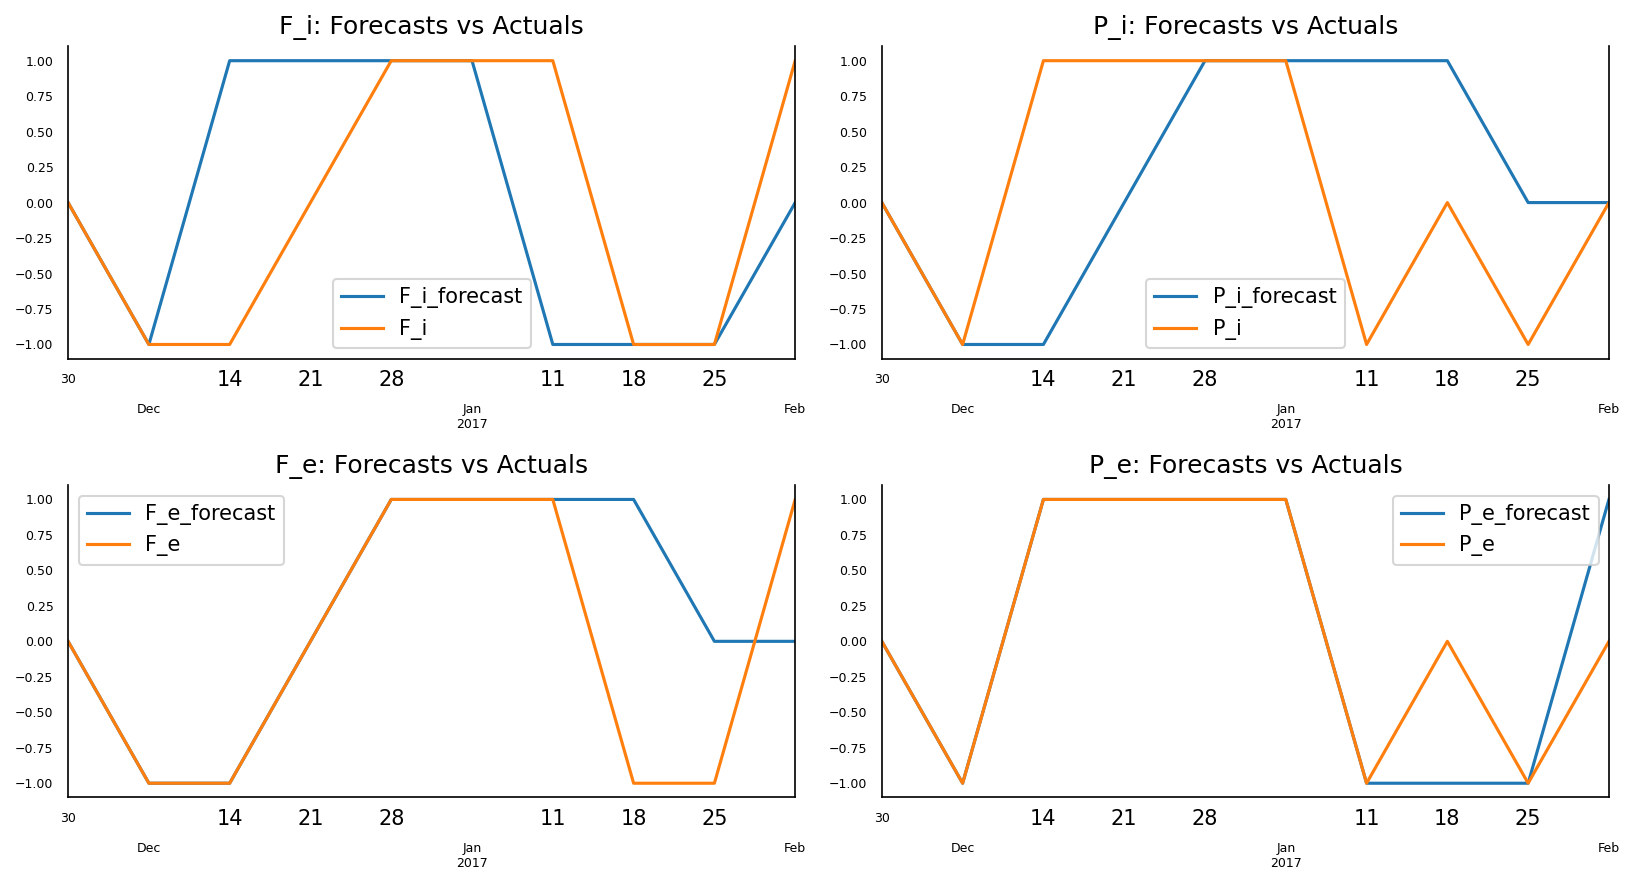

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.6
The accuracy score for PortfolioChangePct_i is 0.5
The accuracy score for FlowPct_e is 0.7
The accuracy score for PortfolioChangePct_e is 0.8


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             3   0   1
 0             0   1   1
 1             1   1   2, P_i_forecast  -1   0   1
P_i                     
-1             1   1   1
 0             0   2   1
 1             1   1   2, F_e_forecast  -1   0   1
F_e                     
-1             2   1   1
 0             0   2   0
 1             0   1   3, P_e_forecast  -1   0   1
P_e                     
-1             3   0   0
 0             1   1   1
 1             0   0   4]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.3576275885335956 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.758735901686298 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.11170929281604328 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.03517188548771231 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.4
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.5
FlowPct_e v.s. FlowPct_e_forecast: 0.3
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.2


### Ind, Industrials

In [ ]:
# add index variable(s)
ind = add_index(ind)
ind.head()

FlowPct_i  ...  ClosePct_SP500
2006-01-25  -0.575200  ...       -0.004127
2006-02-01  -1.196375  ...        0.185125
2006-02-08  -1.510100  ...       -0.549332
2006-02-15  -1.510100  ...        0.048025
2006-02-22  -0.313725  ...        0.554694

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(ind, variables = ind.columns)

FlowPct_i_x  ...  ClosePct_SP500_x
FlowPct_i_y                  1.0000  ...            0.0918
PortfolioChangePct_i_y       0.0309  ...            0.0151
FlowPct_e_y                  1.0000  ...            0.0918
PortfolioChangePct_e_y       0.0309  ...            0.0151
ClosePct_SP500_y             0.0156  ...            1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(ind)

Statistics analysis of Inst MF FlowPct

Statistic Test: -6.201500588603013
p-value: 5.7923506079930063e-08
 => P-Value = 5.7923506079930063e-08. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.649243842639959
p-value: 0.00010470404397544144
 => P-Value = 0.00010470404397544144. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -6.201500588603013
p-value: 5.7923506079930063e-08
 => P-Value = 5.7923506079930063e-08. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.649243842639959
p-value: 0.00010470404397544144
 => P-Value = 0.00010470404397544144. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.525945134833848
p-value: 0.0001764687949003256
 =>

In [ ]:
# split data
split(ind, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
## Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
##
## If there is any correlation left in the residuals, then, 
## there is some pattern in the time series that is still left to be explained by the model. 
## In that case, the typical course of action is to either increase the order of the model 
## or induce more predictors into the system or look for a different algorithm to model the time series.
##
## The value of this statistic can vary between 0 and 4. The closer it is to the value 2, 
## then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, 
## and the closer it is to 4 implies negative serial correlation.

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(ind.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.01
PortfolioChangePct_i : 2.0
FlowPct_e : 2.01
PortfolioChangePct_e : 2.0
ClosePct_SP500 : 2.0


In [ ]:
forecasting(ind)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

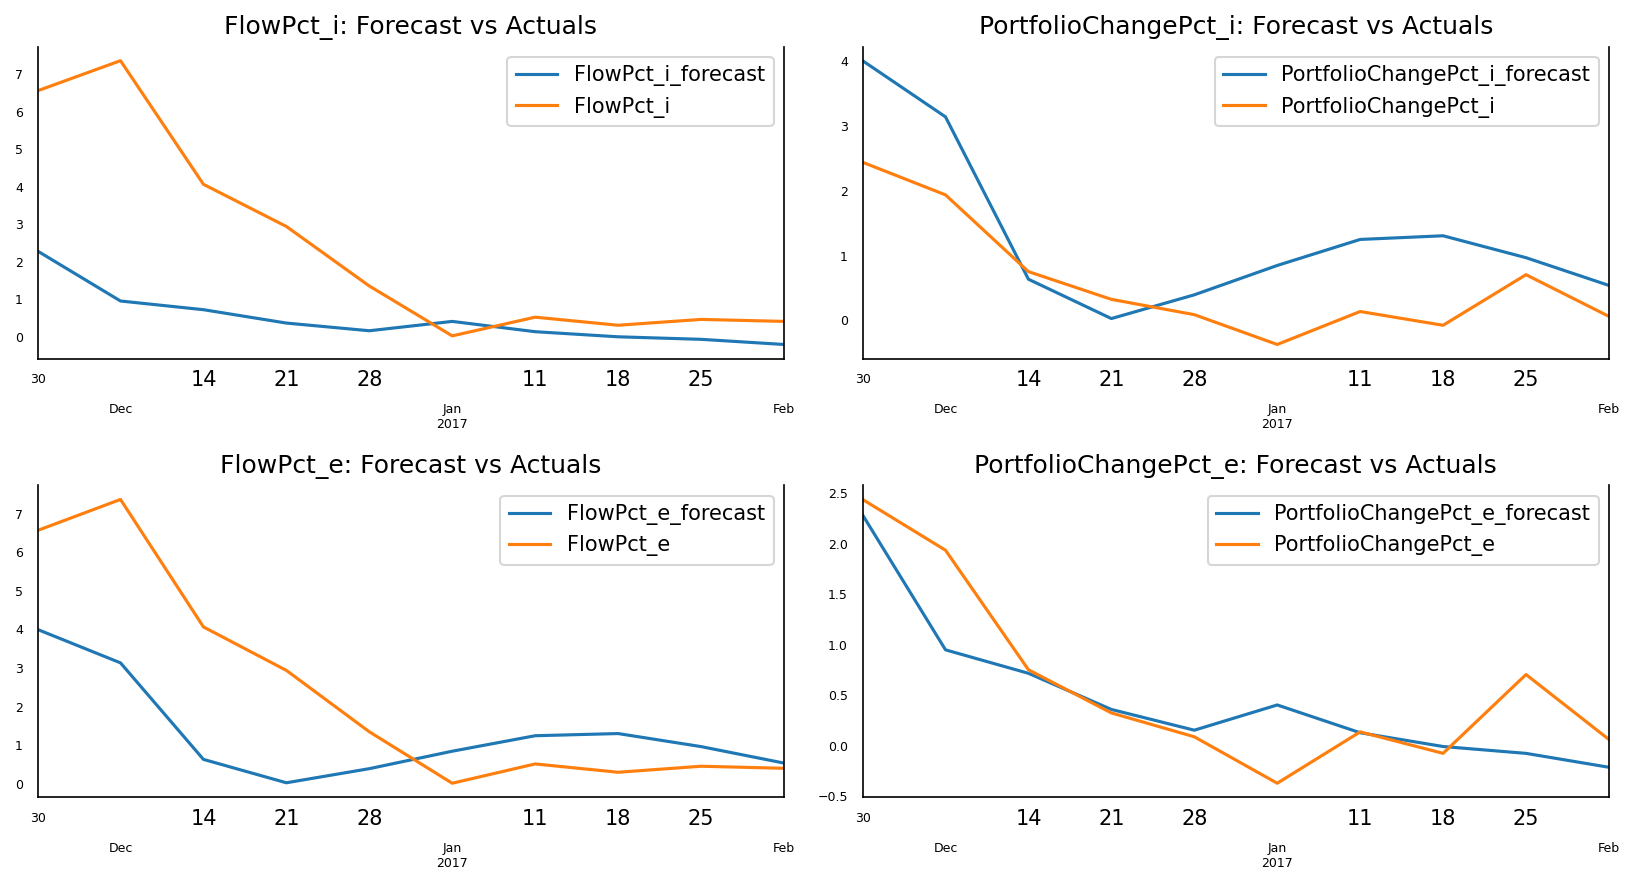

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    ind[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  2.8255
corr :  0.8236

Forecast Accuracy of: PortfolioPct_i
rmse :  0.9479
corr :  0.865

Forecast Accuracy of: FlowPct_e:
rmse :  2.1936
corr :  0.7318

Forecast Accuracy of: PortfolioPct_e
rmse :  0.478
corr :  0.8462


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    1   -1    1  ...            -1            -1            -1
2016-12-14   -1   -1   -1  ...            -1            -1            -1
2016-12-21   -1   -1   -1  ...            -1            -1            -1
2016-12-28   -1   -1   -1  ...             1             1            -1
2017-01-04   -1   -1   -1  ...             1             1             1
2017-01-11    1    1    1  ...             1             1            -1
2017-01-18   -1   -1   -1  ...             0             0            -1
2017-01-25    1    1    1  ...            -1            -1             0
2017-02-01    0   -1    0  ...            -1            -1            -1

[10 rows x 8 columns]

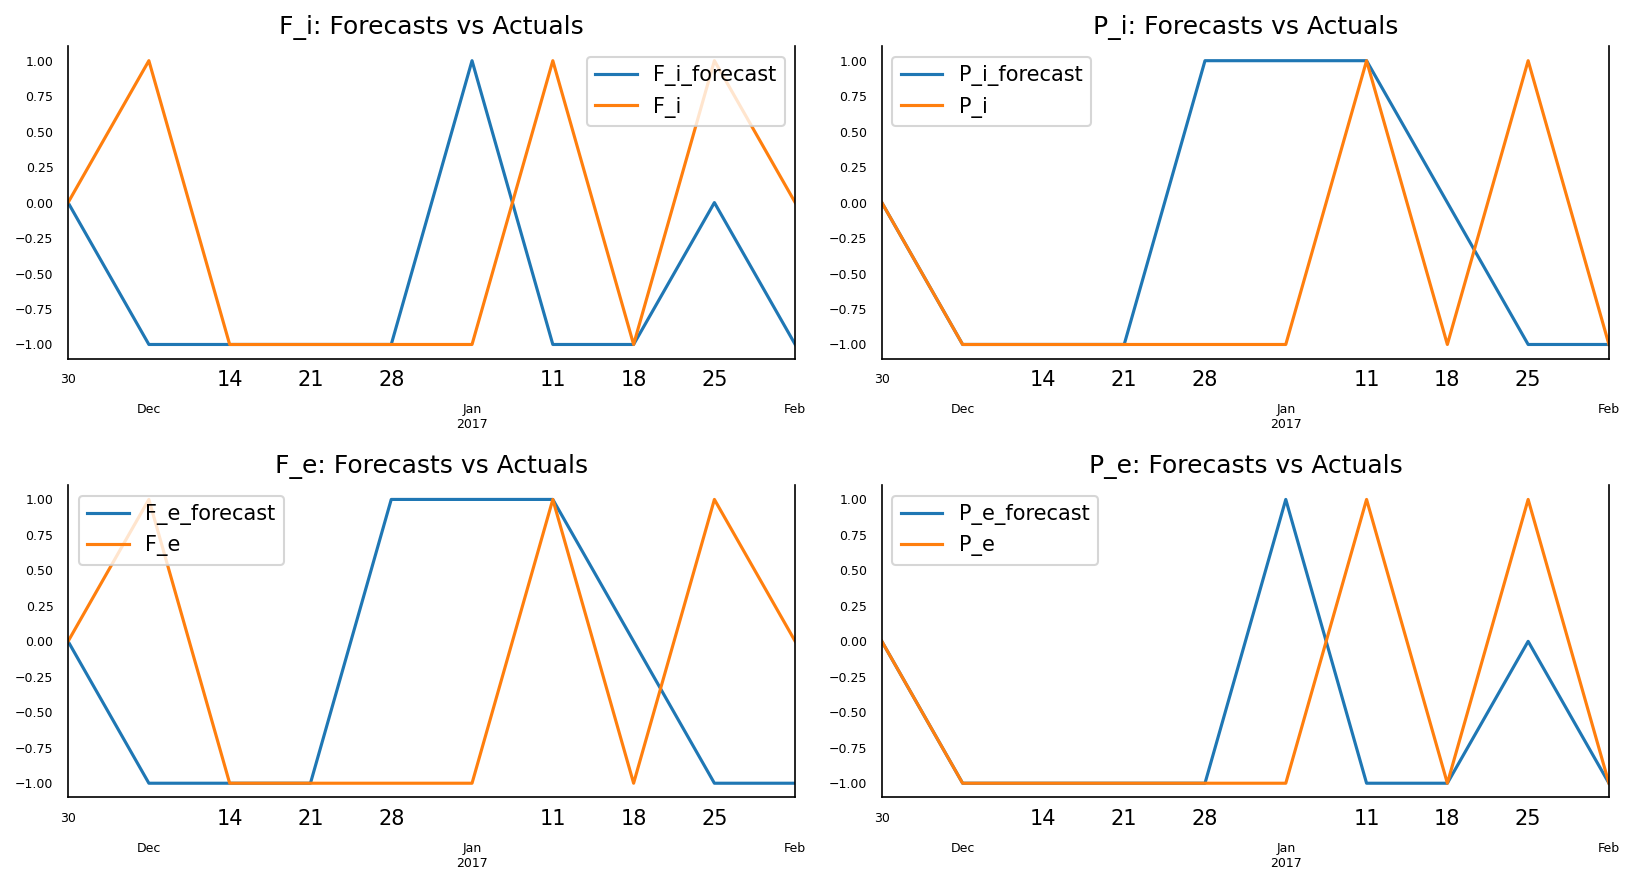

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.5
The accuracy score for PortfolioChangePct_i is 0.6
The accuracy score for FlowPct_e is 0.4
The accuracy score for PortfolioChangePct_e is 0.7


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             4   0   1
 0             1   1   0
 1             2   1   0, P_i_forecast  -1   0   1
P_i                     
-1             4   1   2
 0             0   1   0
 1             1   0   1, F_e_forecast  -1   0   1
F_e                     
-1             2   1   2
 0             1   1   0
 1             2   0   1, P_e_forecast  -1   0   1
P_e                     
-1             6   0   1
 0             0   1   0
 1             1   1   0]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.4999296826198095 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.30227207781379684 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.6366953997887801 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.13642844797150824 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.5
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.4
FlowPct_e v.s. FlowPct_e_forecast: 0.6
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.3


### lcb, Large Capital Blend

In [ ]:
# add index variable(s)
lcb = add_index(lcb)
lcb.head()

FlowPct_i  ...  ClosePct_SP500
2006-01-25   0.293650  ...       -0.004127
2006-02-01   0.125025  ...        0.185125
2006-02-08   0.185100  ...       -0.549332
2006-02-15   0.162575  ...        0.048025
2006-02-22   0.422650  ...        0.554694

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(lcb, variables = lcb.columns)

FlowPct_i_x  ...  ClosePct_SP500_x
FlowPct_i_y                  1.0000  ...            0.0168
PortfolioChangePct_i_y       0.0007  ...            0.1625
FlowPct_e_y                  0.0036  ...            0.0234
PortfolioChangePct_e_y       0.0006  ...            0.0843
ClosePct_SP500_y             0.0005  ...            1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(lcb)

Statistics analysis of Inst MF FlowPct

Statistic Test: -4.493746524725488
p-value: 0.0002018198624937733
 => P-Value = 0.0002018198624937733. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.54633406467708
p-value: 0.00016201594369101636
 => P-Value = 0.00016201594369101636. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -4.401399298509173
p-value: 0.0002951446128524623
 => P-Value = 0.0002951446128524623. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.529417367626496
p-value: 0.00017392369555697536
 => P-Value = 0.00017392369555697536. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.525945134833848
p-value: 0.0001764687949003256
 => P-Va

In [ ]:
# split data
split(lcb, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(lcb.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.04
PortfolioChangePct_i : 2.0
FlowPct_e : 2.04
PortfolioChangePct_e : 2.0
ClosePct_SP500 : 2.0


In [ ]:
forecasting(lcb)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

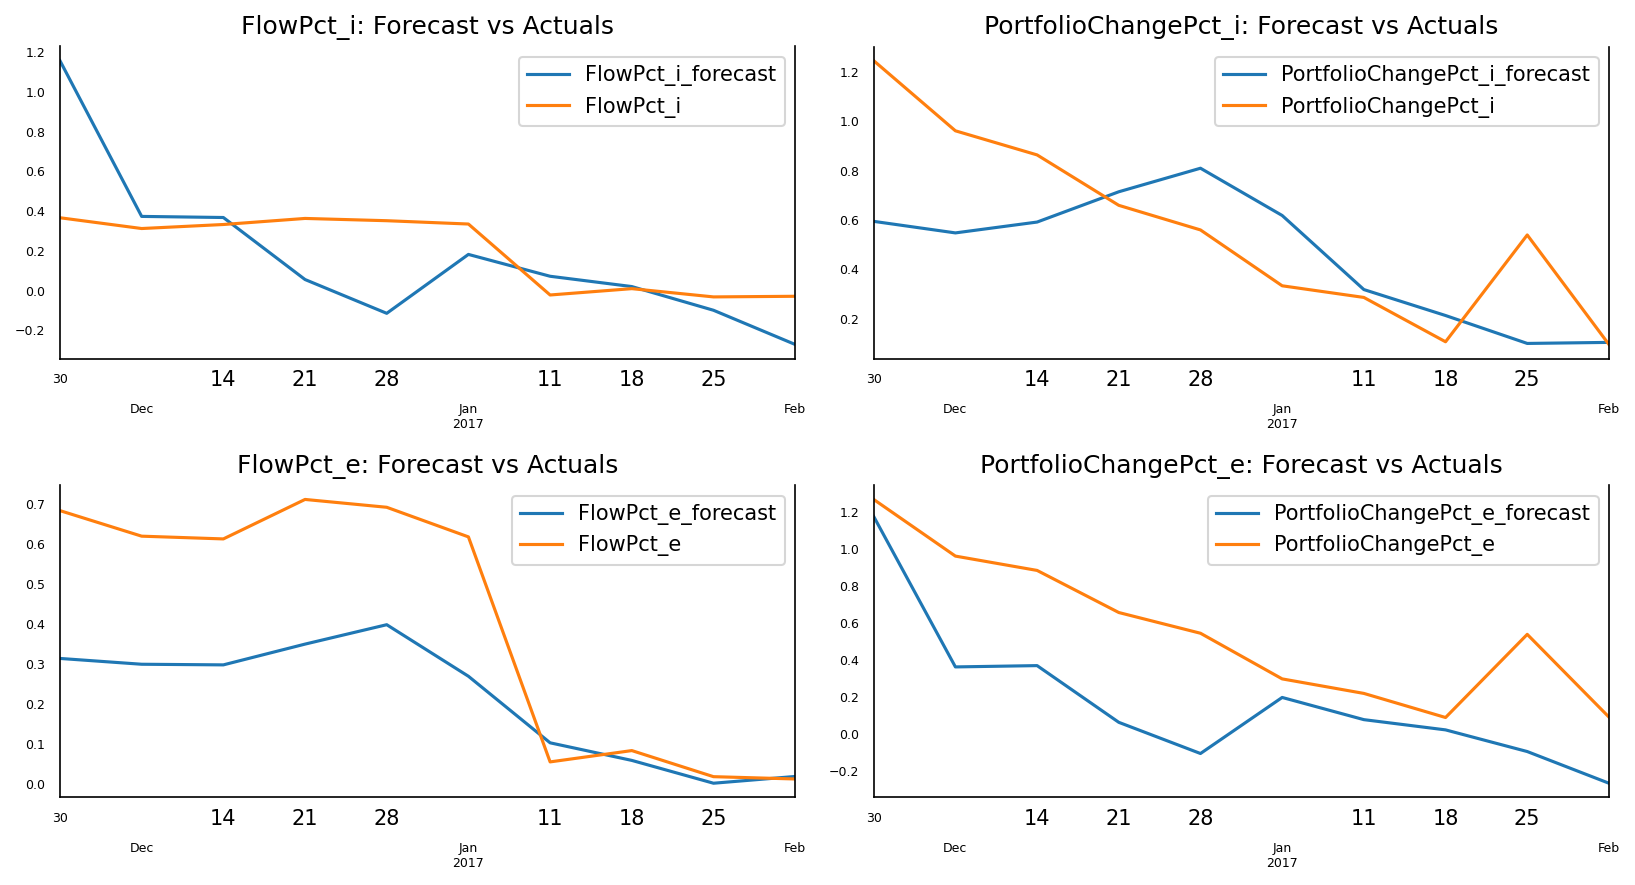

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    lcb[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.322
corr :  0.5413

Forecast Accuracy of: PortfolioPct_i
rmse :  0.3192
corr :  0.5511

Forecast Accuracy of: FlowPct_e:
rmse :  0.2604
corr :  0.9764

Forecast Accuracy of: PortfolioPct_e
rmse :  0.4456
corr :  0.8033


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    0   -1    0  ...             0             0            -1
2016-12-14    0    0    0  ...             0             0             0
2016-12-21    0   -1    0  ...             1             0            -1
2016-12-28    0    0    0  ...             0             0            -1
2017-01-04    0   -1    0  ...            -1            -1             1
2017-01-11   -1    0   -1  ...            -1            -1            -1
2017-01-18    0   -1    0  ...            -1             0             0
2017-01-25    0    1    0  ...            -1             0            -1
2017-02-01    0   -1    0  ...             0             0            -1

[10 rows x 8 columns]

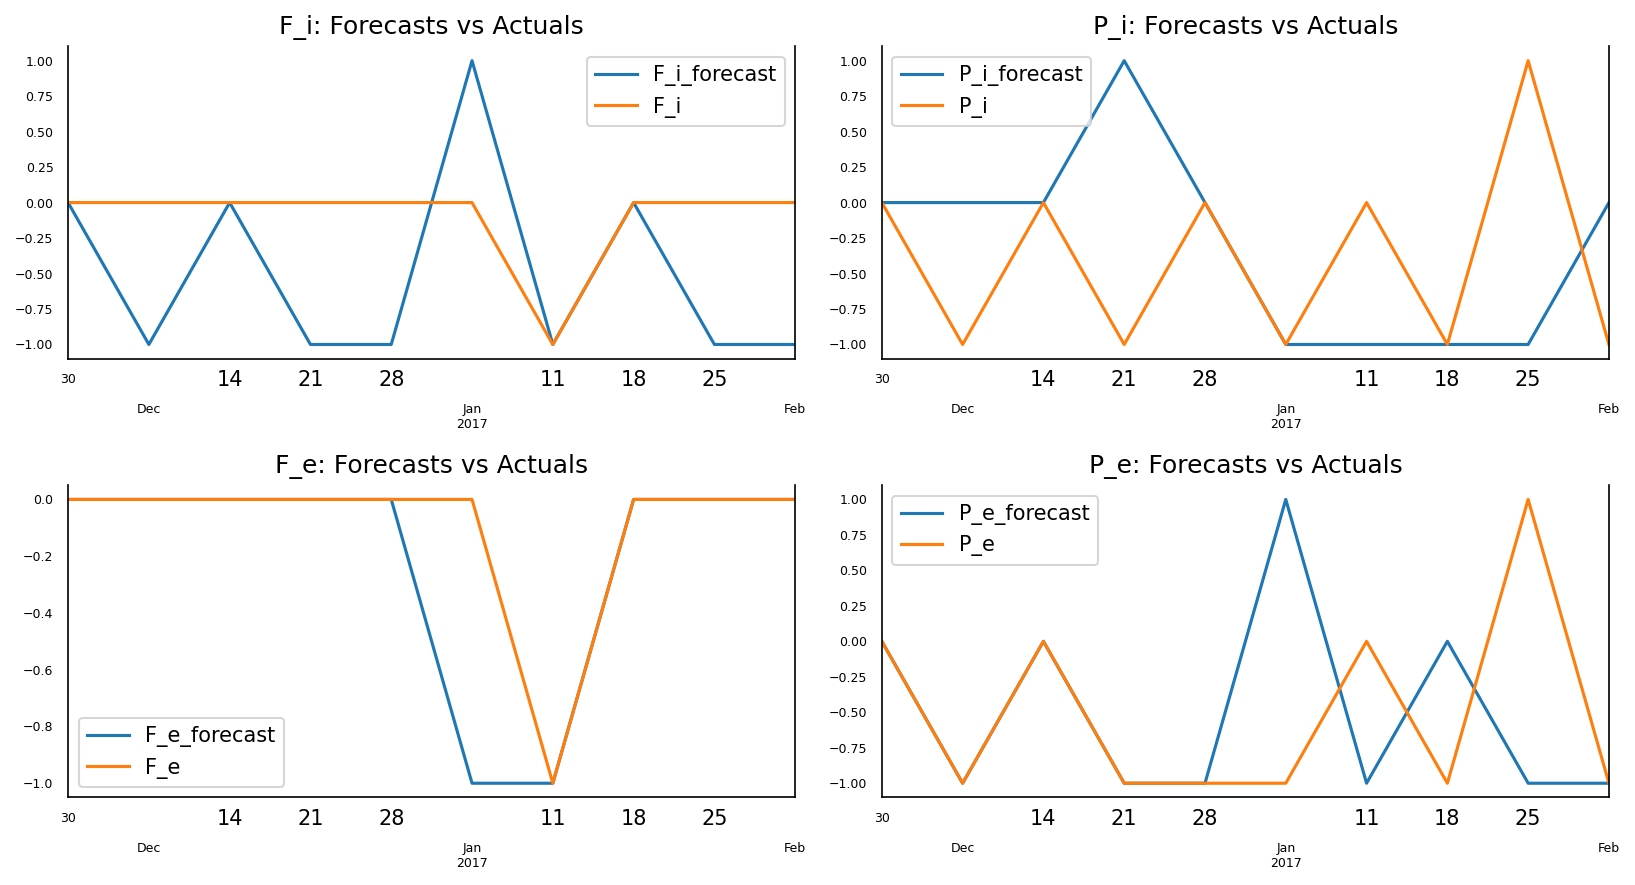

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.4
The accuracy score for PortfolioChangePct_i is 0.5
The accuracy score for FlowPct_e is 0.9
The accuracy score for PortfolioChangePct_e is 0.6


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             1   0   0
 0             5   3   1, P_i_forecast  -1   0   1
P_i                     
-1             2   2   1
 0             1   3   0
 1             1   0   0, F_e_forecast  -1   0
F_e                 
-1             1   0
 0             1   8, P_e_forecast  -1   0   1
P_e                     
-1             4   1   1
 0             1   2   0
 1             1   0   0]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.6904785504771092 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.5209025063277981 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.42919530044034926 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.5036682742334984 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.6
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.5
FlowPct_e v.s. FlowPct_e_forecast: 0.1
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.4


### lcg, Large Capital Growth

In [ ]:
# add index variable(s)
lcg = add_index(lcg)
lcg.head()

FlowPct_i  ...  ClosePct_SP500
2006-01-25  -0.523432  ...       -0.004127
2006-02-01   0.284000  ...        0.185125
2006-02-08   0.314825  ...       -0.549332
2006-02-15   0.328525  ...        0.048025
2006-02-22   0.071275  ...        0.554694

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(lcg, variables = lcg.columns)

FlowPct_i_x  ...  ClosePct_SP500_x
FlowPct_i_y                  1.0000  ...            0.0000
PortfolioChangePct_i_y       0.0003  ...            0.0899
FlowPct_e_y                  0.1028  ...            0.0000
PortfolioChangePct_e_y       0.0002  ...            0.0051
ClosePct_SP500_y             0.0017  ...            1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(lcg)

Statistics analysis of Inst MF FlowPct

Statistic Test: -4.717335705832243
p-value: 7.806396483948995e-05
 => P-Value = 7.806396483948995e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.664819920907283
p-value: 9.793509685422e-05
 => P-Value = 9.793509685422e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -4.973533259700052
p-value: 2.503147737445607e-05
 => P-Value = 2.503147737445607e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.768437116328264
p-value: 6.247344992521432e-05
 => P-Value = 6.247344992521432e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.525945134833848
p-value: 0.0001764687949003256
 => P-Value = 0.0

In [ ]:
# split data
split(lcg, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(lcg.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.04
PortfolioChangePct_i : 2.0
FlowPct_e : 2.03
PortfolioChangePct_e : 2.0
ClosePct_SP500 : 2.0


In [ ]:
forecasting(lcg)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

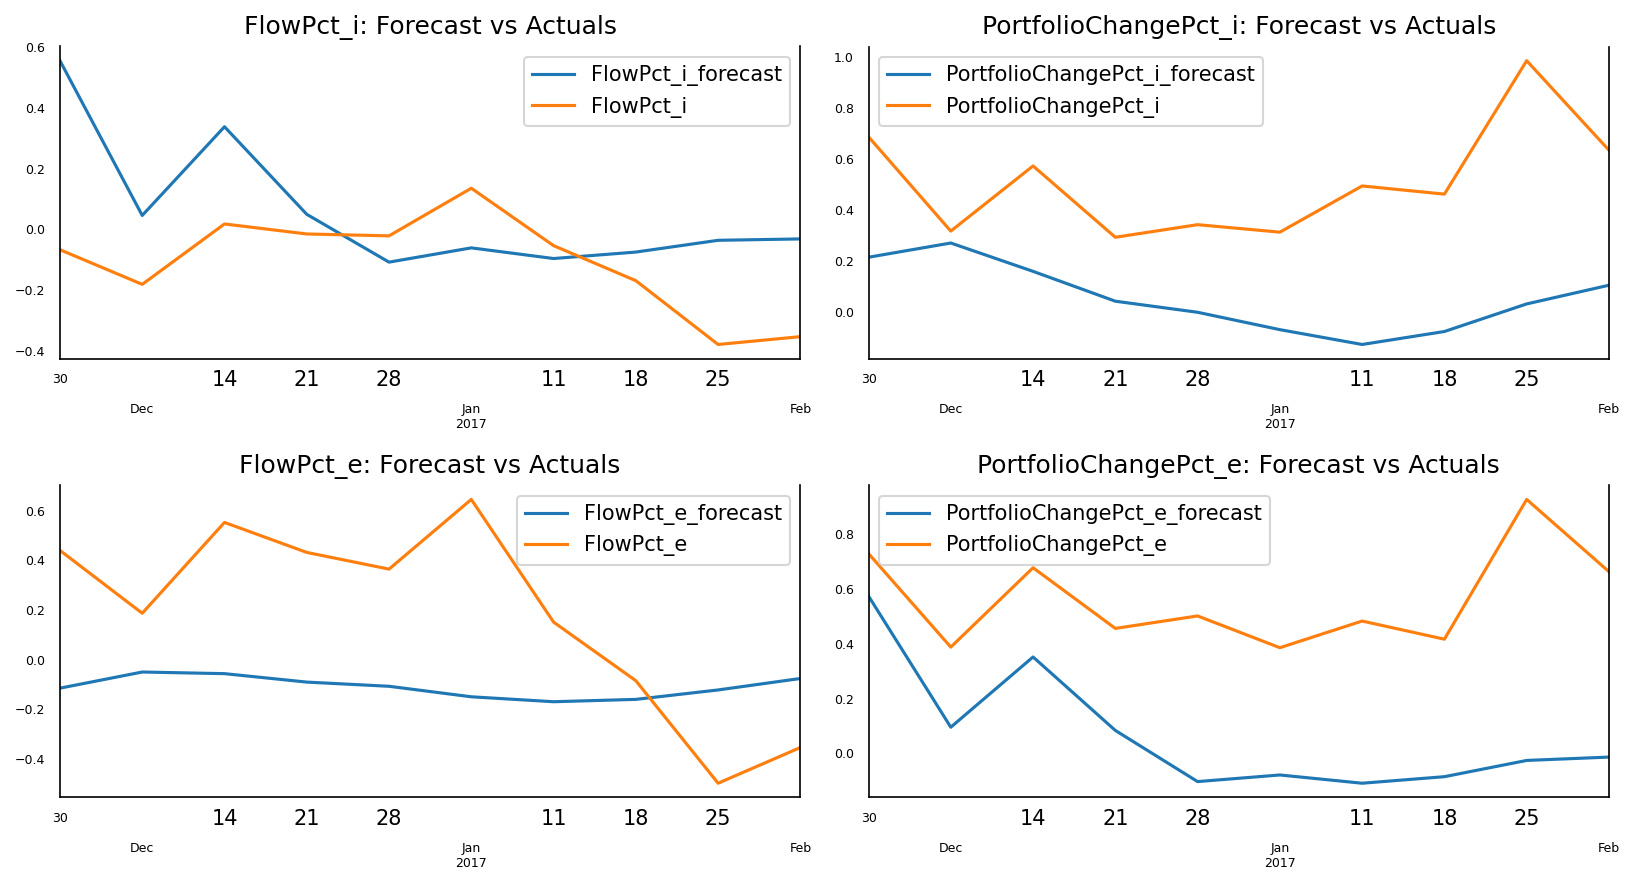

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    lcg[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.2862
corr :  0.1868

Forecast Accuracy of: PortfolioPct_i
rmse :  0.5084
corr :  0.1322

Forecast Accuracy of: FlowPct_e:
rmse :  0.4677
corr :  0.076

Forecast Accuracy of: PortfolioPct_e
rmse :  0.5398
corr :  0.3875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07   -1   -1   -1  ...             0             0            -1
2016-12-14    1    1    1  ...            -1             0             1
2016-12-21    0   -1   -1  ...            -1             0            -1
2016-12-28    0    0    0  ...             0             0            -1
2017-01-04    1    0    1  ...             0             0             0
2017-01-11   -1    1   -1  ...             0             0             0
2017-01-18   -1    0   -1  ...             0             0             0
2017-01-25   -1    1   -1  ...             1             0             0
2017-02-01    0   -1    1  ...             0             0             0

[10 rows x 8 columns]

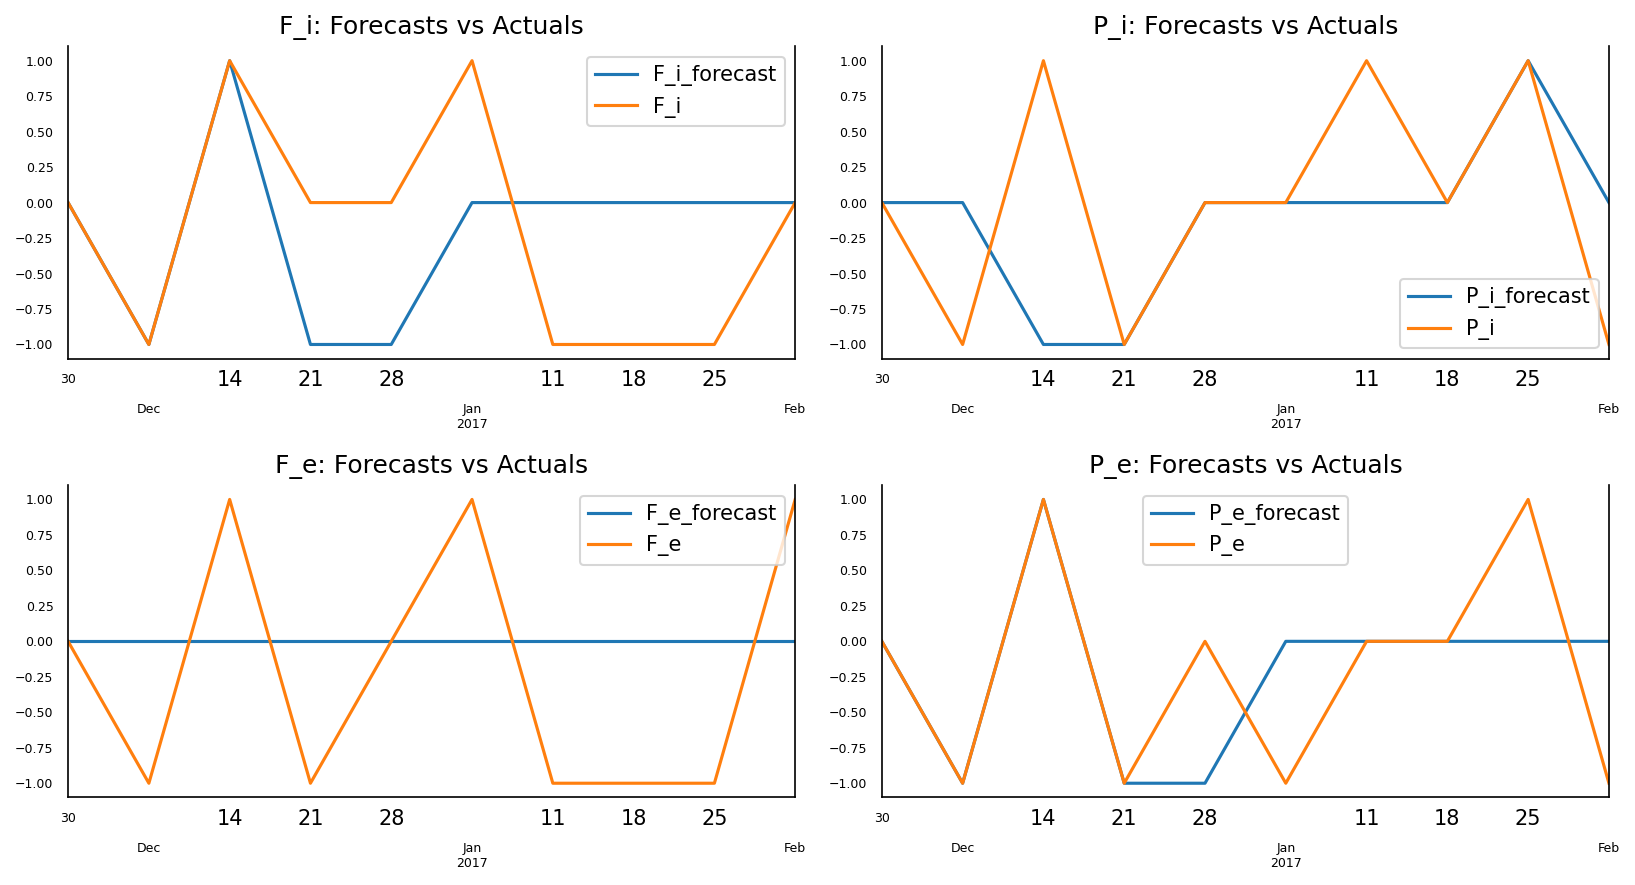

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.4
The accuracy score for PortfolioChangePct_i is 0.6
The accuracy score for FlowPct_e is 0.2
The accuracy score for PortfolioChangePct_e is 0.6


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             1   3   0
 0             2   2   0
 1             0   1   1, P_i_forecast  -1   0   1
P_i                     
-1             1   2   0
 0             0   4   0
 1             1   1   1, F_e_forecast  0
F_e            
-1            5
 0            2
 1            3, P_e_forecast  -1   0   1
P_e                     
-1             2   2   0
 0             1   3   0
 1             0   1   1]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.24715223555106977 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.31261122859368184 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 1.0 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.24715223555106977 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.6
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.4
FlowPct_e v.s. FlowPct_e_forecast: 0.8
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.4


### lcv, Large Capital Value

In [ ]:
# add index variable(s)
lcv = add_index(lcv)
lcv.head()

FlowPct_i  PortfolioChangePct_i  ...  PortfolioChangePct_e  ClosePct_Dow
2006-01-25  -0.149250              0.333375  ...              0.394175     -0.148452
2006-02-01  -0.304575              0.312925  ...              0.424425      0.184134
2006-02-08  -0.145600             -0.356000  ...             -0.272200     -0.408638
2006-02-15   0.006475              0.137750  ...              0.256300      0.479537
2006-02-22   0.099750              0.562900  ...              0.699275      0.990544

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(lcv, variables = lcv.columns)

FlowPct_i_x  ...  ClosePct_Dow_x
FlowPct_i_y                  1.0000  ...          0.0063
PortfolioChangePct_i_y       0.0830  ...          0.0099
FlowPct_e_y                  0.3166  ...          0.0871
PortfolioChangePct_e_y       0.0634  ...          0.0113
ClosePct_Dow_y               0.0423  ...          1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(lcv)

Statistics analysis of Inst MF FlowPct

Statistic Test: -4.9770242075911115
p-value: 2.4637996603432288e-05
 => P-Value = 2.4637996603432288e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.519164817339606
p-value: 0.00018154124307530117
 => P-Value = 0.00018154124307530117. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -5.984800516367301
p-value: 1.80280613476091e-07
 => P-Value = 1.80280613476091e-07. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.582644668155936
p-value: 0.00013902574096017918
 => P-Value = 0.00013902574096017918. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.94146678779208
p-value: 2.894065178440262e-05
 => P-V

In [ ]:
# split data
split(lcv, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(lcv.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.01
PortfolioChangePct_i : 2.02
FlowPct_e : 2.01
PortfolioChangePct_e : 2.02
ClosePct_Dow : 2.03


In [ ]:
forecasting(lcv)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

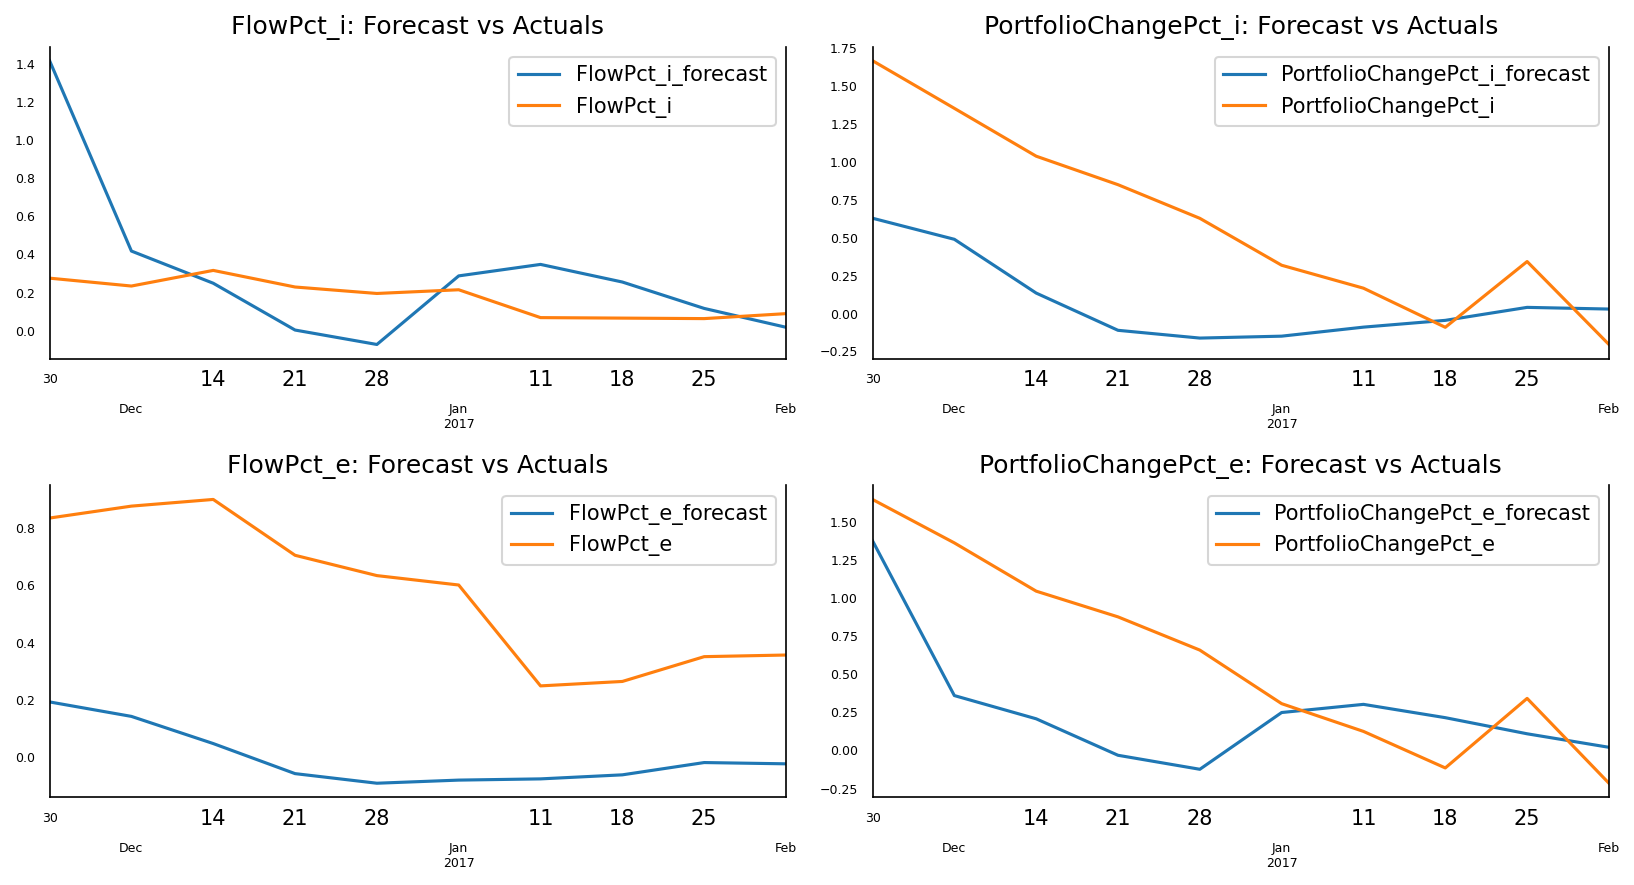

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    lcv[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.399
corr :  0.3656

Forecast Accuracy of: PortfolioPct_i
rmse :  0.6793
corr :  0.7542

Forecast Accuracy of: FlowPct_e:
rmse :  0.6145
corr :  0.6463

Forecast Accuracy of: PortfolioPct_e
rmse :  0.5892
corr :  0.582


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    0   -1    0  ...            -1             0            -1
2016-12-14    0   -1    0  ...            -1             0            -1
2016-12-21    0   -1   -1  ...            -1            -1            -1
2016-12-28    0   -1    0  ...             0             0             0
2017-01-04    0   -1    0  ...             0             0             1
2017-01-11   -1   -1   -1  ...             0             0             0
2017-01-18    0   -1    0  ...             0             0             0
2017-01-25    0    1    0  ...             0             0            -1
2017-02-01    0   -1    0  ...             0             0             0

[10 rows x 8 columns]

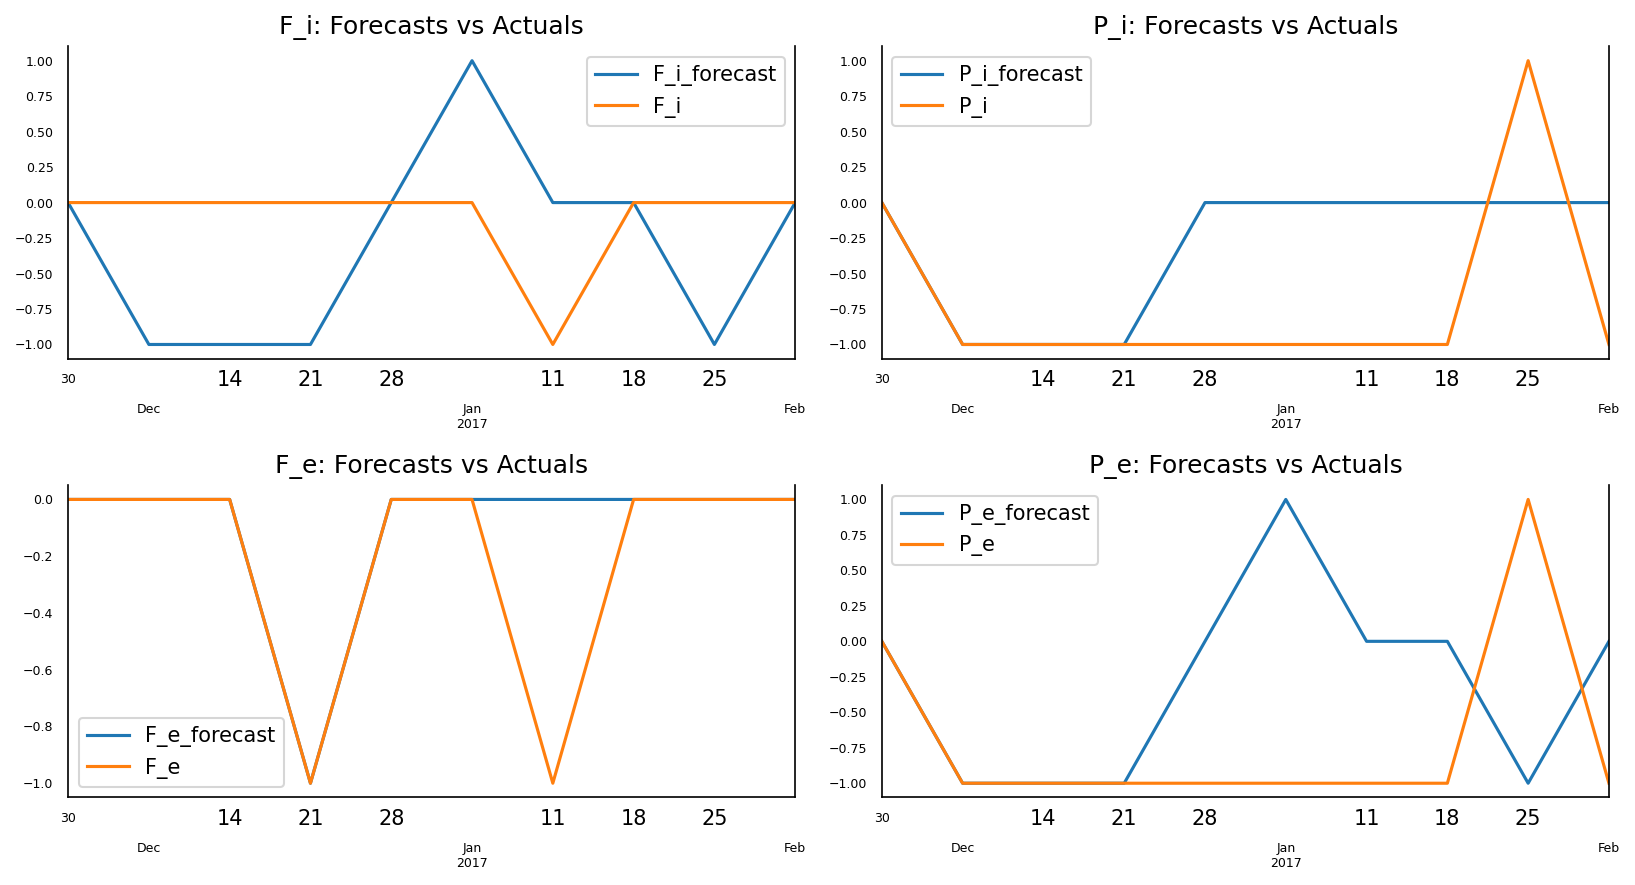

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.4
The accuracy score for PortfolioChangePct_i is 0.4
The accuracy score for FlowPct_e is 0.9
The accuracy score for PortfolioChangePct_e is 0.4


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             0   1   0
 0             4   4   1, P_i_forecast  -1   0
P_i                 
-1             3   5
 0             0   1
 1             0   1, F_e_forecast  -1   0
F_e                 
-1             1   1
 0             0   8, P_e_forecast  -1   0   1
P_e                     
-1             3   4   1
 0             0   1   0
 1             1   0   0]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.5737534207374329 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.5852511043074122 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.42919530044034926 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.6334802462383335 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.6
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.6
FlowPct_e v.s. FlowPct_e_forecast: 0.1
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.6


### mcb, Mid Capital Blend

In [ ]:
# add index variable(s)
mcb = add_index(mcb)
mcb.head()

FlowPct_i  ...  ClosePct_Nasdaq
2006-01-25   0.447650  ...         0.374269
2006-02-01   0.392125  ...         0.539033
2006-02-08   0.233075  ...        -0.682456
2006-02-15   0.448000  ...        -0.023631
2006-02-22   0.279925  ...         0.258645

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(mcb, variables = mcb.columns)

FlowPct_i_x  ...  ClosePct_Nasdaq_x
FlowPct_i_y                  1.0000  ...             0.0000
PortfolioChangePct_i_y       0.0029  ...             0.1255
FlowPct_e_y                  0.0185  ...             0.0014
PortfolioChangePct_e_y       0.0033  ...             0.1346
ClosePct_Nasdaq_y            0.0203  ...             1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(mcb)

Statistics analysis of Inst MF FlowPct

Statistic Test: -4.25868275490049
p-value: 0.0005233708452105758
 => P-Value = 0.0005233708452105758. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.705106534498113
p-value: 8.231352024065032e-05
 => P-Value = 8.231352024065032e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -4.5896436382108705
p-value: 0.0001349676651643016
 => P-Value = 0.0001349676651643016. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.602430596209558
p-value: 0.000127843719285958
 => P-Value = 0.000127843719285958. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.759456112991914
p-value: 6.497783575218942e-05
 => P-Value =

In [ ]:
# split data
split(mcb, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(mcb.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.01
PortfolioChangePct_i : 2.0
FlowPct_e : 2.02
PortfolioChangePct_e : 2.0
ClosePct_Nasdaq : 2.0


In [ ]:
forecasting(mcb)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

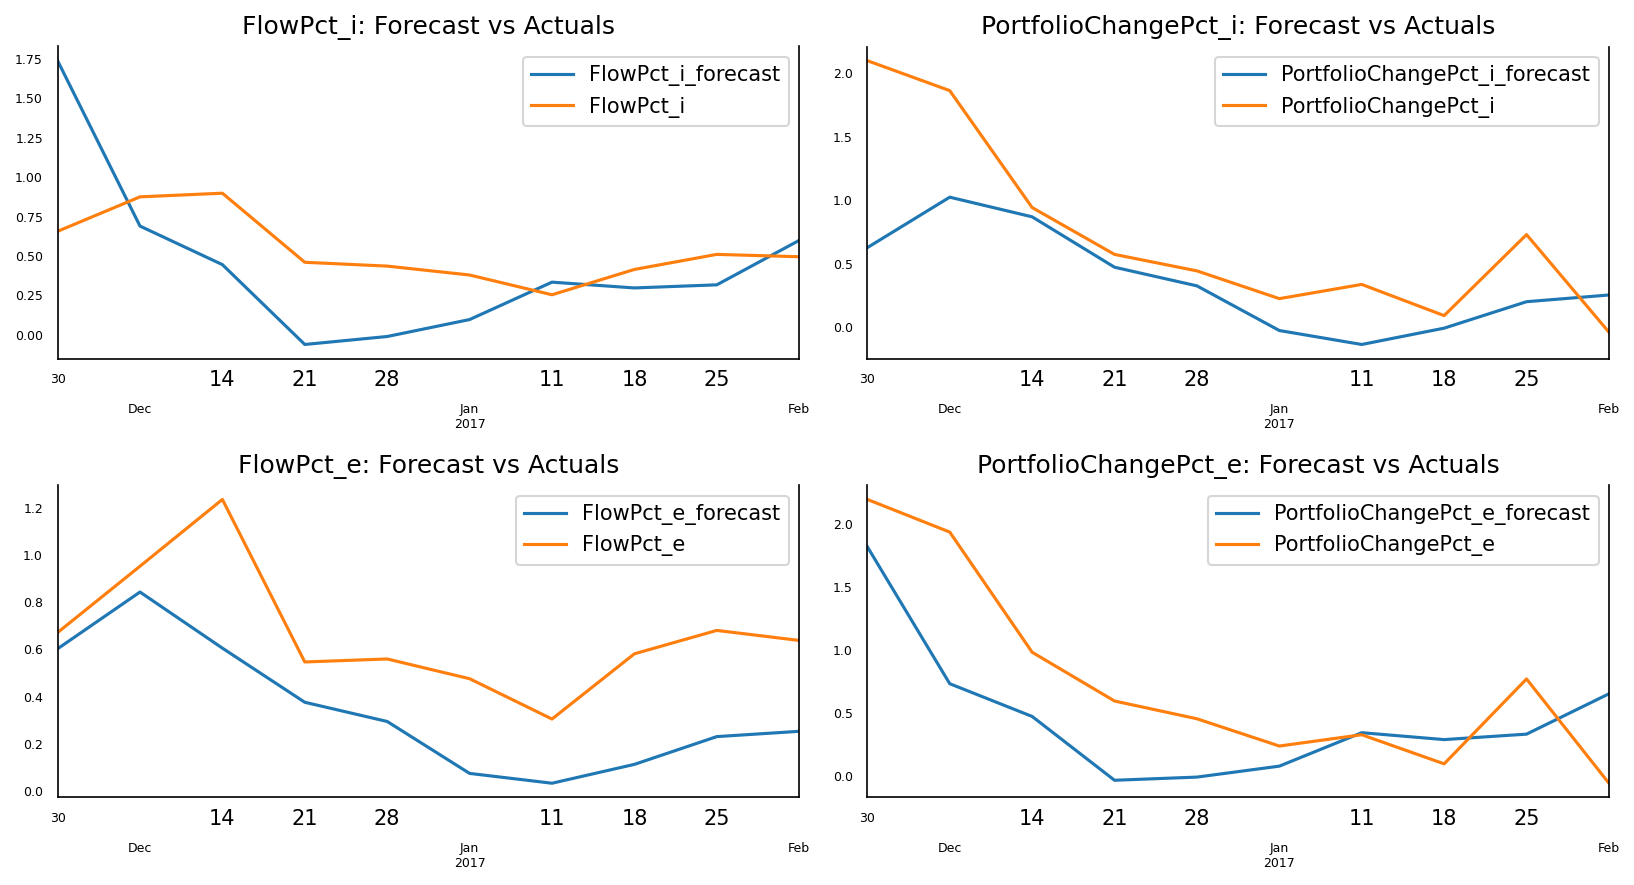

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    mcb[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.4511
corr :  0.4344

Forecast Accuracy of: PortfolioPct_i
rmse :  0.597
corr :  0.7619

Forecast Accuracy of: FlowPct_e:
rmse :  0.3625
corr :  0.7732

Forecast Accuracy of: PortfolioPct_e
rmse :  0.5672
corr :  0.7329


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    1   -1    1  ...             1             1            -1
2016-12-14    0   -1    1  ...            -1            -1            -1
2016-12-21   -1   -1   -1  ...            -1            -1            -1
2016-12-28    0   -1    0  ...            -1             0             0
2017-01-04    0   -1    0  ...            -1            -1             0
2017-01-11   -1    1   -1  ...            -1             0             1
2017-01-18    1   -1    1  ...             1             0             0
2017-01-25    0    1    0  ...             1             1             0
2017-02-01    0   -1    0  ...             0             0             1

[10 rows x 8 columns]

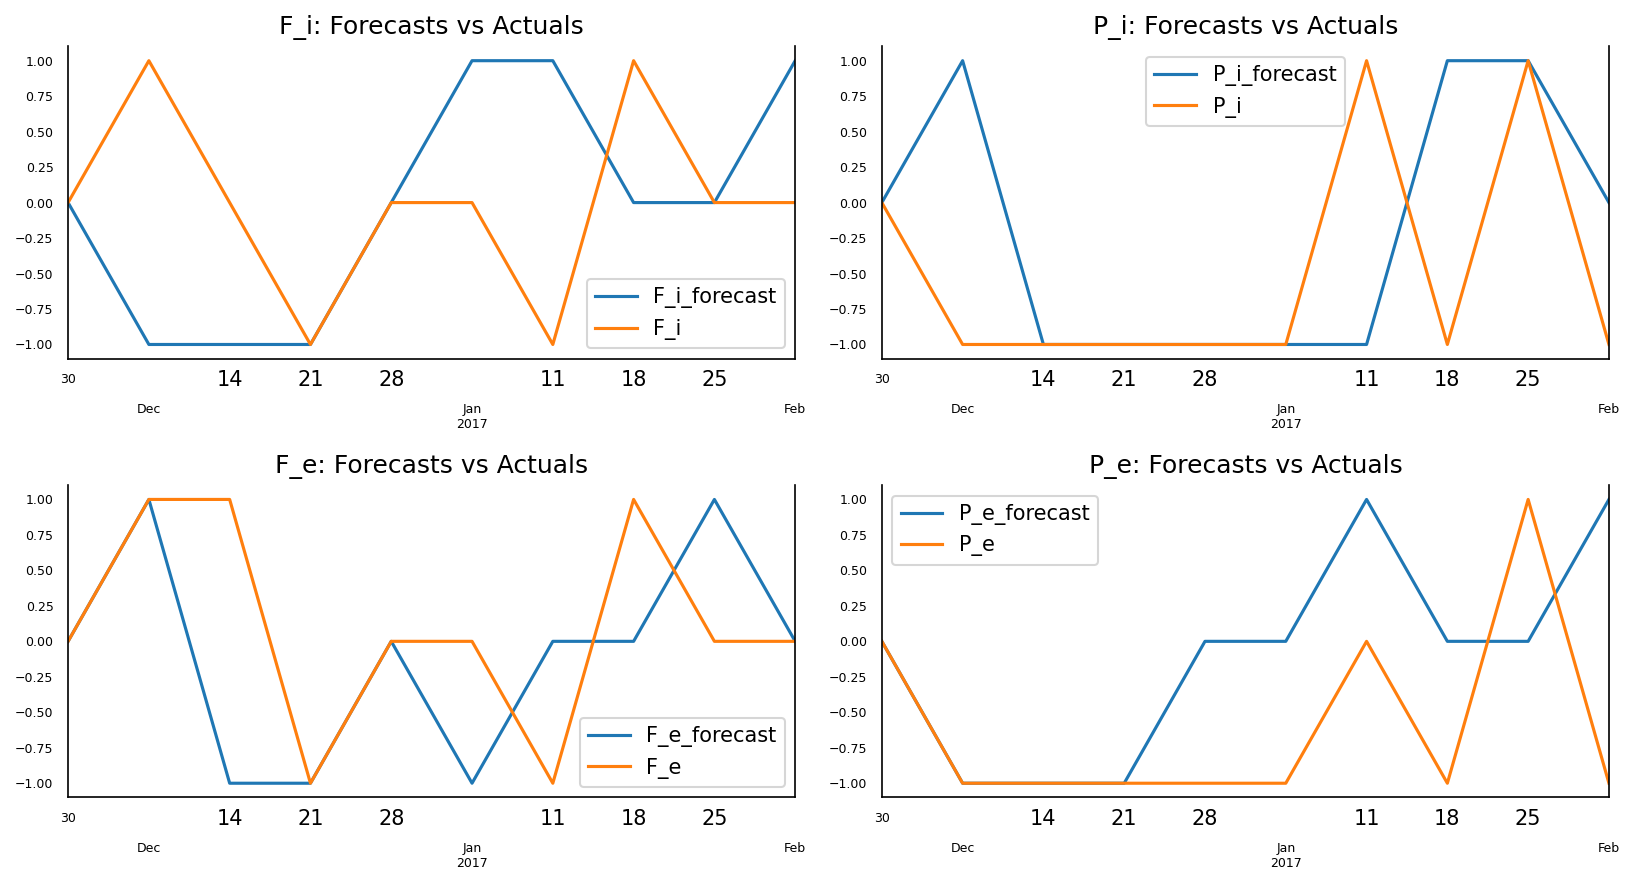

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.4
The accuracy score for PortfolioChangePct_i is 0.6
The accuracy score for FlowPct_e is 0.5
The accuracy score for PortfolioChangePct_e is 0.4


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             1   0   1
 0             1   3   2
 1             1   1   0, P_i_forecast  -1   0   1
P_i                     
-1             4   1   2
 0             0   1   0
 1             1   0   1, F_e_forecast  -1   0   1
F_e                     
-1             1   1   0
 0             1   3   1
 1             1   1   1, P_e_forecast  -1   0   1
P_e                     
-1             3   3   1
 0             0   1   1
 1             0   1   0]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.5956747209679855 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.30227207781379684 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.8480480022436846 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.5459439747510074 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.6
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.4
FlowPct_e v.s. FlowPct_e_forecast: 0.5
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.6


### mcg, Mid Capital Growth


In [ ]:
# add index variable(s)
mcg = add_index(mcg)
mcg.head()

FlowPct_i  ...  ClosePct_Nasdaq
2006-01-25   0.883250  ...         0.374269
2006-02-01   0.798025  ...         0.539033
2006-02-08   0.805100  ...        -0.682456
2006-02-15   0.643625  ...        -0.023631
2006-02-22   0.547450  ...         0.258645

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(mcg, variables = mcg.columns)

FlowPct_i_x  ...  ClosePct_Nasdaq_x
FlowPct_i_y                  1.0000  ...             0.0000
PortfolioChangePct_i_y       0.0003  ...             0.0790
FlowPct_e_y                  0.0347  ...             0.0000
PortfolioChangePct_e_y       0.0002  ...             0.0376
ClosePct_Nasdaq_y            0.0003  ...             1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(mcg)

Statistics analysis of Inst MF FlowPct

Statistic Test: -3.9666672797783855
p-value: 0.0015954685770610127
 => P-Value = 0.0015954685770610127. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.5698675305489
p-value: 0.00014673599070357983
 => P-Value = 0.00014673599070357983. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -4.407479292854303
p-value: 0.00028791525901830737
 => P-Value = 0.00028791525901830737. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.6129544389411254
p-value: 0.0001222512307593932
 => P-Value = 0.0001222512307593932. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.759456112991914
p-value: 6.497783575218942e-05
 => P-V

In [ ]:
# split data
split(mcg, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(mcg.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.02
PortfolioChangePct_i : 2.01
FlowPct_e : 2.0
PortfolioChangePct_e : 2.01
ClosePct_Nasdaq : 2.01


In [ ]:
forecasting(mcg)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

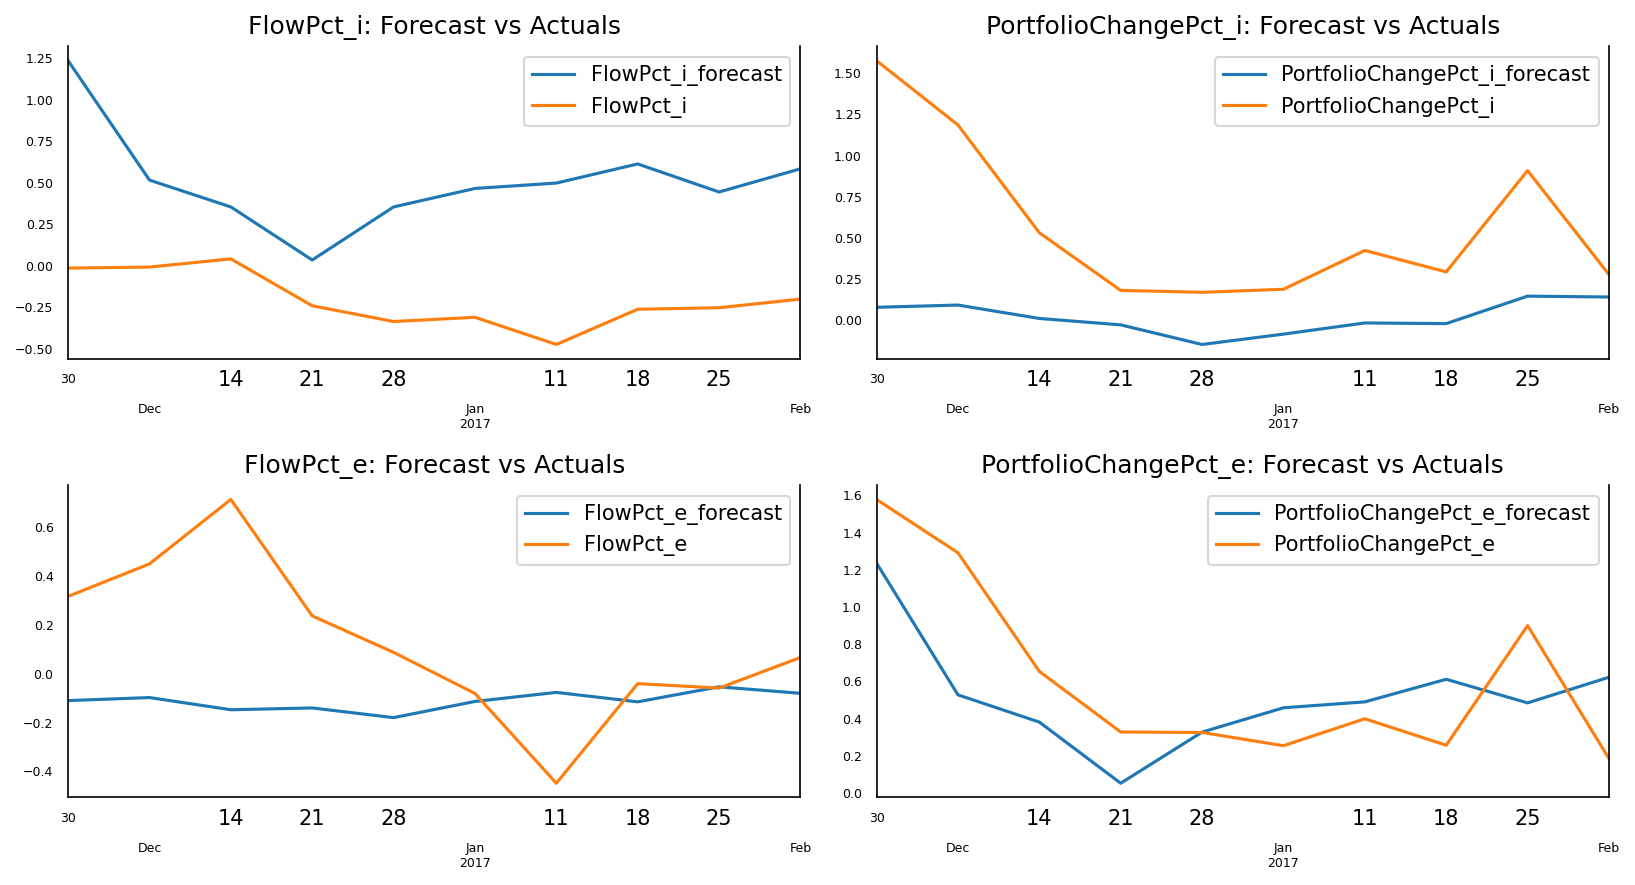

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    mcg[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.7682
corr :  0.3223

Forecast Accuracy of: PortfolioPct_i
rmse :  0.694
corr :  0.5982

Forecast Accuracy of: FlowPct_e:
rmse :  0.4004
corr :  -0.448

Forecast Accuracy of: PortfolioPct_e
rmse :  0.3727
corr :  0.6253


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    0   -1    1  ...             0             0            -1
2016-12-14    0   -1    1  ...             0             0            -1
2016-12-21   -1   -1   -1  ...             0             0            -1
2016-12-28    0    0   -1  ...            -1             0             1
2017-01-04    0    0   -1  ...             0             0             1
2017-01-11   -1    1   -1  ...             0             0             0
2017-01-18    1   -1    1  ...             0             0             1
2017-01-25    0    1    0  ...             1             0            -1
2017-02-01    0   -1    1  ...             0             0             1

[10 rows x 8 columns]

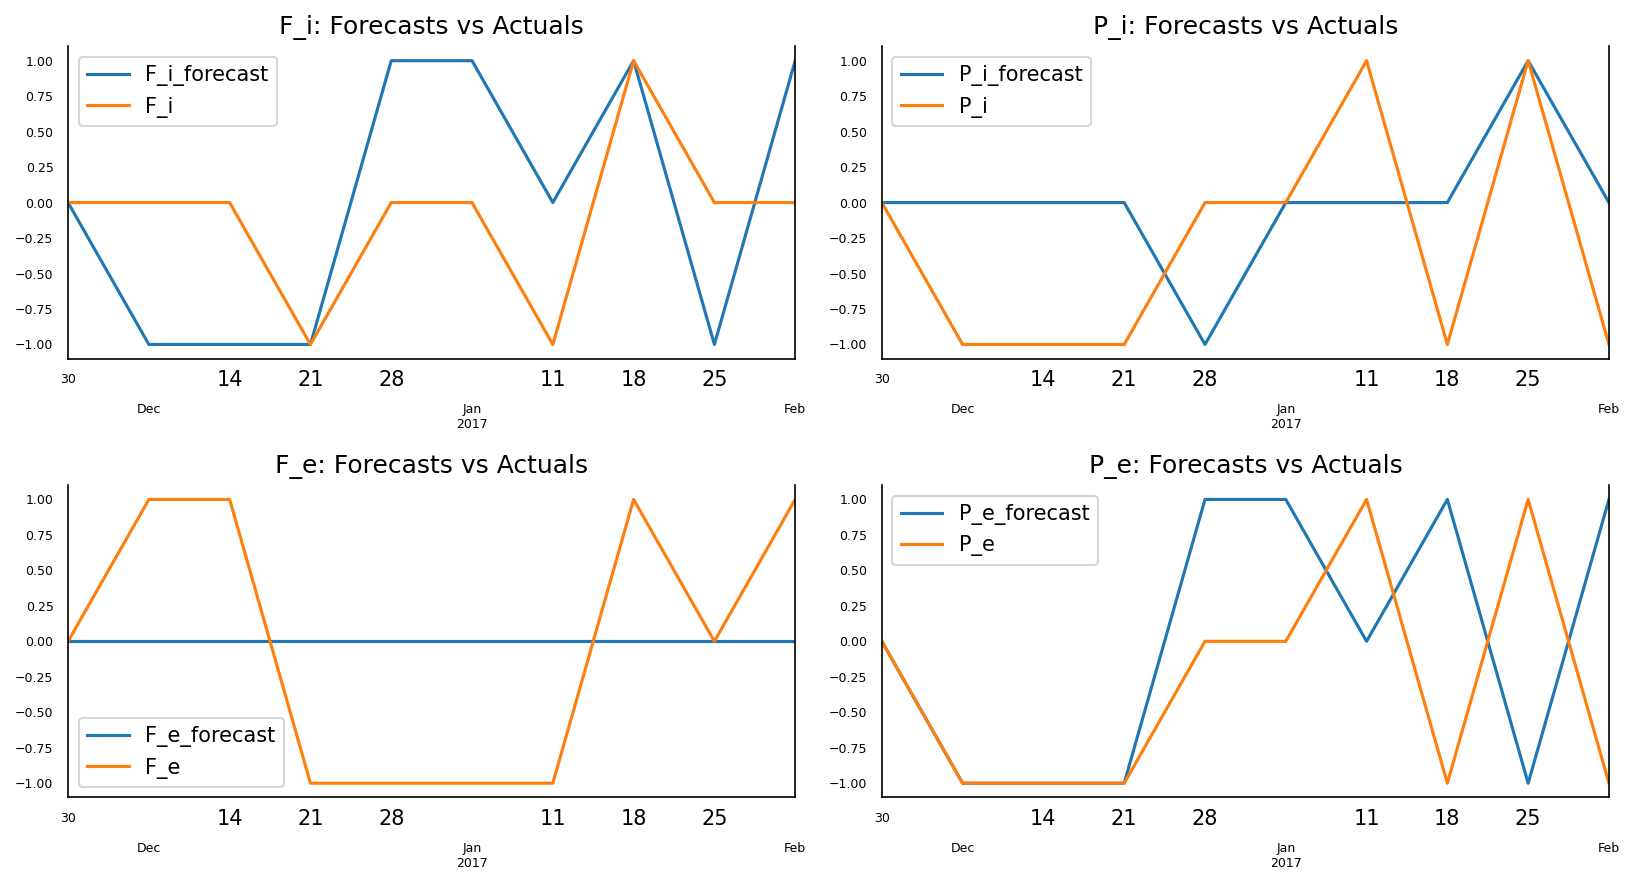

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.3
The accuracy score for PortfolioChangePct_i is 0.3
The accuracy score for FlowPct_e is 0.2
The accuracy score for PortfolioChangePct_e is 0.4


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             1   1   0
 0             3   1   3
 1             0   0   1, P_i_forecast  -1   0   1
P_i                     
-1             0   5   0
 0             1   2   0
 1             0   1   1, F_e_forecast  0
F_e            
-1            4
 0            2
 1            4, P_e_forecast  -1   0   1
P_e                     
-1             3   0   2
 0             0   1   2
 1             1   1   0]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.4943554800435839 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.14264320376301254 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 1.0 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.2625941192491615 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.7
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.7
FlowPct_e v.s. FlowPct_e_forecast: 0.8
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.6


### mcv, Mid Capital Value

In [ ]:
# add index variable(s)
mcv = add_index(mcv)
mcv.head()

FlowPct_i  ...  ClosePct_Russell
2006-01-25  -0.567325  ...          1.322476
2006-02-01  -1.415458  ...          1.649421
2006-02-08  -1.432658  ...          0.366872
2006-02-15  -1.342008  ...          0.763936
2006-02-22  -1.258058  ...          0.604516

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(mcv, variables = mcv.columns)

FlowPct_i_x  ...  ClosePct_Russell_x
FlowPct_i_y                  1.0000  ...              0.0000
PortfolioChangePct_i_y       0.0002  ...              0.0298
FlowPct_e_y                  0.0683  ...              0.0000
PortfolioChangePct_e_y       0.0001  ...              0.0138
ClosePct_Russell_y           0.0006  ...              1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(mcv)

Statistics analysis of Inst MF FlowPct

Statistic Test: -4.399893848774619
p-value: 0.00029696104801087185
 => P-Value = 0.00029696104801087185. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.478346967271542
p-value: 0.00021513468030296017
 => P-Value = 0.00021513468030296017. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -4.87633003762165
p-value: 3.876919377504331e-05
 => P-Value = 3.876919377504331e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.554944277917221
p-value: 0.00015625748650240504
 => P-Value = 0.00015625748650240504. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -5.078985008611483
p-value: 1.5449147125858165e-05
 => P

In [ ]:
# split data
split(mcv, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(mcv.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.0
PortfolioChangePct_i : 1.98
FlowPct_e : 2.0
PortfolioChangePct_e : 1.98
ClosePct_Russell : 1.99


In [ ]:
forecasting(mcv)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

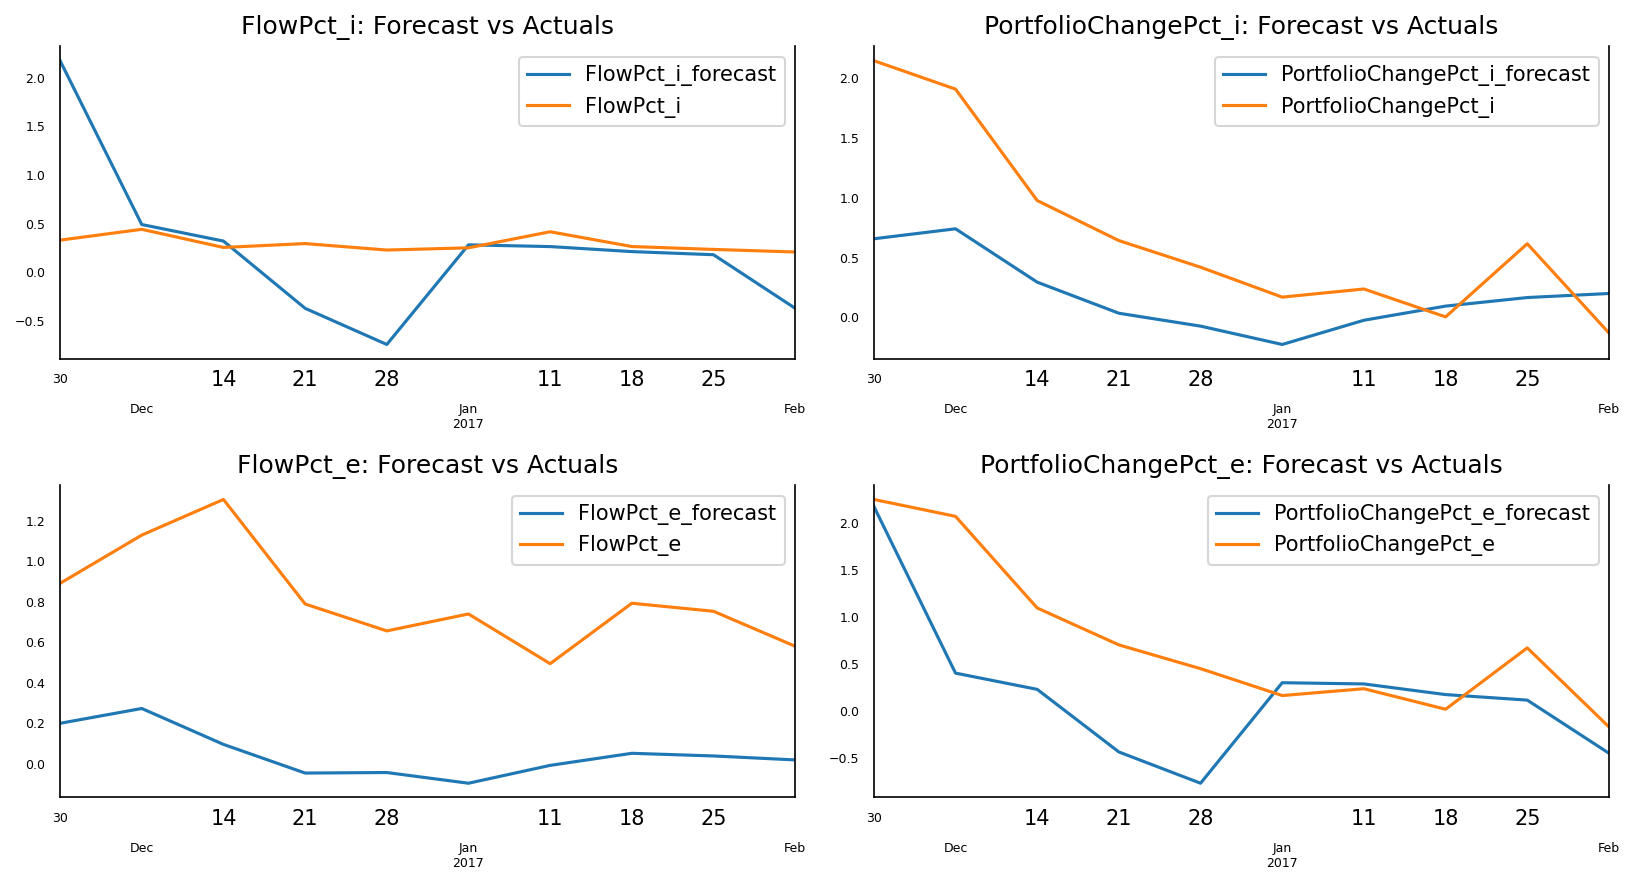

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    mcv[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.7186
corr :  0.4007

Forecast Accuracy of: PortfolioPct_i
rmse :  0.7212
corr :  0.8544

Forecast Accuracy of: FlowPct_e:
rmse :  0.7873
corr :  0.6295

Forecast Accuracy of: PortfolioPct_e
rmse :  0.8202
corr :  0.6844


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    1   -1    1  ...             0             0            -1
2016-12-14   -1   -1    1  ...            -1            -1            -1
2016-12-21    0   -1   -1  ...            -1            -1            -1
2016-12-28    0   -1   -1  ...            -1             0            -1
2017-01-04    0   -1    0  ...            -1             0             1
2017-01-11    1    0   -1  ...             1             0             0
2017-01-18   -1   -1    1  ...             1             0            -1
2017-01-25    0    1    0  ...             0             0             0
2017-02-01    0   -1   -1  ...             0             0            -1

[10 rows x 8 columns]

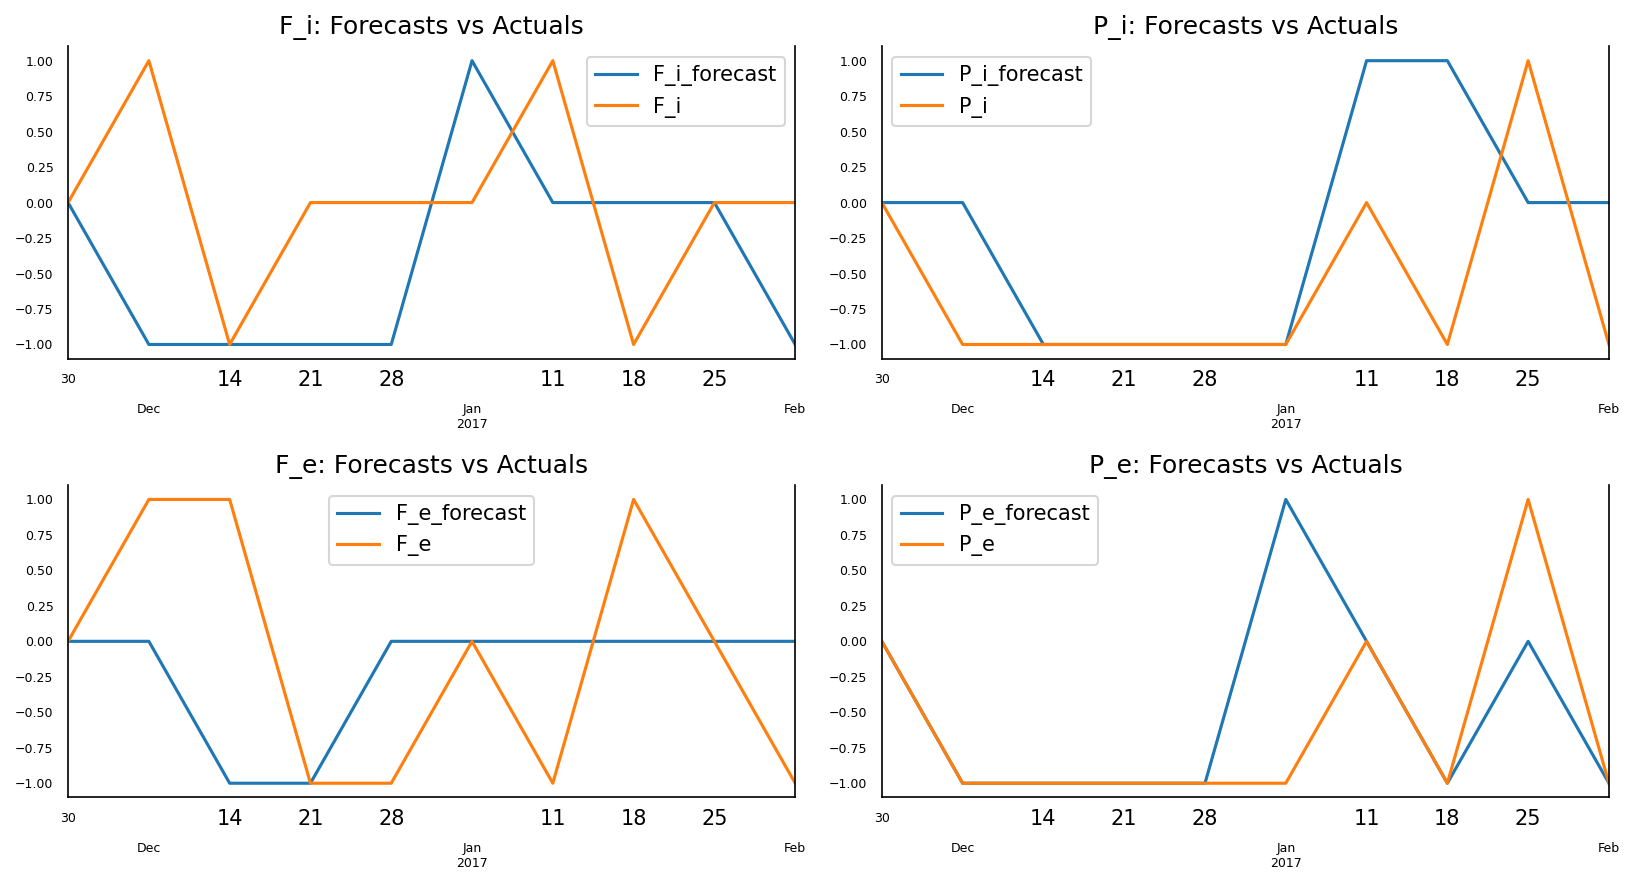

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.3
The accuracy score for PortfolioChangePct_i is 0.5
The accuracy score for FlowPct_e is 0.4
The accuracy score for PortfolioChangePct_e is 0.8


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             1   1   0
 0             3   2   1
 1             1   1   0, P_i_forecast  -1   0   1
P_i                     
-1             4   2   1
 0             0   1   1
 1             0   1   0, F_e_forecast  -1   0
F_e                 
-1             1   3
 0             0   3
 1             1   2, P_e_forecast  -1   0   1
P_e                     
-1             6   0   1
 0             0   2   0
 1             0   1   0]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.9339242261172953 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.3916997945559237 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.5638783926131501 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.04042768199451284 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.7
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.5
FlowPct_e v.s. FlowPct_e_forecast: 0.6
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.2


### rea, Real Estate

In [ ]:
# add index variable(s)
rea = add_index(rea)
rea.head()

FlowPct_i  PortfolioChangePct_i  ...  ClosePct_SP500  ClosePct_Dow
2006-01-25  -4.778798              1.071575  ...       -0.004127     -0.148452
2006-02-01   4.328739              1.118925  ...        0.185125      0.184134
2006-02-08  -6.972961             -0.390050  ...       -0.549332     -0.408638
2006-02-15  -5.615036              0.656725  ...        0.048025      0.479537
2006-02-22   1.124612              1.083150  ...        0.554694      0.990544

[5 rows x 6 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(rea, variables = rea.columns)

FlowPct_i_x  ...  ClosePct_Dow_x
FlowPct_i_y                  1.0000  ...          0.0795
PortfolioChangePct_i_y       0.0247  ...          0.1116
FlowPct_e_y                  0.0000  ...          0.0802
PortfolioChangePct_e_y       0.0280  ...          0.0947
ClosePct_SP500_y             0.1891  ...          0.0763
ClosePct_Dow_y               0.1639  ...          1.0000

[6 rows x 6 columns]

In [ ]:
# adf
adf_test(rea)

Statistics analysis of Inst MF FlowPct

Statistic Test: -4.522350682213562
p-value: 0.00017914080837314148
 => P-Value = 0.00017914080837314148. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.872870961758525
p-value: 3.9372289779920574e-05
 => P-Value = 3.9372289779920574e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -5.095628506089729
p-value: 1.4305533306276562e-05
 => P-Value = 1.4305533306276562e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.9501551995975435
p-value: 2.7826950308871892e-05
 => P-Value = 2.7826950308871892e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct1

Statistic Test: -4.525945134833848
p-value: 0.0001764687949003256
 

In [ ]:
# split data
split(rea, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(rea.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 1.99
PortfolioChangePct_i : 1.99
FlowPct_e : 2.0
PortfolioChangePct_e : 1.99
ClosePct_SP500 : 2.01
ClosePct_Dow : 2.03


In [ ]:
forecasting(rea)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

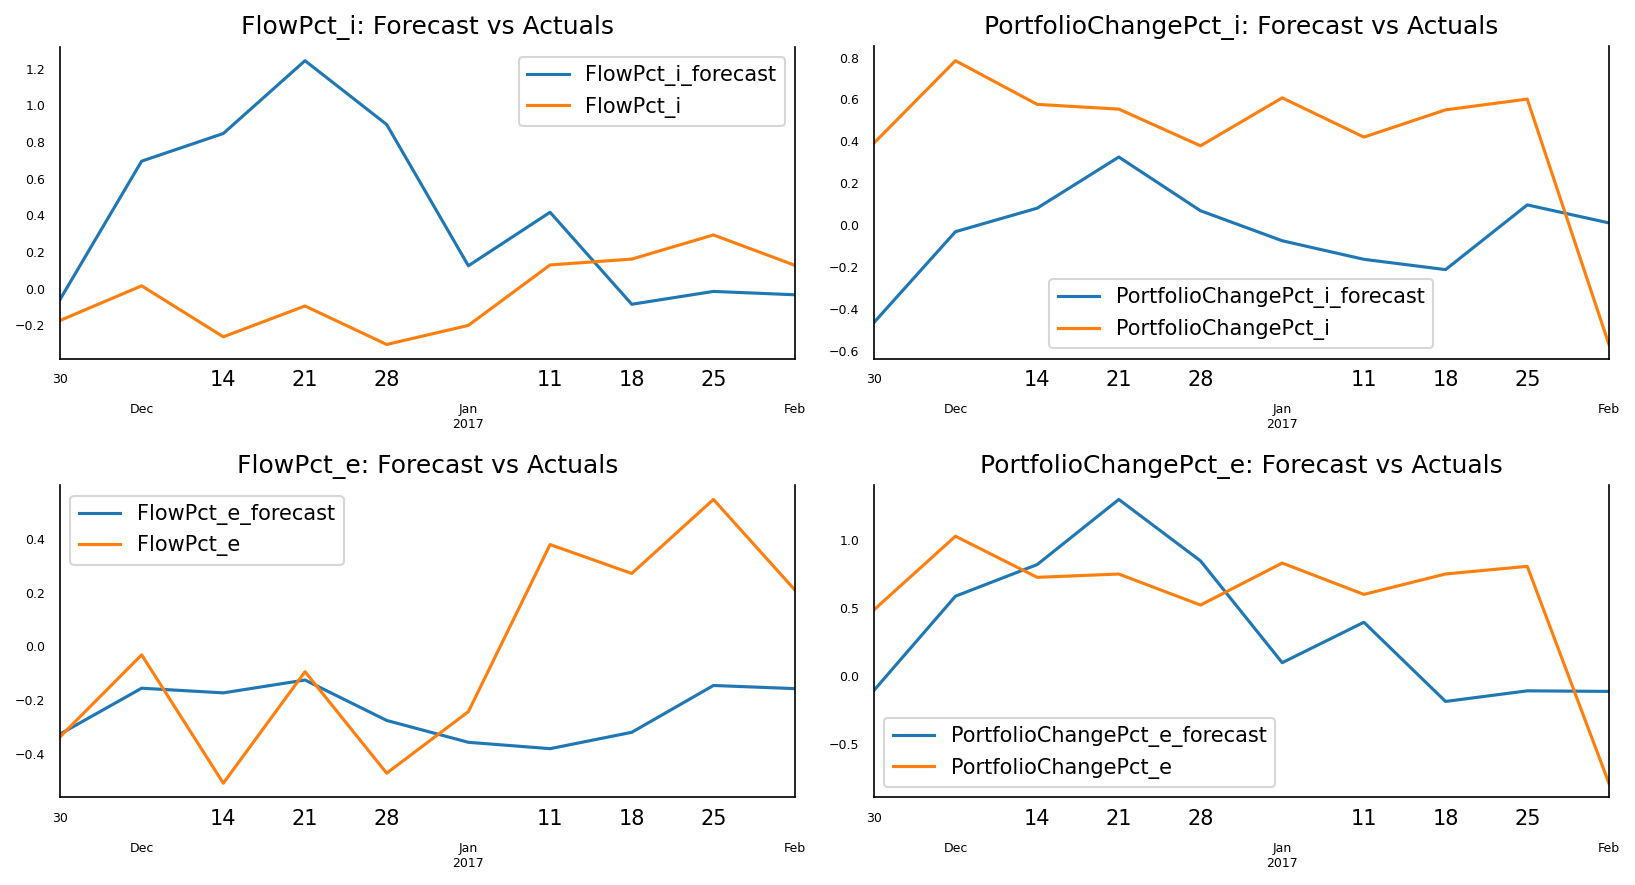

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    rea[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.7286
corr :  -0.5143

Forecast Accuracy of: PortfolioPct_i
rmse :  0.6147
corr :  0.0342

Forecast Accuracy of: FlowPct_e:
rmse :  0.4148
corr :  0.0619

Forecast Accuracy of: PortfolioPct_e
rmse :  0.6086
corr :  0.3099


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 10:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    1    1    1  ...             1             1             1
2016-12-14   -1   -1   -1  ...             1             0             1
2016-12-21    1    0    1  ...             1             0             1
2016-12-28   -1   -1   -1  ...            -1            -1            -1
2017-01-04    1    1    1  ...            -1             0            -1
2017-01-11    1   -1    1  ...             0             0             1
2017-01-18    0    1   -1  ...             0             0            -1
2017-01-25    1    0    1  ...             1             1             0
2017-02-01   -1   -1   -1  ...             0             0             0

[10 rows x 8 columns]

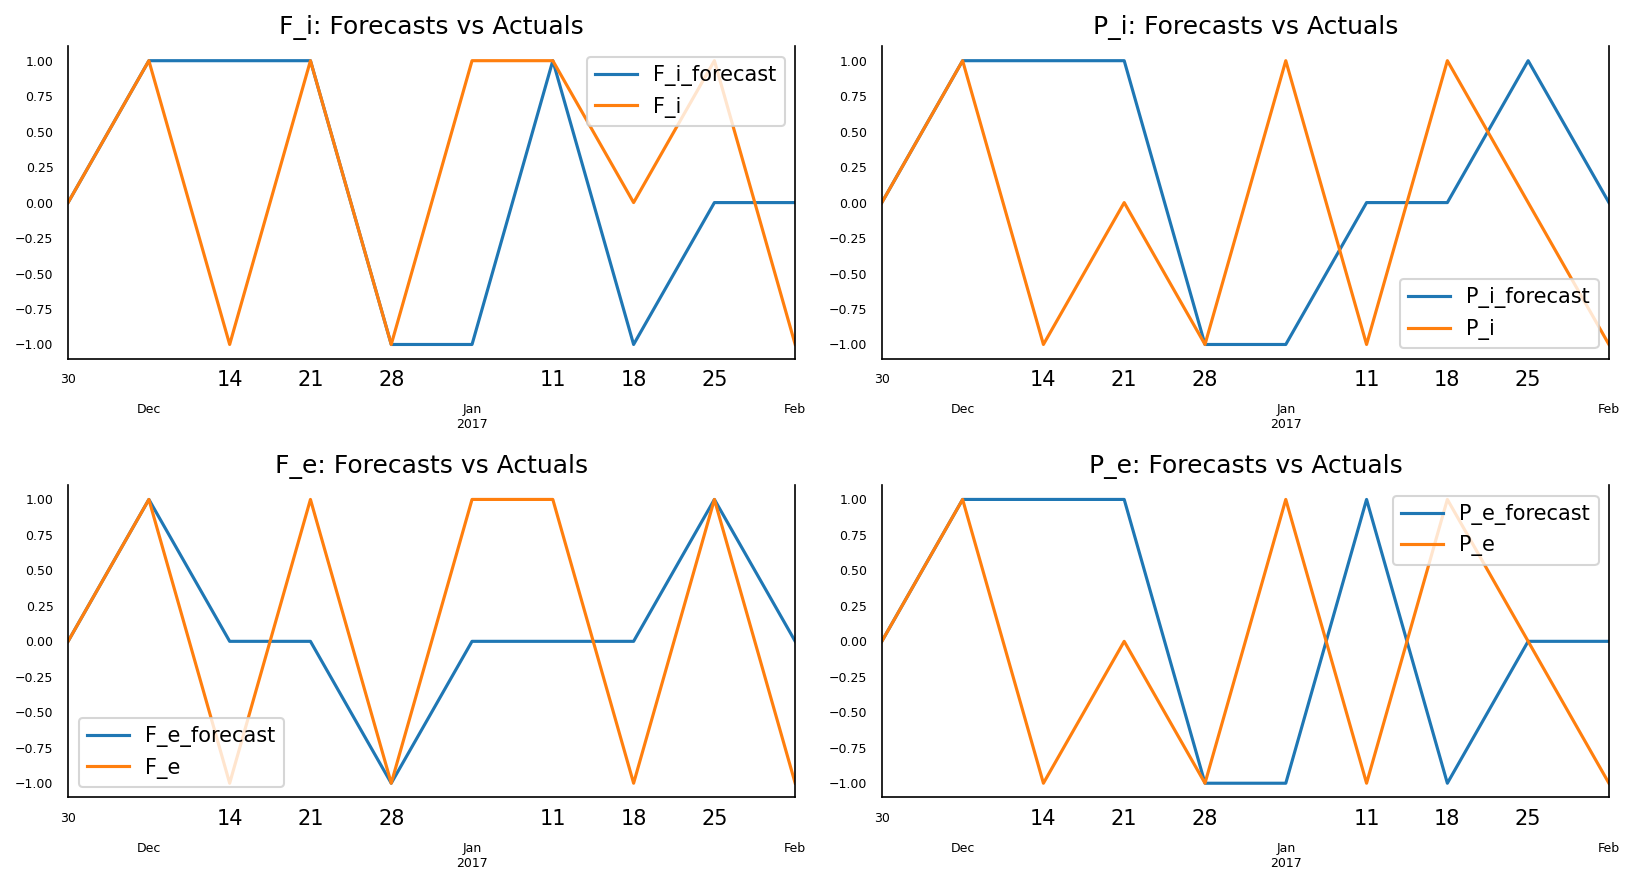

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.5
The accuracy score for PortfolioChangePct_i is 0.3
The accuracy score for FlowPct_e is 0.4
The accuracy score for PortfolioChangePct_e is 0.4


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             1   1   1
 0             1   1   0
 1             1   1   3, P_i_forecast  -1   0   1
P_i                     
-1             1   2   1
 0             0   1   2
 1             1   1   1, F_e_forecast  -1   0   1
F_e                     
-1             1   3   0
 0             0   1   0
 1             0   3   2, P_e_forecast  -1   0   1
P_e                     
-1             1   1   2
 0             0   2   1
 1             2   0   1]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.694962974261134 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.758735901686298 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.4460515580456318 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.31700443839066844 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.5
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.7
FlowPct_e v.s. FlowPct_e_forecast: 0.6
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.6


### scb, Small Capital Blend

In [ ]:
# add index variable(s)
scb = add_index(scb)
scb.head()

FlowPct_i  PortfolioChangePct_i  ...  PortfolioChangePct_e  ClosePct_Dow
2006-01-25   -1.80980              1.219575  ...              1.255825     -0.148452
2006-02-01    2.19699              1.567000  ...              1.607875      0.184134
2006-02-08    0.92009              0.349125  ...              0.355100     -0.408638
2006-02-15    0.58824              0.697175  ...              0.733900      0.479537
2006-02-22    3.28754              0.606300  ...              0.619400      0.990544

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(scb, variables = scb.columns)

FlowPct_i_x  ...  ClosePct_Dow_x
FlowPct_i_y                  1.0000  ...          0.0440
PortfolioChangePct_i_y       0.0013  ...          0.0774
FlowPct_e_y                  0.0000  ...          0.0677
PortfolioChangePct_e_y       0.0012  ...          0.0560
ClosePct_Dow_y               0.0006  ...          1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(scb)

Statistics analysis of Inst MF FlowPct

Statistic Test: -5.742352381138441
p-value: 6.233330562934761e-07
 => P-Value = 6.233330562934761e-07. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.979442529047197
p-value: 2.4368919127756826e-05
 => P-Value = 2.4368919127756826e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -5.363715526223276
p-value: 4.035177777694247e-06
 => P-Value = 4.035177777694247e-06. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -5.055758619401324
p-value: 1.719372749515388e-05
 => P-Value = 1.719372749515388e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.94146678779208
p-value: 2.894065178440262e-05
 => P-Valu

In [ ]:
# split data
split(scb, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(scb.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.01
PortfolioChangePct_i : 2.01
FlowPct_e : 2.01
PortfolioChangePct_e : 2.01
ClosePct_Dow : 2.01


In [ ]:
forecasting(scb)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

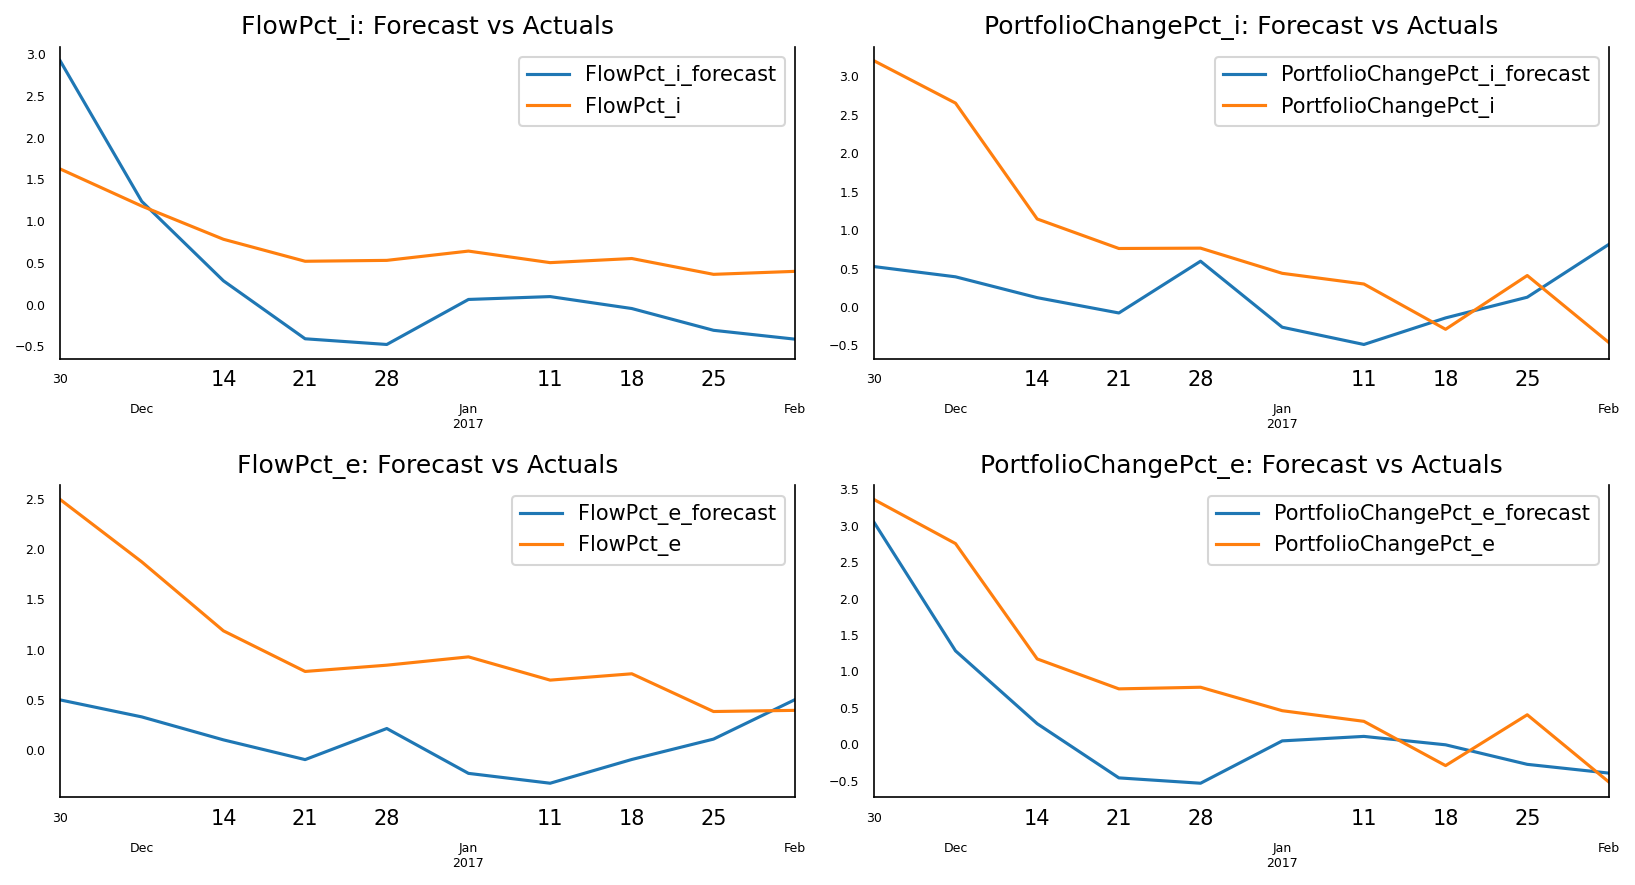

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    scb[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.76
corr :  0.9726

Forecast Accuracy of: PortfolioPct_i
rmse :  1.3012
corr :  0.2902

Forecast Accuracy of: FlowPct_e:
rmse :  1.089
corr :  0.4451

Forecast Accuracy of: PortfolioPct_e
rmse :  0.8399
corr :  0.8712


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07   -1   -1   -1  ...            -1            -1            -1
2016-12-14   -1   -1   -1  ...            -1            -1            -1
2016-12-21   -1   -1   -1  ...            -1            -1            -1
2016-12-28    0    0    0  ...             1             1             0
2017-01-04    1   -1    0  ...            -1            -1             1
2017-01-11   -1   -1   -1  ...            -1             0             0
2017-01-18    0   -1    0  ...             1             1            -1
2017-01-25   -1    1   -1  ...             1             1            -1
2017-02-01    0   -1    0  ...             1             1            -1

[10 rows x 8 columns]

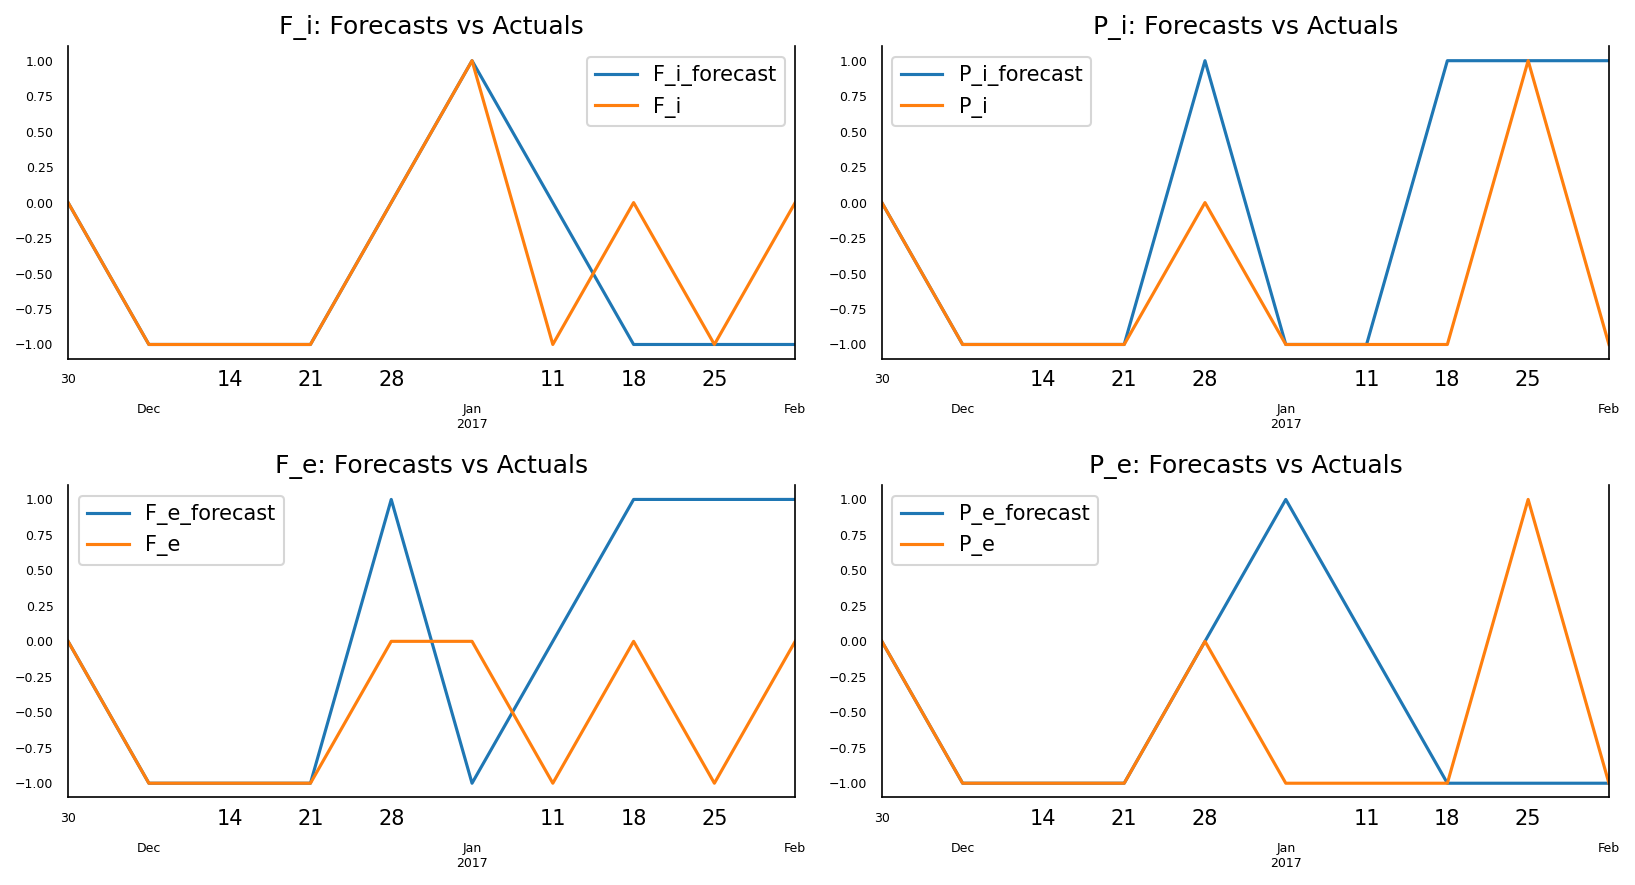

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.7
The accuracy score for PortfolioChangePct_i is 0.7
The accuracy score for FlowPct_e is 0.4
The accuracy score for PortfolioChangePct_e is 0.7


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             4   1   0
 0             2   2   0
 1             0   0   1, P_i_forecast  -1   0   1
P_i                     
-1             5   0   2
 0             0   1   1
 1             0   0   1, F_e_forecast  -1   0   1
F_e                     
-1             3   1   1
 0             1   1   3, P_e_forecast  -1   0   1
P_e                     
-1             5   1   1
 0             0   2   0
 1             1   0   0]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.026564014350016436 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.11984625462317772 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.36787944117144245 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.18536781534087982 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.3
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.3
FlowPct_e v.s. FlowPct_e_forecast: 0.6
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.3


### scg, Small Capital Growth

In [ ]:
# add index variable(s)
scg = add_index(scg)
scg.head()

FlowPct_i  PortfolioChangePct_i  ...  PortfolioChangePct_e  ClosePct_Dow
2006-01-25  -0.245700              1.169925  ...              1.186675     -0.148452
2006-02-01  -0.196125              1.503825  ...              1.625400      0.184134
2006-02-08  -0.184375              0.343025  ...              0.297050     -0.408638
2006-02-15  -0.149350              0.790925  ...              0.689325      0.479537
2006-02-22   0.167100              0.644350  ...              0.606150      0.990544

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(scg, variables = scg.columns)

FlowPct_i_x  ...  ClosePct_Dow_x
FlowPct_i_y                  1.0000  ...          0.0001
PortfolioChangePct_i_y       0.0036  ...          0.0759
FlowPct_e_y                  0.0019  ...          0.0054
PortfolioChangePct_e_y       0.0025  ...          0.0539
ClosePct_Dow_y               0.0144  ...          1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(scg)

Statistics analysis of Inst MF FlowPct

Statistic Test: -4.154502869500413
p-value: 0.0007860058064727058
 => P-Value = 0.0007860058064727058. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.831983908733561
p-value: 4.722035206755912e-05
 => P-Value = 4.722035206755912e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -5.684630755779572
p-value: 8.333827374085017e-07
 => P-Value = 8.333827374085017e-07. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.971197232303108
p-value: 2.529815669918413e-05
 => P-Value = 2.529815669918413e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.94146678779208
p-value: 2.894065178440262e-05
 => P-Value 

In [ ]:
# split data
split(scg, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(scg.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 1.97
PortfolioChangePct_i : 2.0
FlowPct_e : 1.96
PortfolioChangePct_e : 2.0
ClosePct_Dow : 2.01


In [ ]:
forecasting(scg)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

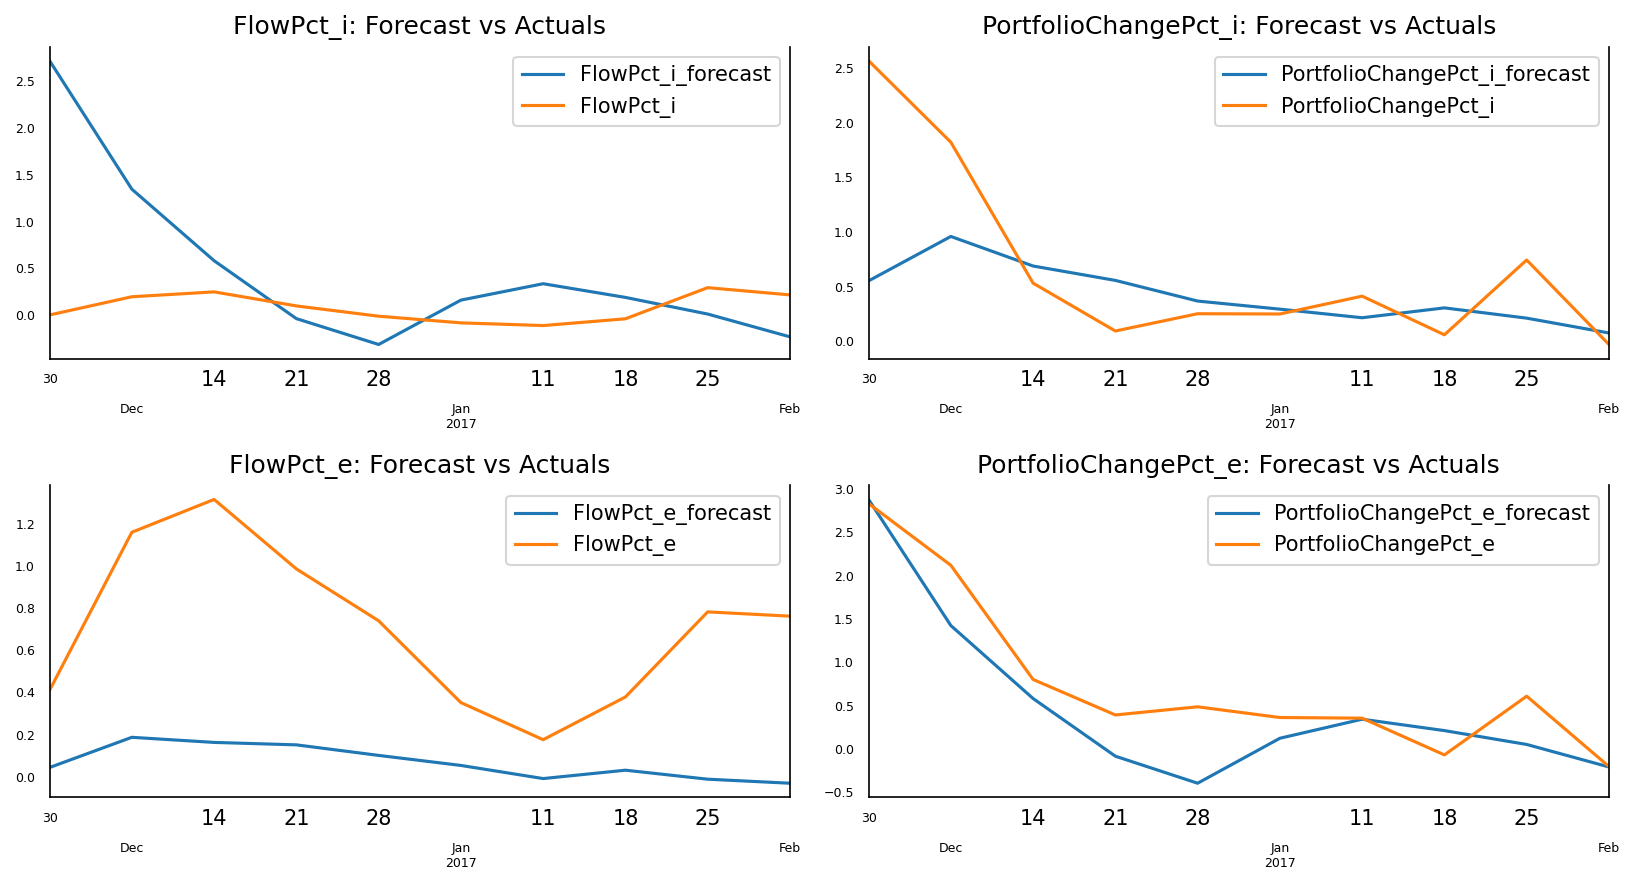

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    scg[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.9746
corr :  -0.0628

Forecast Accuracy of: PortfolioPct_i
rmse :  0.7376
corr :  0.5776

Forecast Accuracy of: FlowPct_e:
rmse :  0.7078
corr :  0.7164

Forecast Accuracy of: PortfolioPct_e
rmse :  0.4454
corr :  0.9279


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    1   -1    1  ...             1             1            -1
2016-12-14    0   -1    1  ...            -1             0            -1
2016-12-21   -1   -1   -1  ...            -1             0            -1
2016-12-28   -1    1   -1  ...            -1             0            -1
2017-01-04    0    0   -1  ...             0             0             1
2017-01-11    0    1   -1  ...             0             0             1
2017-01-18    0   -1    1  ...             0             0            -1
2017-01-25    1    1    1  ...             0             0            -1
2017-02-01    0   -1    0  ...            -1             0            -1

[10 rows x 8 columns]

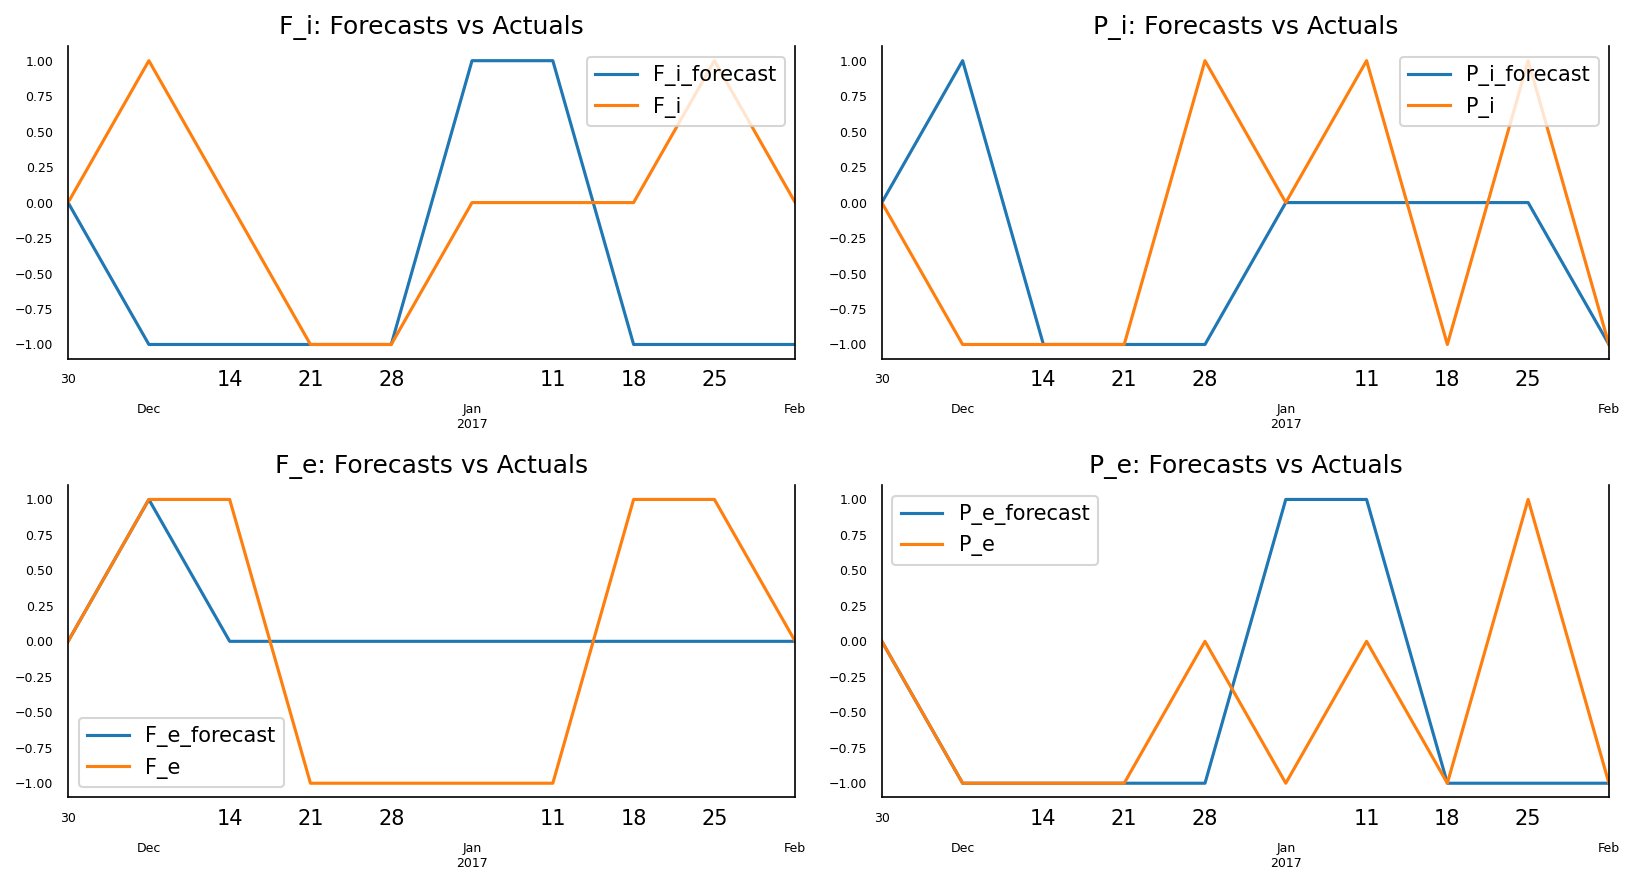

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.3
The accuracy score for PortfolioChangePct_i is 0.5
The accuracy score for FlowPct_e is 0.3
The accuracy score for PortfolioChangePct_e is 0.6


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             2   0   0
 0             3   1   2
 1             2   0   0, P_i_forecast  -1   0   1
P_i                     
-1             3   1   1
 0             0   2   0
 1             1   2   0, F_e_forecast  0  1
F_e               
-1            4  0
 0            2  0
 1            3  1, P_e_forecast  -1   0   1
P_e                     
-1             5   0   1
 0             1   1   1
 1             1   0   0]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.582009659930027 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.35457010675946826 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.4345982085070783 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.4495126234500444 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.7
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.5
FlowPct_e v.s. FlowPct_e_forecast: 0.7
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.4


### scv, Small Capital Value

In [ ]:
# add index variable(s)
scv = add_index(scv)
scv.head()

FlowPct_i  ...  ClosePct_Russell
2006-01-25  -0.256150  ...          1.322476
2006-02-01  -0.545500  ...          1.649421
2006-02-08  -0.324525  ...          0.366872
2006-02-15  -0.300500  ...          0.763936
2006-02-22  -0.170725  ...          0.604516

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(scv, variables = scv.columns)

FlowPct_i_x  ...  ClosePct_Russell_x
FlowPct_i_y                  1.0000  ...              0.0000
PortfolioChangePct_i_y       0.0296  ...              0.0019
FlowPct_e_y                  0.0028  ...              0.0003
PortfolioChangePct_e_y       0.0173  ...              0.0047
ClosePct_Russell_y           0.0252  ...              1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(scv)

Statistics analysis of Inst MF FlowPct

Statistic Test: -5.274353669393114
p-value: 6.186755855333842e-06
 => P-Value = 6.186755855333842e-06. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.964202185859204
p-value: 2.6113182200209752e-05
 => P-Value = 2.6113182200209752e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -5.488334958123464
p-value: 2.2039843958247113e-06
 => P-Value = 2.2039843958247113e-06. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -5.068884034770386
p-value: 1.6185752688629823e-05
 => P-Value = 1.6185752688629823e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -5.078985008611483
p-value: 1.5449147125858165e-05
 => 

In [ ]:
# split data
split(scv, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(scv.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.01
PortfolioChangePct_i : 2.0
FlowPct_e : 1.99
PortfolioChangePct_e : 2.0
ClosePct_Russell : 2.01


In [ ]:
forecasting(scv)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

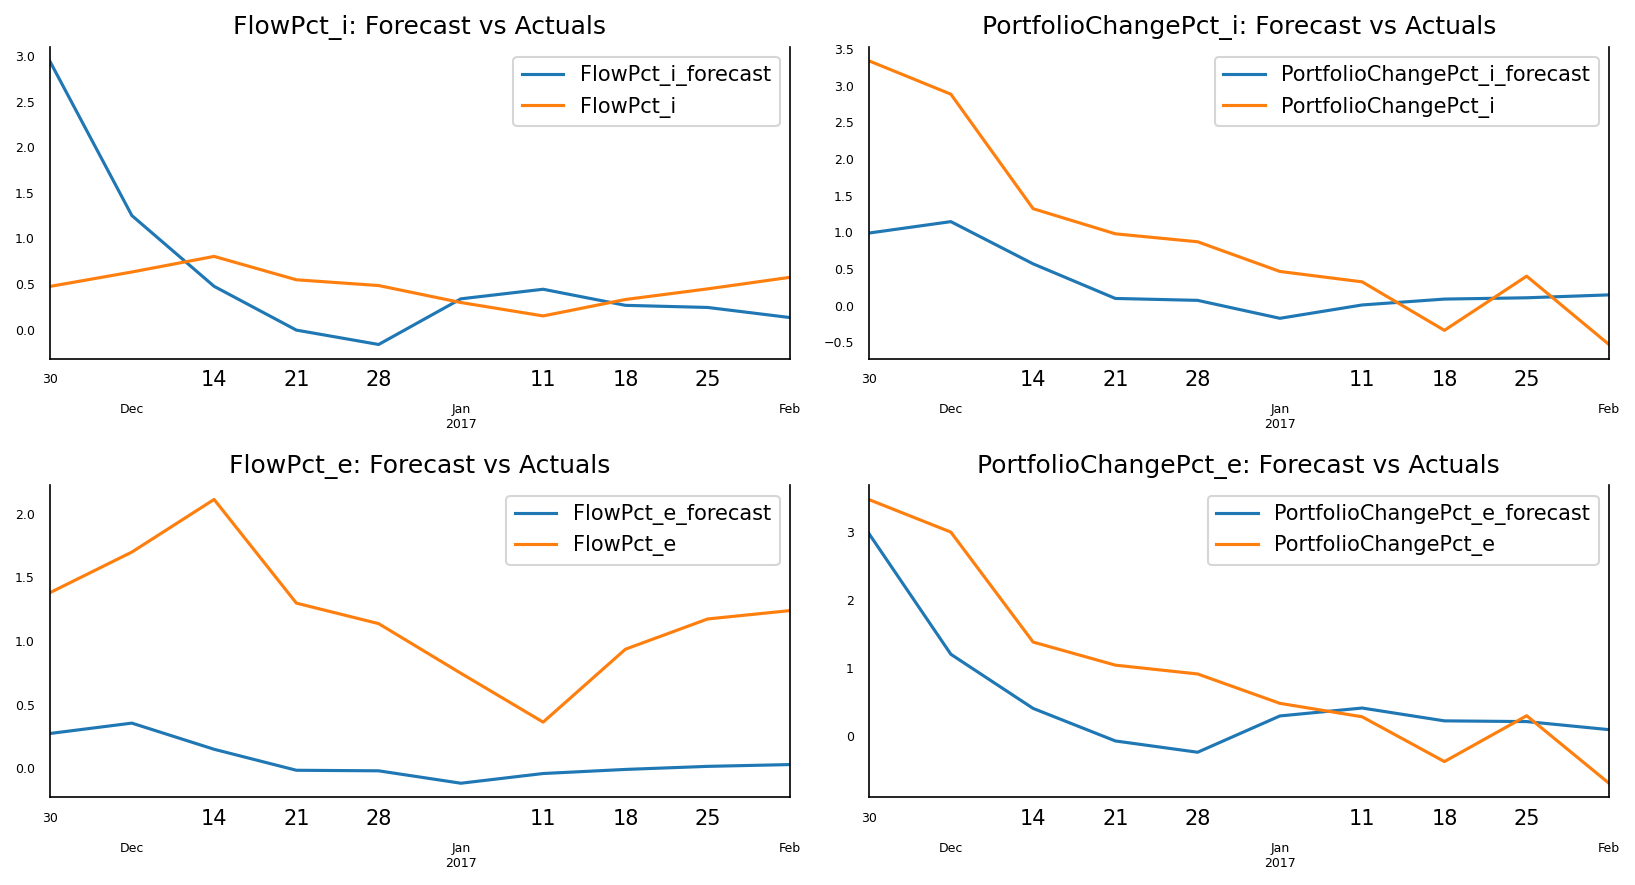

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    scv[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.8749
corr :  0.0772

Forecast Accuracy of: PortfolioPct_i
rmse :  1.0848
corr :  0.8746

Forecast Accuracy of: FlowPct_e:
rmse :  1.2058
corr :  0.6866

Forecast Accuracy of: PortfolioPct_e
rmse :  0.8973
corr :  0.7942


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    1   -1    1  ...             1             0            -1
2016-12-14    1   -1    1  ...            -1            -1            -1
2016-12-21   -1   -1   -1  ...            -1            -1            -1
2016-12-28    0   -1   -1  ...             0             0            -1
2017-01-04   -1   -1   -1  ...            -1             0             1
2017-01-11   -1   -1   -1  ...             1             0             1
2017-01-18    1   -1    1  ...             0             0            -1
2017-01-25    1    1    1  ...             0             0             0
2017-02-01    1   -1    0  ...             0             0            -1

[10 rows x 8 columns]

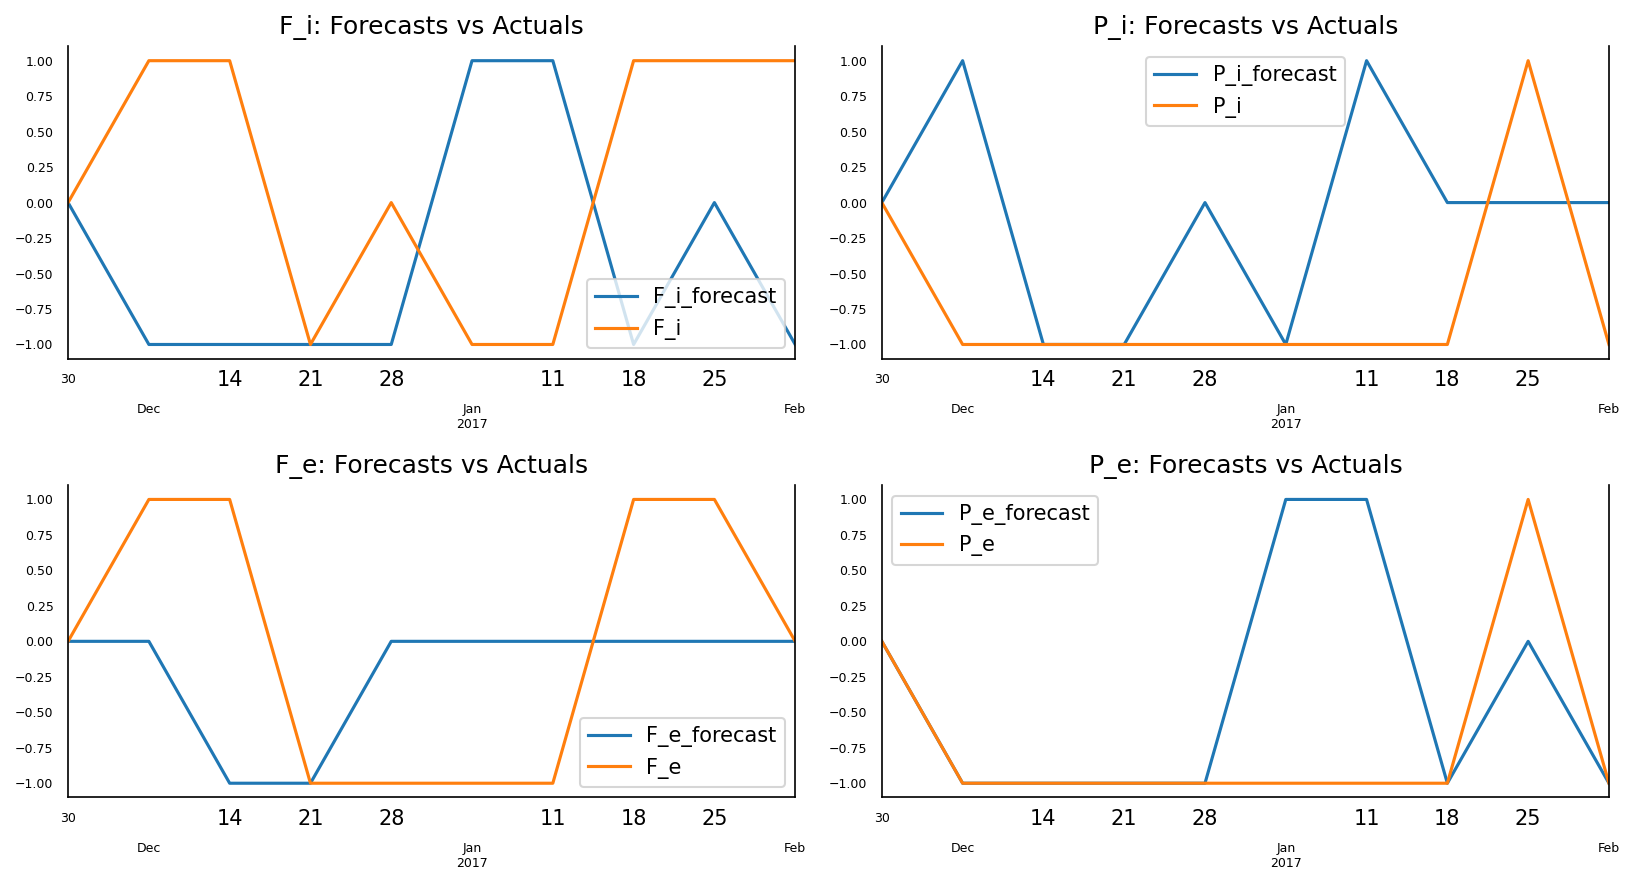

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.2
The accuracy score for PortfolioChangePct_i is 0.4
The accuracy score for FlowPct_e is 0.3
The accuracy score for PortfolioChangePct_e is 0.7


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             1   0   2
 0             1   1   0
 1             4   1   0, P_i_forecast  -1   0   1
P_i                     
-1             3   3   2
 0             0   1   0
 1             0   1   0, F_e_forecast  -1   0
F_e                 
-1             1   3
 0             0   2
 1             1   3, P_e_forecast  -1   0   1
P_e                     
-1             6   0   2
 0             0   1   0
 1             0   1   0]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.14187774148842547 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.6446357929354278 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.7316156289466418 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.04042768199451279 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.8
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.6
FlowPct_e v.s. FlowPct_e_forecast: 0.7
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.3


### tel, Telecom

In [ ]:
# add index variable(s)
tel = add_index(tel)
tel.head()

FlowPct_i  ...  ClosePct_Nasdaq
2006-01-25   0.065150  ...         0.374269
2006-02-01   0.182875  ...         0.539033
2006-02-08  -0.163500  ...        -0.682456
2006-02-15  -2.034750  ...        -0.023631
2006-02-22  -2.564875  ...         0.258645

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(tel, variables = tel.columns)

FlowPct_i_x  ...  ClosePct_Nasdaq_x
FlowPct_i_y                  1.0000  ...             0.0744
PortfolioChangePct_i_y       0.0380  ...             0.0045
FlowPct_e_y                  1.0000  ...             0.0744
PortfolioChangePct_e_y       0.0380  ...             0.0045
ClosePct_Nasdaq_y            0.0111  ...             1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(tel)

Statistics analysis of Inst MF FlowPct

Statistic Test: -4.997794087687404
p-value: 2.2417334885343217e-05
 => P-Value = 2.2417334885343217e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.653536304530625
p-value: 0.00010279529952683601
 => P-Value = 0.00010279529952683601. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -4.997794087687404
p-value: 2.2417334885343217e-05
 => P-Value = 2.2417334885343217e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.653536304530625
p-value: 0.00010279529952683601
 => P-Value = 0.00010279529952683601. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.759456112991914
p-value: 6.497783575218942e-05
 =>

In [ ]:
# split data
split(tel, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(tel.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.0
PortfolioChangePct_i : 1.99
FlowPct_e : 2.0
PortfolioChangePct_e : 1.99
ClosePct_Nasdaq : 2.0


In [ ]:
forecasting(tel)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

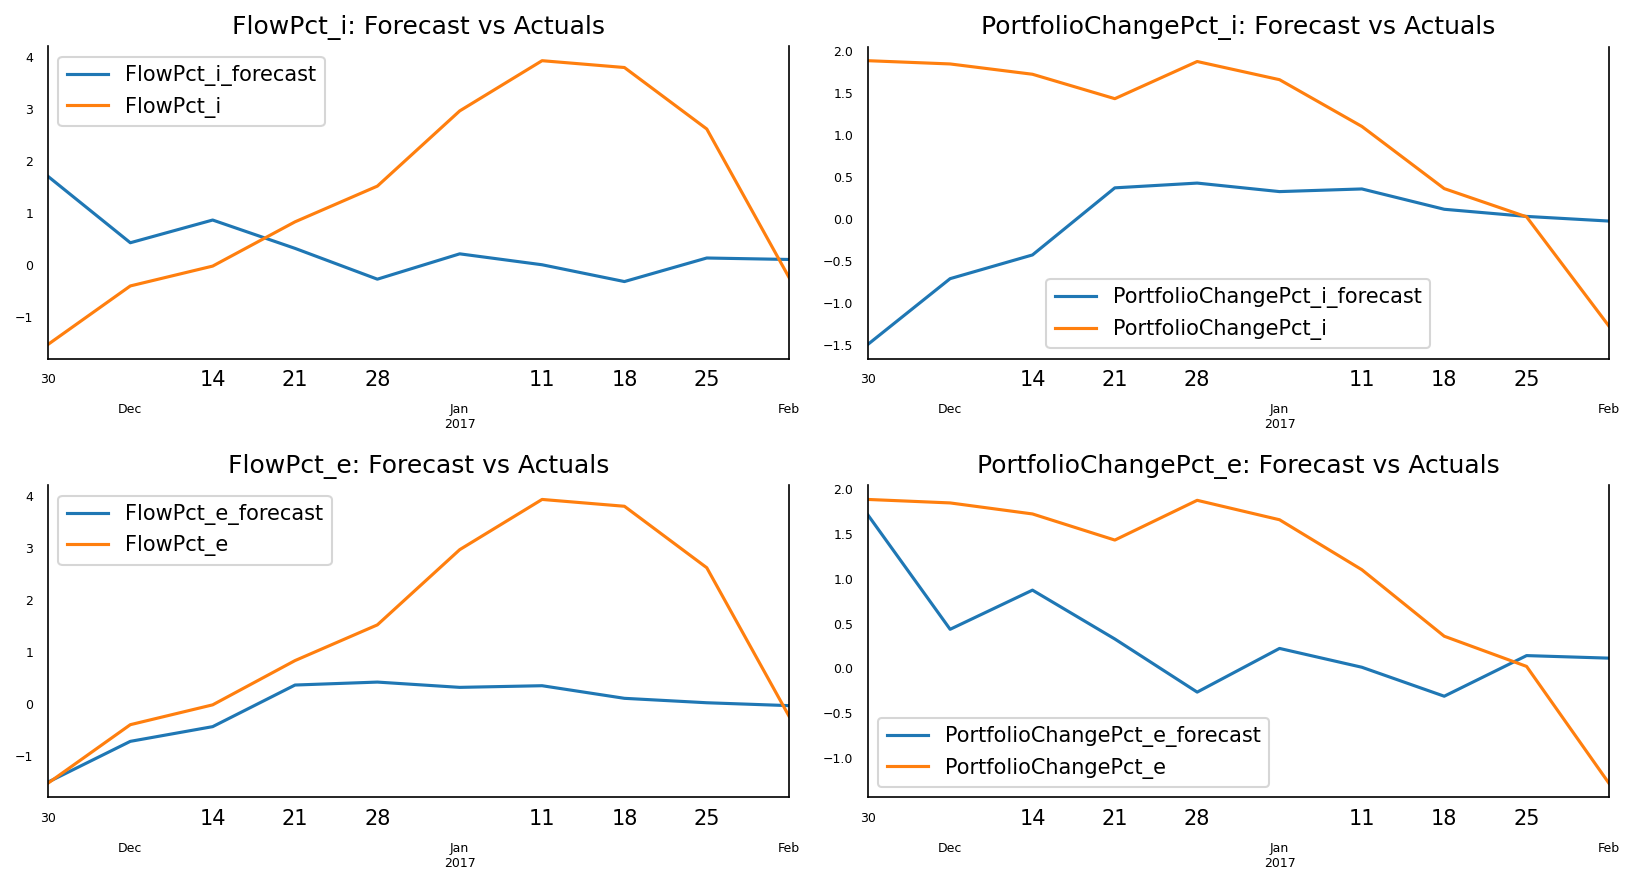

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    tel[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  2.4788
corr :  -0.7298

Forecast Accuracy of: PortfolioPct_i
rmse :  1.7261
corr :  -0.2468

Forecast Accuracy of: FlowPct_e:
rmse :  2.0468
corr :  0.7406

Forecast Accuracy of: PortfolioPct_e
rmse :  1.1897
corr :  0.386


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launche

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    1    0    1  ...             1             1            -1
2016-12-14    1   -1    1  ...             1             1             1
2016-12-21    1   -1    1  ...             1             1            -1
2016-12-28    1    1    1  ...             0             0            -1
2017-01-04    1   -1    1  ...            -1            -1             1
2017-01-11    1   -1    1  ...             0             0            -1
2017-01-18   -1   -1   -1  ...            -1            -1            -1
2017-01-25   -1   -1   -1  ...             0             0             1
2017-02-01   -1   -1   -1  ...             0             0             0

[10 rows x 8 columns]

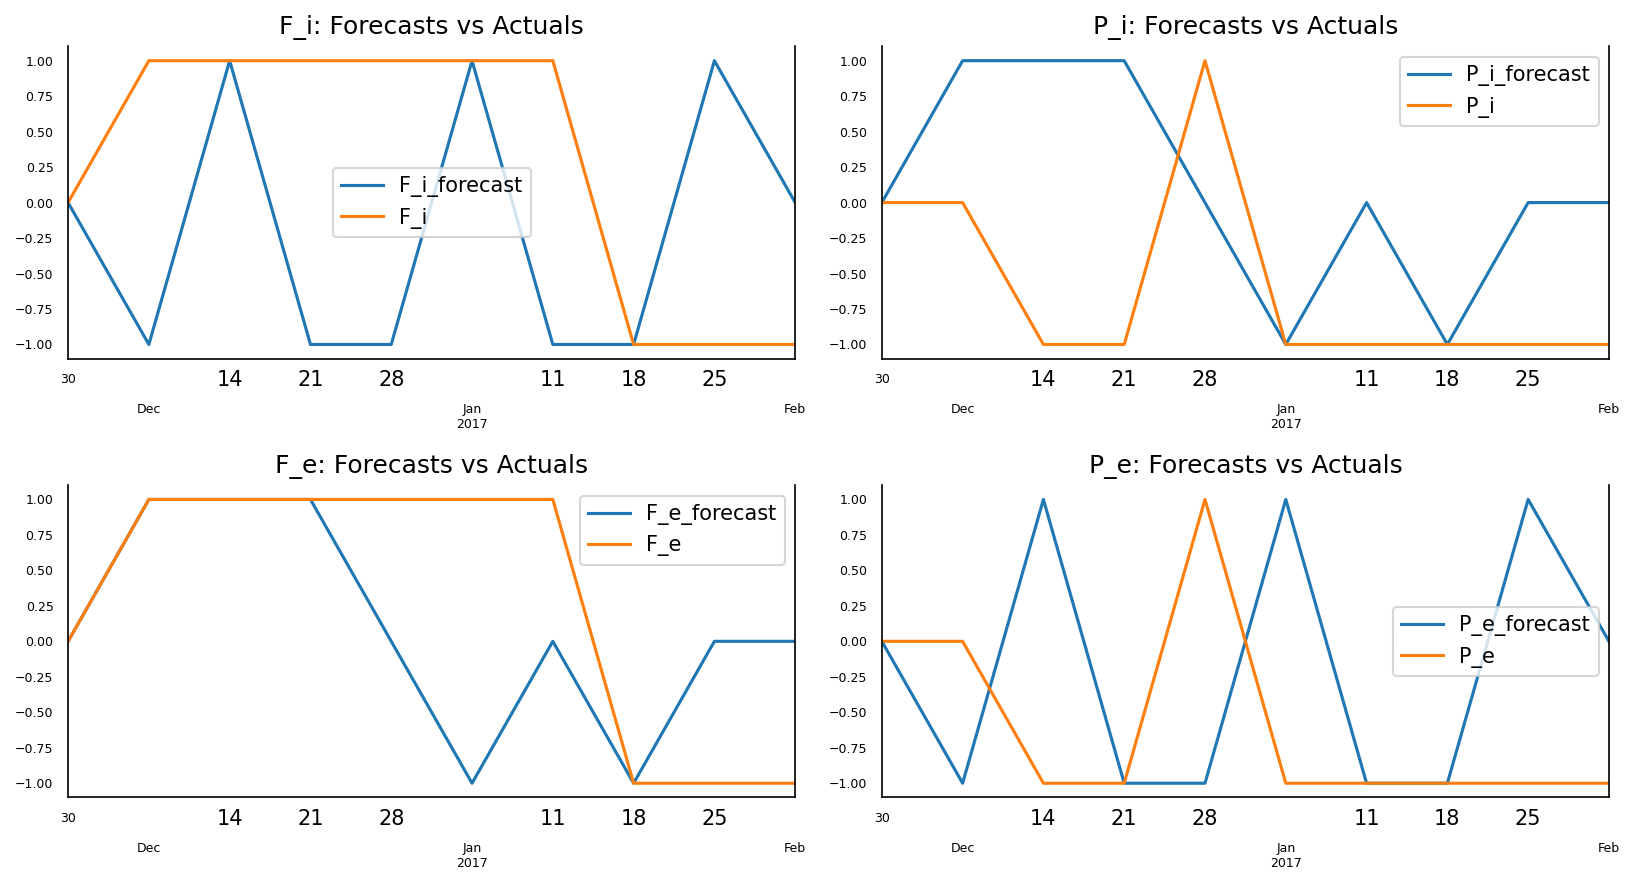

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.4
The accuracy score for PortfolioChangePct_i is 0.3
The accuracy score for FlowPct_e is 0.5
The accuracy score for PortfolioChangePct_e is 0.4


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             1   1   1
 0             0   1   0
 1             4   0   2, P_i_forecast  -1   0   1
P_i                     
-1             2   3   2
 0             0   1   1
 1             0   1   0, F_e_forecast  -1   0   1
F_e                     
-1             1   2   0
 0             0   1   0
 1             1   2   3, P_e_forecast  -1   0   1
P_e                     
-1             3   1   3
 0             1   1   0
 1             1   0   0]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.1991482734714558 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.7357588823428847 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.477878344488724 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.5459439747510074 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.6
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.7
FlowPct_e v.s. FlowPct_e_forecast: 0.5
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.6


### uti, Utilities

In [ ]:
# add index variable(s)
uti = add_index(uti)
uti.head()

FlowPct_i  ...  ClosePct_Nasdaq
2006-01-25   0.357775  ...         0.374269
2006-02-01   0.082700  ...         0.539033
2006-02-08  -0.230750  ...        -0.682456
2006-02-15  -0.175675  ...        -0.023631
2006-02-22   0.174300  ...         0.258645

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(uti, variables = uti.columns)

FlowPct_i_x  ...  ClosePct_Nasdaq_x
FlowPct_i_y                  1.0000  ...             0.0076
PortfolioChangePct_i_y       0.7874  ...             0.0051
FlowPct_e_y                  0.0018  ...             0.0045
PortfolioChangePct_e_y       0.5535  ...             0.0027
ClosePct_Nasdaq_y            0.1060  ...             1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(uti)

Statistics analysis of Inst MF FlowPct

Statistic Test: -5.580660186357118
p-value: 1.3990713141761392e-06
 => P-Value = 1.3990713141761392e-06. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -5.3652010505342735
p-value: 4.006431247280683e-06
 => P-Value = 4.006431247280683e-06. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -5.592019477867443
p-value: 1.3225045018133434e-06
 => P-Value = 1.3225045018133434e-06. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -5.886691647969968
p-value: 2.990044608949307e-07
 => P-Value = 2.990044608949307e-07. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.759456112991914
p-value: 6.497783575218942e-05
 => P-

In [ ]:
# split data
split(uti, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(uti.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 1.99
PortfolioChangePct_i : 2.02
FlowPct_e : 1.99
PortfolioChangePct_e : 2.02
ClosePct_Nasdaq : 2.0


In [ ]:
forecasting(uti)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

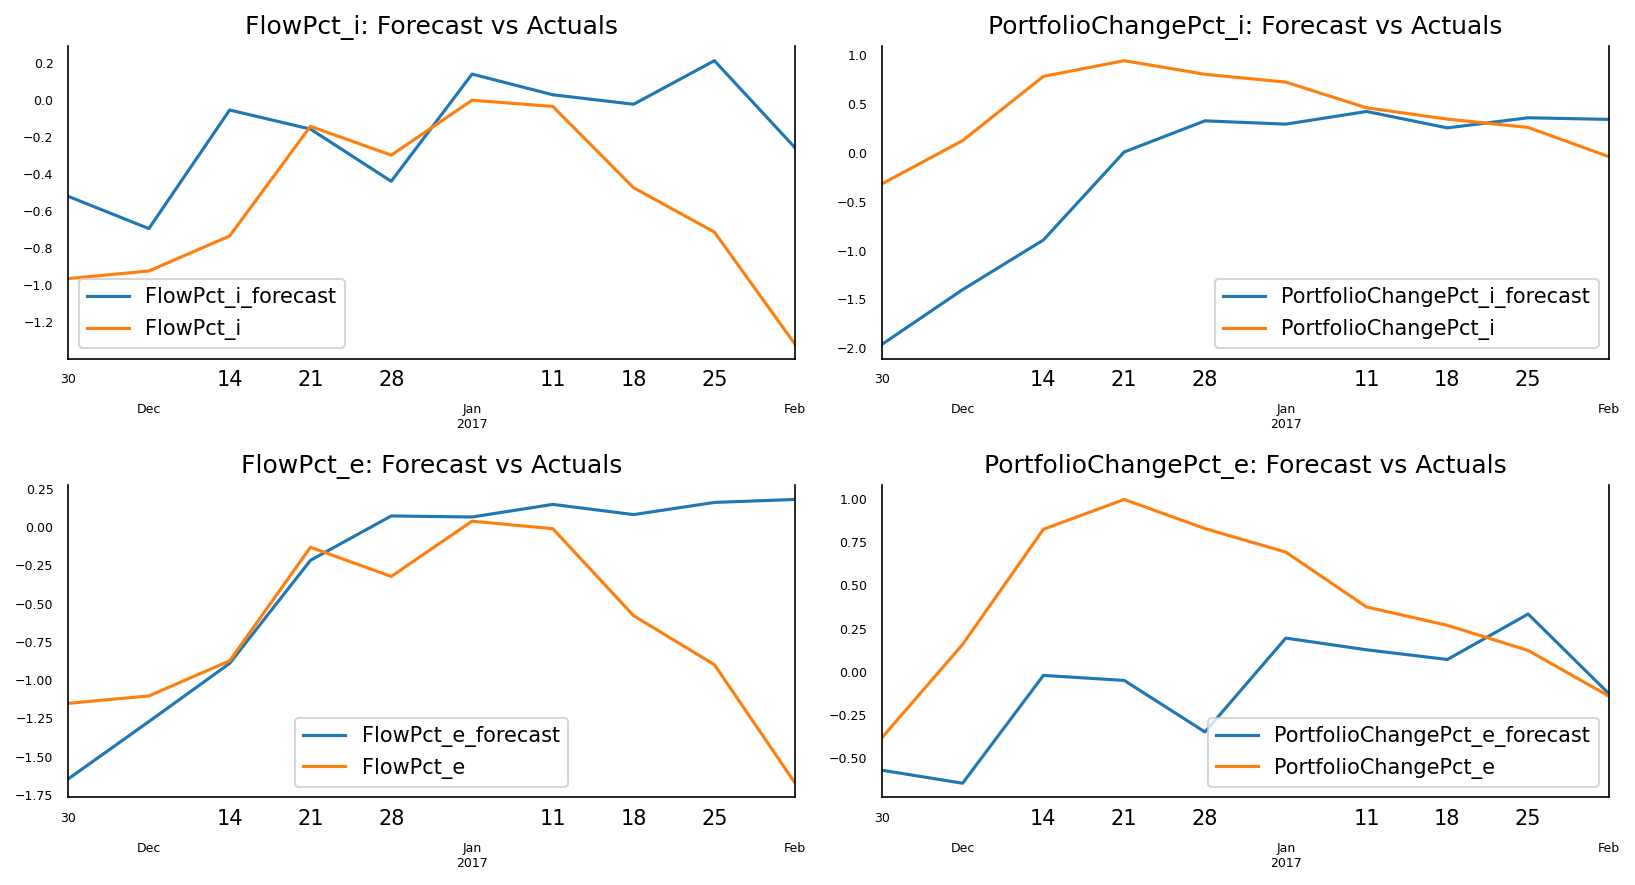

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    uti[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.5432
corr :  0.4607

Forecast Accuracy of: PortfolioPct_i
rmse :  0.9639
corr :  0.4719

Forecast Accuracy of: FlowPct_e:
rmse :  0.7392
corr :  0.3944

Forecast Accuracy of: PortfolioPct_e
rmse :  0.6528
corr :  0.308


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07    0    1    0  ...             1             1             0
2016-12-14    1    1    1  ...             1             1             1
2016-12-21    1    1    1  ...             1             1             0
2016-12-28   -1   -1   -1  ...             1             1            -1
2017-01-04    1    0    1  ...             0             0             1
2017-01-11    0   -1    0  ...             1             0             0
2017-01-18   -1   -1   -1  ...            -1             0             0
2017-01-25   -1    0   -1  ...             1             0             1
2017-02-01   -1   -1   -1  ...             0             0            -1

[10 rows x 8 columns]

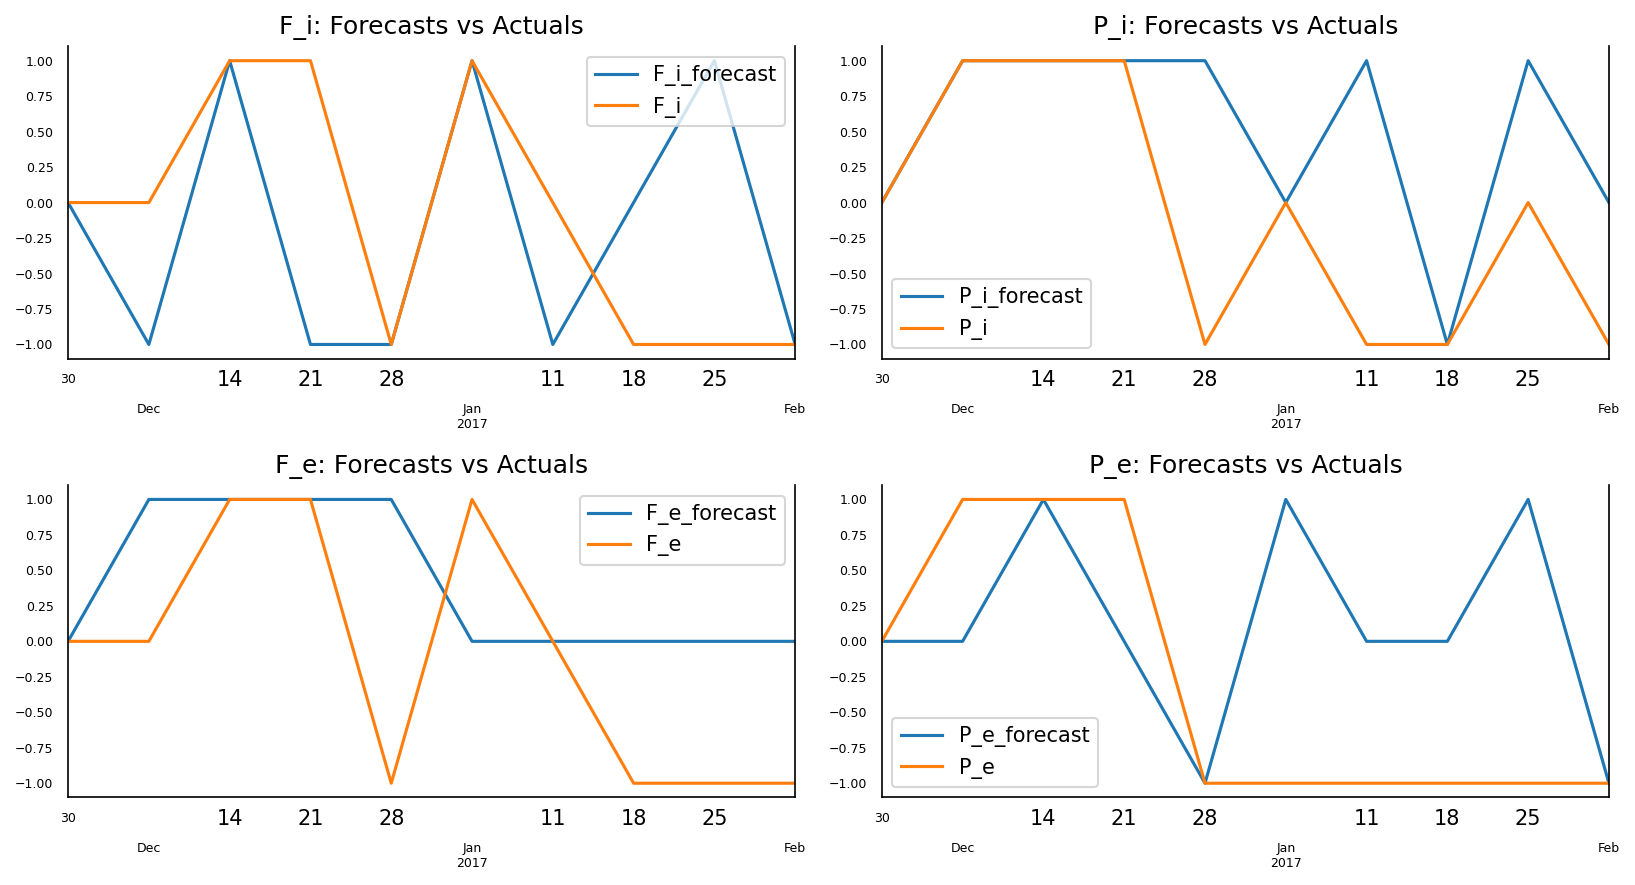

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.5
The accuracy score for PortfolioChangePct_i is 0.6
The accuracy score for FlowPct_e is 0.4
The accuracy score for PortfolioChangePct_e is 0.4


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             2   1   1
 0             2   1   0
 1             1   0   2, P_i_forecast  -1   0   1
P_i                     
-1             1   1   2
 0             0   2   1
 1             0   0   3, F_e_forecast  0  1
F_e               
-1            3  1
 0            2  1
 1            1  2, P_e_forecast  -1   0   1
P_e                     
-1             2   2   2
 0             0   1   0
 1             0   2   1]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.47366726176890683 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.2872974951836458 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.5169949242489345 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.6150599889366959 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.5
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.4
FlowPct_e v.s. FlowPct_e_forecast: 0.6
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.6


### tec, Technology

In [ ]:
# add index variable(s)
tec = add_index(tec)
tec.head()

FlowPct_i  PortfolioChangePct_i  ...  PortfolioChangePct_e  ClosePct_Dow
2006-01-25  -4.669523              0.390800  ...              0.773625     -0.148452
2006-02-01  -0.035400              0.839200  ...              0.845825      0.184134
2006-02-08  -0.344775             -0.677400  ...             -0.678725     -0.408638
2006-02-15  -0.790025              0.012725  ...              0.014375      0.479537
2006-02-22   0.244525              0.215375  ...              0.220075      0.990544

[5 rows x 5 columns]

In [ ]:
# grangers causation
grangers_causation_matrix(tec, variables = tec.columns)

FlowPct_i_x  ...  ClosePct_Dow_x
FlowPct_i_y                  1.0000  ...          0.0010
PortfolioChangePct_i_y       0.0631  ...          0.0763
FlowPct_e_y                  0.1141  ...          0.0034
PortfolioChangePct_e_y       0.0596  ...          0.0655
ClosePct_Dow_y               0.0452  ...          1.0000

[5 rows x 5 columns]

In [ ]:
# adf
adf_test(tec)

Statistics analysis of Inst MF FlowPct

Statistic Test: -5.206781110711169
p-value: 8.516101150312323e-06
 => P-Value = 8.516101150312323e-06. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of Inst MF PortfolioChangePct

Statistic Test: -4.8560526743518775
p-value: 4.2435436483546466e-05
 => P-Value = 4.2435436483546466e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of ETF FlowPct

Statistic Test: -4.919735394210278
p-value: 3.1917377482040776e-05
 => P-Value = 3.1917377482040776e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

----------------------------------------
Statistics analysis of ETF PortfolioChangePct

Statistic Test: -4.8636774586659905
p-value: 4.101935838204041e-05
 => P-Value = 4.101935838204041e-05. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of Index ClosePct

Statistic Test: -4.94146678779208
p-value: 2.894065178440262e-05
 => P-

In [ ]:
# split data
split(tec, 10)

In [ ]:
## use lag 10
forecasting_model = VAR(train)
results = forecasting_model.fit(10)
#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(uti.columns, out):
    print(col, ':', round(val, 2))

FlowPct_i : 2.0
PortfolioChangePct_i : 1.98
FlowPct_e : 2.0
PortfolioChangePct_e : 1.98
ClosePct_Nasdaq : 2.0


In [ ]:
forecasting(tec)

In [ ]:
test["FlowPct_i_forecast"] = forecast["FlowPct_i_forecast"]
test["PortfolioChangePct_i_forecast"] = forecast["PortfolioChangePct_i_forecast"]
test["FlowPct_e_forecast"] = forecast["FlowPct_e_forecast"]
test["PortfolioChangePct_e_forecast"] = forecast["PortfolioChangePct_e_forecast"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

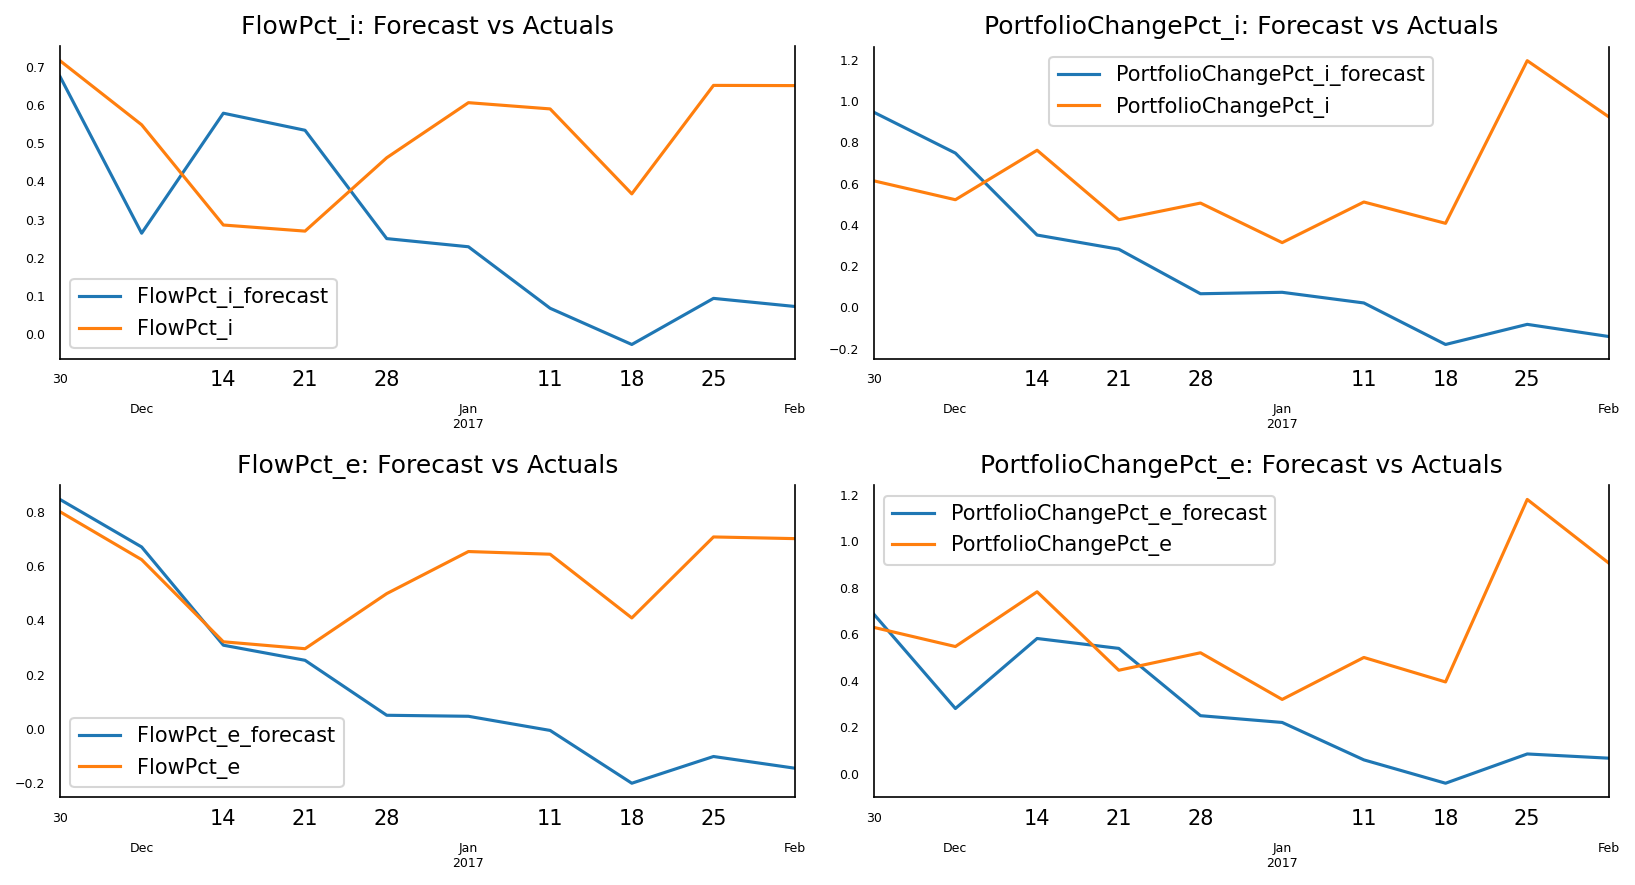

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    test[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    tec[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print_forecast_accuracy(test)

Forecast Accuracy of: FlowPct_i:
rmse :  0.3865
corr :  -0.2266

Forecast Accuracy of: PortfolioPct_i
rmse :  0.6285
corr :  -0.1789

Forecast Accuracy of: FlowPct_e:
rmse :  0.5237
corr :  0.1672

Forecast Accuracy of: PortfolioPct_e
rmse :  0.4987
corr :  -0.0721


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

In [ ]:
direc = test.copy()

direc["F_i"] = 0
direc["P_i"] = 0
direc["F_e"] = 0
direc["P_e"] = 0
direc["F_i_forecast"] = 0
direc["P_i_forecast"] = 0
direc["F_e_forecast"] = 0
direc["P_e_forecast"] = 0

In [ ]:
change_binary(direc)
direc = direc.iloc[:, 9:]
direc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-pa

F_i  P_i  F_e  ...  P_i_forecast  F_e_forecast  P_e_forecast
2016-11-30    0    0    0  ...             0             0             0
2016-12-07   -1    0   -1  ...            -1            -1            -1
2016-12-14   -1    1   -1  ...            -1            -1             1
2016-12-21    0   -1    0  ...             0             0             0
2016-12-28    1    0    1  ...            -1            -1            -1
2017-01-04    1   -1    1  ...             0             0             0
2017-01-11    0    1    0  ...             0             0            -1
2017-01-18   -1   -1   -1  ...            -1            -1            -1
2017-01-25    1    1    1  ...             0             0             1
2017-02-01    0   -1    0  ...             0             0             0

[10 rows x 8 columns]

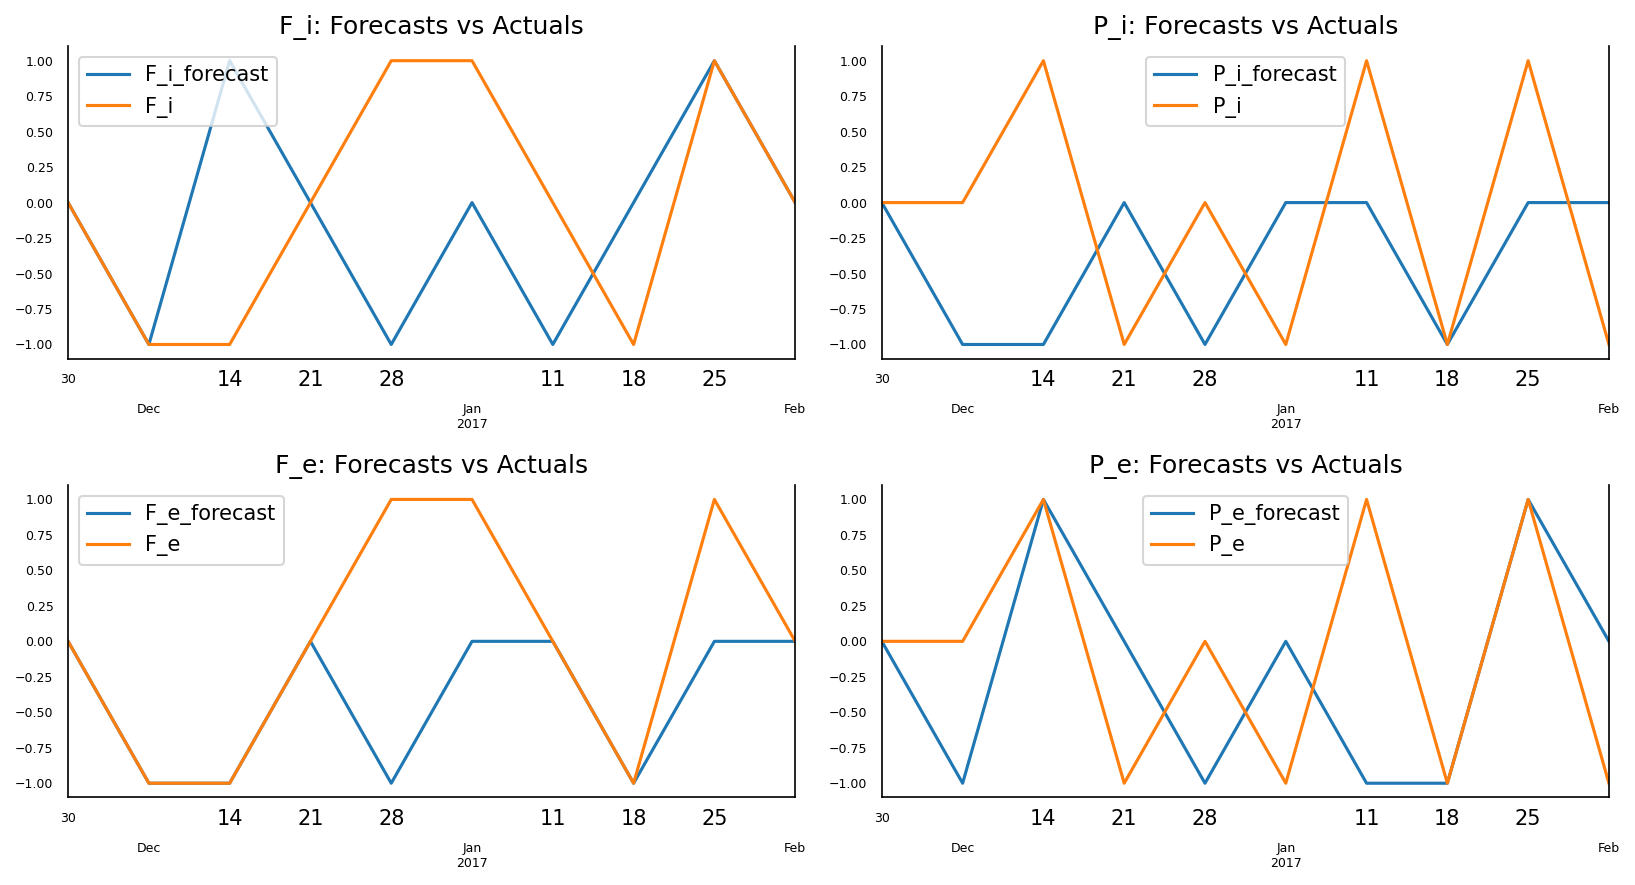

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(11,6))
for j, (col,ax) in enumerate(zip(direc.columns, axes.flatten())):
    direc[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    direc[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecasts vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
direc_accuracy(direc)

The accuracy score for FlowPct_i is 0.5
The accuracy score for PortfolioChangePct_i is 0.2
The accuracy score for FlowPct_e is 0.7
The accuracy score for PortfolioChangePct_e is 0.4


In [ ]:
# Use Chi-squared test to determine if there is a statistically significant difference between actuals and forecasts
table = crosstab(direc)
chi_sq_test(table)

Contingency table:
[F_i_forecast  -1   0   1
F_i                     
-1             1   1   1
 0             1   3   0
 1             1   1   1, P_i_forecast  -1   0
P_i                 
-1             1   3
 0             2   1
 1             1   2, F_e_forecast  -1   0
F_e                 
-1             3   0
 0             0   4
 1             1   2, P_e_forecast  -1   0   1
P_e                     
-1             1   3   0
 0             2   1   0
 1             1   0   2]
FlowPct_i v.s. FlowPct_i_forecast:
p-value: 0.6949629742611338 

PortfolioPct_i v.s. PortfolioPct_i_forecast:
p-value: 0.5169949242489345 

FlowPct_e v.s. FlowPct_e_forecast:
p-value: 0.02702180595120904 

PortfolioPct_e v.s. PortfolioPct_e_forecast:
p-value: 0.09467894184013527 



In [ ]:
# Use hamming_distance to calculate the distance between actuals and forecasts
hamming_distance(direc)

Hamming distance between actuals and forecasts:

FlowPct_i v.s. FlowPct_i_forecast: 0.5
PortfolioPct_i v.s. PortfolioPct_i_forecast: 0.8
FlowPct_e v.s. FlowPct_e_forecast: 0.3
PortfolioPct_e v.s. PortfolioPct_e_forecast: 0.6
